# Homework 10 - CIFAR10 Image Classification with PyTorch

## About

The goal of the homework is to train a convolutional neural network on the standard CIFAR10 image classfication dataset.

When solving machine learning tasks using neural networks, one typically starts with a simple network architecture and then improves the network by adding new layers, retraining, adjusting parameters, retraining, etc.  We attempt to illustrate this process below with several architecture improvements.


## Dev Environment
### Working on Google Colab
You may choose to work locally or on Google Colaboratory. You have access to free compute through this service.   Colab is recommended since it will be setup correctly and will have access to GPU resources.
1. Visit https://colab.research.google.com/drive 
2. Navigate to the **`Upload`** tab, and upload your `HW10.ipynb`
3. Now on the top right corner, under the `Comment` and `Share` options, you should see a `Connect` option. Once you are connected, you will have access to a VM with 12GB RAM, 50 GB disk space and a single GPU. The dropdown menu will allow you to connect to a local runtime as well.

**Notes:** 
* **If you do not have a working setup for Python 3, this is your best bet. It will also save you from heavy installations like `tensorflow` if you don't want to deal with those.**
* ***There is a downside*. You can only use this instance for a single 12-hour stretch, after which your data will be deleted, and you would have redownload all your datasets, any libraries not already on the VM, and regenerate your logs**.


### Installing PyTorch and Dependencies

The instructions for installing and setting up PyTorch can be found at https://pytorch.org/get-started/locally/. Make sure you follow the instructions for your machine. For any of the remaining libraries used in this assignment:
* We have provided a `hw8_requirements.txt` file on the homework web page. 
* Download this file, and in the same directory you can run `pip3 install -r hw8_requirements.txt`
​
Check that PyTorch installed correctly by running the following:

In [0]:
import torch
torch.rand(5, 3)

tensor([[0.6626, 0.3950, 0.5138],
        [0.0493, 0.0939, 0.1592],
        [0.8296, 0.1022, 0.8555],
        [0.2304, 0.8264, 0.6811],
        [0.4494, 0.9821, 0.1311]])

## Part 0 Imports and Basic Setup  (5 Points)

First, import the required libraries as follows. The libraries we will use will be the same as those in HW8. 

In [0]:
import numpy as np
import torch
from torch import nn
from torch import optim

import matplotlib.pyplot as plt

**GPU Support**

Training of large network can take a long time. PyTorch supports GPU with just a small amount of effort.

When creating our networks, we will call 
`net.to(device)` to tell the network to train on the GPU, if one is available.  Note, if the network utilizes the GPU, it is important that any tensors we use with it (such as the data) also reside on the CPU.  Thus, a call like `images = images.to(device)` is necessary with any data we want to use with the GPU.

Note: If you can't get access to a GPU, don't worry to much.  Since we use very small networks, the difference between CPU and GPU isn't large and in some cases GPU will actually be slower.

In [0]:
import torch.cuda as cuda

# Use a GPU, i.e. cuda:0 device if it available.
device = torch.device("cuda:0" if cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
#@title Training Code
import time

class Flatten(nn.Module):
  """NN Module that flattens the incoming tensor."""
  def forward(self, input):
    return input.view(input.size(0), -1)
  
def train(model, train_loader, test_loader, loss_func, opt, num_epochs=10):
  all_training_loss = np.zeros((0,2))
  all_training_acc = np.zeros((0,2))
  all_test_loss = np.zeros((0,2))
  all_test_acc = np.zeros((0,2))
  
  training_step = 0
  training_loss, training_acc = 2.0, 0.0
  print_every = 1000
  
  start = time.clock()
  
  for i in range(num_epochs):
    epoch_start = time.clock() 
   
    model.train()
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      opt.zero_grad()

      preds = model(images)
      loss = loss_func(preds, labels)
      loss.backward()
      opt.step()
      
      training_loss += loss.item()
      training_acc += (torch.argmax(preds, dim=1)==labels).float().mean()
      
      if training_step % print_every == 0:
        training_loss /= print_every
        training_acc /= print_every
        
        all_training_loss = np.concatenate((all_training_loss, [[training_step, training_loss]]))
        all_training_acc = np.concatenate((all_training_acc, [[training_step, training_acc]]))
        
        print('  Epoch %d @ step %d: Train Loss: %3f, Train Accuracy: %3f' % (
            i, training_step, training_loss, training_acc))
        training_loss, training_acc = 0.0, 0.0
        
      training_step+=1

    model.eval()
    with torch.no_grad():
      validation_loss, validation_acc = 0.0, 0.0
      count = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        validation_loss+=loss_func(output,labels)
        validation_acc+=(torch.argmax(output, dim=1) == labels).float().mean()
        count += 1
      validation_loss/=count
      validation_acc/=count
      
      all_test_loss = np.concatenate((all_test_loss, [[training_step, validation_loss]]))
      all_test_acc = np.concatenate((all_test_acc, [[training_step, validation_acc]]))
      
      epoch_time = time.clock() - epoch_start
      
      print('Epoch %d Test Loss: %3f, Test Accuracy: %3f, time: %.1fs' % (
          i, validation_loss, validation_acc, epoch_time))
      
  total_time = time.clock() - start
  print('Final Test Loss: %3f, Test Accuracy: %3f, Total time: %.1fs' % (
      validation_loss, validation_acc, total_time))

  return {'loss': { 'train': all_training_loss, 'test': all_test_loss },
          'accuracy': { 'train': all_training_acc, 'test': all_test_acc }}

def plot_graphs(model_name, metrics):
  for metric, values in metrics.items():
    for name, v in values.items():
      plt.plot(v[:,0], v[:,1], label=name)
    plt.title(f'{metric} for {model_name}')
    plt.legend()
    plt.xlabel("Training Steps")
    plt.ylabel(metric)
    plt.show()
    

Load the** CIFA-10** dataset and define the transformations. You may also want to print its structure, size, as well as sample a few images to get a sense of how to design the network. 

In [0]:
!mkdir hw10_data

In [0]:
# Download the data.
from torchvision import datasets, transforms

transformations = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = datasets.CIFAR10(root='hw10_data/', download=True, transform=transformations)
test_set = datasets.CIFAR10(root='hw10_data', download=True, train=False, transform=transformations)

0it [00:00, ?it/s]

100%|█████████▉| 170409984/170498071 [00:35<00:00, 2101539.96it/s]

Files already downloaded and verified


Use `DataLoader` to create a loader for the training set and a loader for the testing set. You can use a `batch_size` of 8 to start, and change it if you wish.

In [0]:
from torch.utils.data import DataLoader

batch_size = 8
train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=True, num_workers=2)

input_shape = np.array(train_set[0][0]).shape
input_dim = input_shape[1]*input_shape[2]*input_shape[0]


In [0]:
training_epochs = 5

## Part 1 CIFAR10 with Fully Connected Neural Netowrk (25 Points)

As a warm-up, let's begin by training a two-layer fully connected neural network model on ** CIFAR-10** dataset. You may go back to check HW8 for some basics.

We will give you this code to use as a baseline to compare against your CNN models.

In [0]:
class TwoLayerModel(nn.Module):
  def __init__(self):
    super(TwoLayerModel, self).__init__()
    self.net = nn.Sequential(
      Flatten(), 
      nn.Linear(input_dim, 64), 
      nn.ReLU(), 
      nn.Linear(64, 10))
    
  def forward(self, x):
    return self.net(x)

model = TwoLayerModel().to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.01)

# Training epoch should be about 15-20 sec each on GPU.
metrics = train(model, train_loader, test_loader, loss, optimizer, training_epochs)

  Epoch 0 @ step 0: Train Loss: 0.004303, Train Accuracy: 0.000125


170500096it [00:50, 2101539.96it/s]                               

  Epoch 0 @ step 1000: Train Loss: 1.951483, Train Accuracy: 0.334500
  Epoch 0 @ step 2000: Train Loss: 1.803716, Train Accuracy: 0.352875
  Epoch 0 @ step 3000: Train Loss: 1.790826, Train Accuracy: 0.356875
  Epoch 0 @ step 4000: Train Loss: 1.783943, Train Accuracy: 0.357125
  Epoch 0 @ step 5000: Train Loss: 1.771074, Train Accuracy: 0.365125
  Epoch 0 @ step 6000: Train Loss: 1.747424, Train Accuracy: 0.375375
Epoch 0 Test Loss: 1.696952, Test Accuracy: 0.392700, time: 17.9s
  Epoch 1 @ step 7000: Train Loss: 1.752460, Train Accuracy: 0.377125
  Epoch 1 @ step 8000: Train Loss: 1.749601, Train Accuracy: 0.377625
  Epoch 1 @ step 9000: Train Loss: 1.730119, Train Accuracy: 0.385000
  Epoch 1 @ step 10000: Train Loss: 1.750363, Train Accuracy: 0.382750
  Epoch 1 @ step 11000: Train Loss: 1.740194, Train Accuracy: 0.379375
  Epoch 1 @ step 12000: Train Loss: 1.743895, Train Accuracy: 0.370250
Epoch 1 Test Loss: 1.722507, Test Accuracy: 0.388200, time: 18.0s
  Epoch 2 @ step 13000: T

**Plot the model results**

Normally we would want to use Tensorboard for looking at metrics.  However, if colab reset while we are working, we might lose our logs and therefore our metrics.  Let's just plot some graphs that will survive across colab instances.

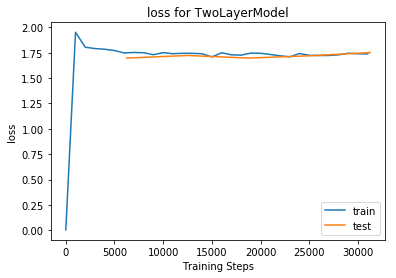

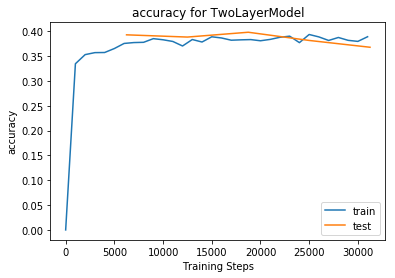

In [0]:
plot_graphs("TwoLayerModel", metrics)

## Part 2 Convolutional Neural Network (CNN) (35 Points)

Now, let's design a convolution neural netwrok!

Build a simple CNN model, inserting 2 CNN layers in from of our 2 layer fully connect model from above:

1. A convolution with	3x3 filter, 16 output channels, stride = 1, padding=1
2. A ReLU activation
2. A Max-Pooling layer with 2x2 window
3. A convolution,	3x3 filter, 16 output channels, stride = 1, padding=1
4. A ReLU activation
4. Flatten layer
5. Fully connected linear layer with output size 64
6. ReLU
7. Fully connected linear layer, with output size 10

You will have to figure out the input sizes of the first fully connnected layer based on the previous layer sizes. Note that you also need to fill those in the report section (see report section in the notebook for details) 

In [0]:
import torch.nn.functional as F
class ConvModel(nn.Module):
  # Your Code Here
  def __init__(self):
    super(ConvModel, self).__init__()
    ##define convolution layers
    self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size = 3,stride=1, padding=1)##Size([8, 16, 32, 32])
    self.conv2 = nn.Conv2d(in_channels=16,out_channels=16,kernel_size = 3,stride=1, padding=1)##Size([8, 16, 16, 16])

    ##define fully connected layers
    self.fc1 = nn.Linear(16*16*16, 64)
    self.fc2 = nn.Linear(64, 10)

    ##define flatten
    self.flatten = Flatten()

  def forward(self, x):
    #Apply convolution1, relu and maxpooling
      x = self.conv1(x)
      x = F.relu(x)
      x = F.max_pool2d(x, (2, 2))##Size([8, 16, 16, 16])

      #Apply convolution2, relu
      x = self.conv2(x)
      x = F.relu(x)

      ##Flatten 
      x = self.flatten(x)
      ##fully connected layers
      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)
      return x

model = ConvModel().to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.01)

metrics = train(model, train_loader, test_loader, loss, optimizer, training_epochs)

  Epoch 0 @ step 0: Train Loss: 0.004239, Train Accuracy: 0.000250
  Epoch 0 @ step 1000: Train Loss: 1.832785, Train Accuracy: 0.325375
  Epoch 0 @ step 2000: Train Loss: 1.635091, Train Accuracy: 0.397625
  Epoch 0 @ step 3000: Train Loss: 1.524421, Train Accuracy: 0.445375
  Epoch 0 @ step 4000: Train Loss: 1.456644, Train Accuracy: 0.468000
  Epoch 0 @ step 5000: Train Loss: 1.422762, Train Accuracy: 0.479750
  Epoch 0 @ step 6000: Train Loss: 1.413759, Train Accuracy: 0.483875
Epoch 0 Test Loss: 1.401174, Test Accuracy: 0.502700, time: 24.7s
  Epoch 1 @ step 7000: Train Loss: 1.390499, Train Accuracy: 0.495875
  Epoch 1 @ step 8000: Train Loss: 1.358934, Train Accuracy: 0.512750
  Epoch 1 @ step 9000: Train Loss: 1.347796, Train Accuracy: 0.511125
  Epoch 1 @ step 10000: Train Loss: 1.334809, Train Accuracy: 0.523000
  Epoch 1 @ step 11000: Train Loss: 1.340734, Train Accuracy: 0.518500
  Epoch 1 @ step 12000: Train Loss: 1.329528, Train Accuracy: 0.521125
Epoch 1 Test Loss: 1.346

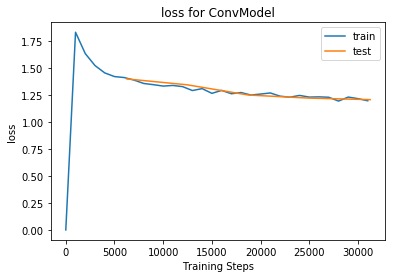

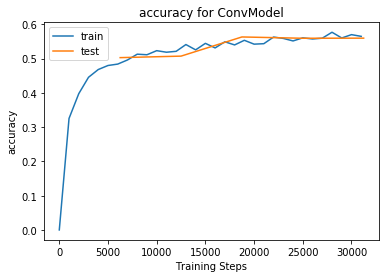

In [0]:
plot_graphs("ConvModel", metrics)

Do you notice the improvement over the accuracy compared to that in Part 1?

Yes, both accuray and loss imporves compred to part 1. 

## Part 3 Open Design Competition (35 Points + 10 bonus points)

Try to beat the previous models by adding additional layers, changing parameters, etc.  You should add at least one layer.

Possible changes include:
*   Dropout
*   Batch Normalization
*   More layers
*   Residual Connections (harder)
*   Change layer size
*   Pooling layers, stride
*   Different optimizer
*   Train for longer

Once you have a model you think is great, evaluate it against our hidden test data (see hidden_loader above) and upload the results to the leader board on gradescope.  **The top 3 scorers will get a bonus 10 points.**

You can steal model structures found on the internet if you want.  The only constraint is that **you must train the model from scratch**.


In [0]:
# You Awesome Super Best model code here (ResNet)
class ResidualBlock(nn.Module):
  def __init__(self, inchannel, outchannel, stride=1):
    super(ResidualBlock, self).__init__()
    self.left = nn.Sequential(
        nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(outchannel),
        nn.ReLU(inplace=True),
        nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(outchannel)
    )
    self.shortcut = nn.Sequential()
    if stride != 1 or inchannel != outchannel:
        self.shortcut = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(outchannel)
        )
  def forward(self, x):
    out = self.left(x)
    out += self.shortcut(x)
    out = F.relu(out)
    return out
class ResNet(nn.Module):
  def __init__(self, ResidualBlock, num_classes=10):
    super(ResNet, self).__init__()
    self.inchannel = 64
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),
    )
    self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
    self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
    self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
    self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
    self.fc = nn.Linear(512, num_classes)

  def make_layer(self, block, channels, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
    layers = []
    for stride in strides:
        layers.append(block(self.inchannel, channels, stride))
        self.inchannel = channels
    return nn.Sequential(*layers)
  def forward(self, x):
    out = self.conv1(x)
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.fc(out)
    return out


def ResNet18():
  return ResNet(ResidualBlock)

modelnew_ = ResNet18().to(device)  ###81.3 
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(modelnew_.parameters(), lr = 0.001, momentum = 0.9, weight_decay=0.01)
metrics_ = train(modelnew_, train_loader, test_loader, criterion, optimizer, 50)

**What changes did you make to improve your model?**

In the convolutional layer, added batch normalization and relu. Added four layers in residual blocks, each layer applied 2 convolutional layers, batch normalization and relu for the first convolutional layer. Updated stride from 1 to 2 in the last 3 residual blocks and applied average pooling. 

In [0]:
plot_graphs("AwesomeModel", metrics)

After you get a nice model, download the test_file.zip and unzip it to get test_file.pt. In colab, you can explore your files from the left side bar. You can also download the files to your machine from there.

In [0]:
!wget http://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip
!unzip test_file.zip

--2019-04-22 19:10:03--  http://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip
Resolving courses.engr.illinois.edu (courses.engr.illinois.edu)... 130.126.151.9
Connecting to courses.engr.illinois.edu (courses.engr.illinois.edu)|130.126.151.9|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip [following]
--2019-04-22 19:10:04--  https://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip
Connecting to courses.engr.illinois.edu (courses.engr.illinois.edu)|130.126.151.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3841776 (3.7M) [application/x-zip-compressed]
Saving to: ‘test_file.zip’

test_file.zip       100%[===================>]   3.66M  1.56MB/s    in 2.4s    

2019-04-22 19:10:07 (1.56 MB/s) - ‘test_file.zip’ saved [3841776/3841776]

Archive:  test_file.zip
  inflating: test_file.pt            


Then use your model to predict the label of the test images. Fill the remaining code below, where x has two dimensions (batch_size x one image size). Remember to reshpe x accordingly before feeding it into your model. The submission.txt should contain one predicted label (0~9) each line. Submit your submission.txt to the competition in gradscope.

In [0]:
import torch.utils.data as Data

test_file = 'test_file.pt'
pred_file = 'submission.txt'

f_pred = open(pred_file,'w') 
tensor = torch.load(test_file)
torch_dataset = Data.TensorDataset(tensor)  
test_loader2 = torch.utils.data.DataLoader(torch_dataset, batch_size, shuffle=False, num_workers=2)

for ele in test_loader2:
    x = ele[0]
    
    # Fill your code here
    x = x.reshape(batch_size,3,32,32)
    predict = model(x.to(device))
    labels = torch.argmax(predict, dim = 1)
    for i in labels:
      f_pred.write(str(i.item()))
      f_pred.write('\n')
    
    #f_pred.write('\n')
    
f_pred.close()


# Report

## Part 0: Imports and Basic Setup (5 Points)
Nothing to report for this part. You will be just scored for finishing the setup.

## Part 1: Fully connected neural networks (25 Points)

Test (on validation set) accuracy (5 Points):   0.367700

Test loss (5 Points):  1.750870

Training time (5 Points):  88.5s


Plots:

- Plot a graph of accuracy on validation set vs epoch (5 Points)

![alt text](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYsAAAEWCAYAAACXGLsWAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzt3Xt8VOWd+PHPN/cQSAhJuCVAAEHF%0AS0EDar23WkFb0bVa6tra1pZtq667rW51a62l2/3ZdtdettZKLW3Ver+07FZFbEFbFSUIoiCXgFwS%0ALokJuZFMkkm+vz/OE3IymWSGkENI8n2/XvOac5/vzCTnO8/znPM8oqoYY4wxPUno7wCMMcYc+yxZ%0AGGOMicmShTHGmJgsWRhjjInJkoUxxpiYLFkYY4yJyZKFGbJEZIyIvCoidSLy3/0dz1AnIveIyINx%0AbrtKRK4LOibTwZKFGcoWAh8Cmar6zSM5kIj8u4jUu0dIRFp98xv6JlwQkX0ick5fHa+XMcwVERWR%0AxyKWn+GWv9hfsZngWLIwxxTxHK2/y0nARu3FnakikuSfV9X/VNXhqjoc+CrwRvu8qp7UR/H2O9/7%0A3gt8TEQyfauvB7Yc/ajM0WDJwnQhIreLyDZXPbNRRK6MWP8VEXnft/40t3yCiDwrIhUiUikiv3DL%0A7xaRR3z7F7pfoElufqWI/EBEXgMagCki8kXfa2wXkX+KiGG+iKwTkVoX61wRuVpE1kRs9w0R+VOU%0A9/g7vJPbv7lf/xeJSKqI/FRE9rjHT0Uk1W1/gYiUisi3RGQf8NvD/Ex/KCI/dtPpItIkIt9385mu%0ANDLczV/lPtdqEXlZRKbFcfw8EXnBffZVIvInERnn1n3Ofbb+7f9dRJ7wxfNTEdntSi7/43vfc0Wk%0ARES+IyL7gfvdIRqAF4Cr3XYpwD8AkaWN80XkbRGpcVVHs33rjhOR19x3/AKQHbHvuSLypvsc3haR%0As+P8uE0QVNUe9uj0wDsBjMf7MfEZ4CAwzreuDJgNCHAc3i/0ROAd4CdABpAGnOP2uRt4xHf8QkCB%0AJDe/EtgFnAQkAcnAZcBU9xrn452cTnPbzwFqgItdjPnACUAqUAWc6HuttcBV3bzP3wH/4ZtfBKwC%0ARgN5wOvA9926C4Aw8EP3Ouk9fH5fAP4esexSYLWb/hiwDXjFt+5NN30KUOdeLwX4DrDR91nta/9c%0AI44/BpgPpANZwJ+Ax926DKAWmOzb/n3gMjd9P/A0MNLtuwz4rls3173vRS6edLesxL2P9vfwD+41%0AbwJedMtGu9e9xn2vXwAq3GuI+27+nzvux913/KDvb6QSuMh9x5e6fbPd+lXAdf39vzKUHv0egD2O%0A/QewDpjvppcBt0TZ5iz3z5wUZd3dxE4Wi2LE8Mf21wUeAH7SzXb3Az9w0ycBB4DUbrb9HZ2TxTbg%0AUt/8JcAON30B0AykxfF5fYGuySITaAJGuM/jVryqnDS8BPQjt90PgId8+yW6z/VMNx81WUSJ4Uxg%0Ar2/+t8B33HQRUO5O4EnufeX7tr0QeN9Nz8X7sZDsW9+eLATY4b7PPwJX0TlZfAV4NSKutcACYDoQ%0A8n+ewLN0JIvvAr+O2PcV4DNu2pLFUX5YNZTpQkQ+76p4qkWkGjgZyHWrJ+CdVCNNAHaqariXL7s7%0AIoZ5rtqiysVwaRwxAPweuFZEBPgc8KSqNsUZw3hgp29+p1vWrkJVQ3EeqxNVrQXeBc4FzgNWAKuB%0AM/BKTq9Ei0FVW/FKcvk9HV9ERojIEhHZJSK1wEt0fF7gfS7/6KavAx5z39V4vJLcBt/3/Ue8UkG7%0AfaraEuU9KfAo8C94yel/IzaJ/Dxx8/luXeTn6d92EnBde0wuriI6fx/mKLJkYToRkUnAr/F+Ieao%0A6kjgPbxfkeCd1KdG2XU3MDGy4dc5CAzzzY+Nss2hRmZXX/4M8F/AGBfD83HEgKquwvulfC5wLfBw%0AtO26sQfvJNVuolvWJcZeegWv6uxEvNLaK3jVbTOBv0eLQUQS8U6uZTGOfTtQAMxW1UzgE3R8Xu2v%0AnSYiZwKfpeNz2YtXzTRVVUe6R5aq5vj27el9PwT8M/CcqjZHrIv8PMH7TMvc6+aKSFrEuna78UoZ%0AI32PDFX9SQ+xmABZsjCRMvBODhUAIvJFvJJFuweBW0XkdPEc5xLMW3gngHtEJENE0nwNkuuA80Rk%0AoohkAXfEiCEFr12gAgiLyDy8k1+73wBfFJGPi0iCiOSLyAm+9Q8BvwBaVPXvxO8x4E7XWJwL3AU8%0AEmOfw/EKcAPwtisxrMS7cmqDqta4bZ4ArhSR80QkGS8JVALFvuOkuM+3/ZGIV73VAFS72O/0v7Ar%0ABTwMLAYqVbXYLW8BlgA/E5Fc951OEJGL43lDqroJr4rue1FWLwVmicinRSRJRD6PlxBewLtqajPw%0AHRFJEZEL8aq32v0euNp9x4muEf7jIhLth4Y5CixZmE5UdSPw38AbwH68BtfXfOufwqtXfxSvIfaP%0AwCh38vsUXoP3LqAUr3EcVV2OdxJcD6wB/i9GDHV4v1afxGtzuBbvxNO+/i3gi3iN6TV4J2H/L9iH%0A8RLc4Z7o/wPvpLwer8robbesr/wNLxm/6ubXAW2+eVR1PV5CeQAvWX4cr73IX733F6DR97gDrxSW%0Ai5dY/o5XEov0EN73GVna+he8UkAx3uf5It73GBdVfVVV90VZvh+4HPi2i+sm4JOqWuOS1zV47SNV%0AwL/h+75UdTteG8j38O6F2Qncgp2z+o1435kxg4eIpOM14J6mqlv7O55jhYiMwPsBcIKq7urveMzA%0AYlnaDEZfw7tM1RJFZzcDKy1RmN6I1hhpzIAlIjvwGnav6OdQjinuRsIGvGohYw6bVUMZY4yJyaqh%0AjDHGxDRoqqFyc3O1sLCwv8MwxpgBZc2aNR+qal6s7QZNsigsLKS4uDj2hsYYYw4Rkci77KOyaihj%0AjDExWbIwxhgTkyULY4wxMVmyMMYYE1OgycKNsrXZjbR1ew/bXSXeyGlFvmV3uP02i8glQcZpjDGm%0AZ4FdDeV6wrwPr0vmUmC1iCx1HdX5txuB10HYm75lM/AGSDkJr//6l0VkuuuszhhjzFEWZMliDlCi%0AqttdP/eP4w37GOn7eCOF+QdBmY83JGSTqn6ANyrXnABjNcYY04Mg77PIp/PoZ6V4o4IdIiKnARNU%0A9c8iclvEvqsi9u0yUpiILAQWAkycODFytTFDgyo01UFDJTRUuecPvedwE4ycBNmFMGoyDMsBkZiH%0ANCZSv92UJyIJwL144xX3iqouxhvMhaKiIuvkygwO4SZ30ncn/PYkcNA//6EvMVRCa+Qgdd1IGQ7Z%0AkyF7kpc8sgvdfCGMnAiJyUG+MzOABZksyvDGSm5XQOehIUfgDVCz0hsumbHAUhG5PI59jRkY2tog%0AVN1xUu90wo94HHQJoLmu++OlZ3ulg2E5Xolh/KyO+Yzcjun2R2IyVO+Cqg/gwA444J4/3Apbl0Or%0Ab3hySYCsgo7kEZlM0kcG+lH1hYbmMKUHGpmaN5zEBCtB9aUgk8VqYJqITMY70S/AG/EMADeM5KEB%0A5UVkJXCrqhaLSCPwqIjci9fAPQ1v2E7TF/auh4cuh6R0SE6D5GGQlAbJ6d4jyS2LtS4pvWN5cnr0%0A4yUk9ve77Tuq0NLgO+FHVPkcOun7phurQNuiHy95WOcT+6ip7oQ/yrfclwDSsyGxF/+yecd7j0ht%0AbVC/z0sekclk05+99+WXnu2SR2HXhJKZ3+/f9db9ddzw+2J2VTUwIi2JOYWjOHNKDmdMGcWMcZkk%0AJdqdAkcisGShqmERuQlYBiQCS1R1g4gsAopVdWkP+24QkSeBjXiDyd9oV0L1obQsOPnTEG6ElhC0%0ANLrpRqgvh3DIOyn617WFYx83msSUbhJJe8LpKTGlRySpnhLTsMM/kba2dHPC76HKJxyKfixJ7Hzi%0AH31CxK98XxLIyIX0UZAyrHefaV9JSIDM8d5j0ke7rm+qcwlkR+dksvcdeP9/O/9NJCR71ViRpZFR%0Ak70SUOpwAFrblPK6EHuqQ+ytaWRPdSOV9c1cduo4Ti3ofcll5eZybn50LanJiSyafxLv763jze2V%0A/GVTOQAjUpOYPXkUZ0z2EshJ4wd+8qioayInI4WEo1SCGjTjWRQVFal1JBig1haXOHyJpD3BtD/C%0AId905PL25NPg5v3TEceLt/49UkKSL8FEST4JSdB4oOPXf1NN98dKzfJO7p2qdkZ1/qXv1oVTs3lm%0AYy33v/IBLa1K/sh08rPToz6nJQ+SklZrGGrLOkoivmSiVR8gTbWdNj+QkE2pjqYknMcuHc3OttHe%0As46hUkYiksDC86Zwy8enHdZnpKr87vUdfP//NnL82EwevL6I/JHph9aX14ZY9UEVq7ZX8ub2SrZV%0AHARgeGoS50/P44pZ+Zw/PY+UpN4njprGFrZV1DNjXOZR+X53VzXwwKvbeLK4lJ8vmMXck8ce0fFE%0AZI2qFsXczpKFCZKqUhsKk5mWhMR7FU5ba98mn/Z9Wpt9df65HQkgsq4/fRQkpcT13pZt2M+Pl21i%0AW8VBZk4YyZTcDEqrGyk70Mi+2hCtbZ3/v3KHp1CQPYyPFGRxeuEoiiZlM953chuIKuqaWLe7mnW7%0AD7B2VzXrS2tIbKpmopQzNbGcE9OrmJZcwQTKGd26jxFN+0mgo2pOk9LZnziWdxuyqU0vYM5ppzFh%0AykmuhDIJklKjvm5Laxt3/WkDj721i0/MGMNPPjOTjNSeS5fldSHe3F7FG9srWfbePioPNpM9LJlP%0AfWQ8V87KZ+aEkXH9ne6uauDl9/ezfON+3vqginCbMiwlkbOPy+VjJ4zmwuNHMzYr7bA+x1hKyuv5%0A5coS/rRuDwkCV51WwNcvOI6JOUdWQrVkYfrV/toQz60t4+k1pZSU15OalMD4kemMy0pjXFY6+SPT%0AGDcynfEj0xmf5U0Pj/GP3teaw23sPtBAYU7GYTeGrtpeyQ9f3MTaXdVMzcvg3+aewCdmjOl0ogm3%0AtrGvNkTZgUbKXAIpq27kgw8Psr60hsYWr2Z1XFYap0/KpmhSNkWFozhh7IheV5G0tSnNrW3eI9xG%0Ay6FnJXtYMqMyUuJP2hFa25S9NY3srGxg07461u2uZu2uA5QeaAQgKUE4cVwmMyeMZNbEkcycMJLC%0AnIyu1SThZqjZ7UojHxyq6qrfu5WEmp0M63TLlXjVZIeqtQohezJ1wwr45ks1vLSzha9fcBy3fuL4%0Aw66OaWlt49UtFTy7tozlG/fTHG5jSm4GV8zK58pZ+UwY1XESbmtT3i2rYfnG/bz8/n427fMuQpg2%0AejgXzRjDSeMzWbW9khWbKiir9j6PGeMyvcRxwmhmThjZ6wb398pquG9FCS9u2EdqUgLXzpnEV86b%0AzLisvvmRYcnCHHWhllb+8n45T63ZzatbKmhTKJqUzYUnjKa6oZk9NSH2VjeypzpEeV2IiB/d5GSk%0AMH3MCI4fO8I9D2famBFkpvX95Zxrdx3gtqfXU1JeT2ZaEmdMyeGsKTl89Lgcpo8e0e2J5/29tfzo%0AxU2s2FzB2Mw0/vXiaVx1WsFhn9zDrW28v7eO4p1VrNl5gDU7D7C3xjtJDktJZOaEkUwfM4Lm1jZC%0Aza00trQSavGeG1u8ZaFwK43NrTSFOxJDOPJDjZCenNilaqzANz8qI4V9NSF2VDaws/IgOz50z5UH%0A2V3VSHNrR4lgfFYasyZmH0oOJ+dnHXE1TG1jM/+z9HXWrFvL7Kwarj8Rxrf5GuHr93XaviVpOMm5%0AEe0k2ZMgswCy8iF1RHyvG2rhhXf38uzbZbz5QRUAswuzmXvyOErK6/nL+/spr2siQWB24SgunjGG%0Ai04cQ2FuRqfjqCpb9tfz103lrNhUzppdB2htU0ZlpHDB9DzmTB7F+JHpjM1KY2xWGiNSuy9xr95R%0AxS/+WsIrWyoYkZrE9R8t5ItnF5IzPHpJq7csWZijQtX7xfVUcSlL39lDTWML47LSuOq0Aq46vYDJ%0AEf9M7Vpa2yiva2JPdaN7hNhZeZBN++rYur+Og80d1zOMz0pj+lgviRw/ZgTnTssjb0Tv/mFCLa38%0A5OUt/PrV7YzJTOMr505hy/46Xt9Wya6qBgBGZaRw5pRRnDU1l7Om5DA1L4PSA43cu3wLf1xXRmZa%0AMl+/YCrXf7SwT+uoy6obKd5Rxds7D1C88wA7KxtIS04gLTmR9ORE0lMSSUtKJC0lkfTkBNKTE0lL%0ATiQ1KYEU90hOdNO+5+TEBJIShcr6ZsqqGyk90HCopHOgoaXHmIalJDIpJ4PCnGGdnqfmZTA6s2+r%0AWfxe3VLBHc++y96aRr587hS+cfF00pITee39Xfz4iZcoTKjgm0XJTKDcVzrZ2flSYIDUTO9Krax8%0A15hf4D1n5XdMu8b3dqUHGvjTuj08+3Yp2yoOkpGSyPnH53HRiWO48PjRZGfErqJsV93QzCtbKlix%0AqZxXtlR0+bwzUhIZk5XGuKw0xmamMzYrlZyMVF58bx9v7agiJyOFL50zmc+dNSmQH01gycL0gqpS%0A2xjmw4NNNDS10tzaSnPYq9ZoCXdUbbQ/HzjYzP+u38OW/V4109yTx/Lp0wv46NTcI7rGva1NKatu%0AZMv+Ojbvr2PLvjo2769nW3k9za1tpCQlcPXpBSw8bwqTcqIno2je3nWA2556h20VB1kwewL/ftmJ%0Anf4By6obeWNbJa9v+5BV2yrZ437p541IpbqhmQQRvnj2ZL52/lSyhg2Om9cONoXZU914qJ2l6mAz%0A47LSKMzNYFLOMPKGp/a62upI1YVauOeFTfzhzV1Myc1g3ilj+dUr25k2ejgPXl9EQXZEXX1bG9Tt%0AheqdULsHakq959oy71FTBgfLu75QWlZEEvEempnPHs0mN38KqenxlVB60tqm7Kn22rL21oTYV9PI%0Avpom9tU2uvkQ5XVNtLYp47LSWHjeFBbMnkh6SrCN5pYsTBd7qhtZvaOKiromPqxv5sP6po5HXTOV%0AB5toaT28v4fTJo7k6qIJXHbquMB++bQLt7axeX8dj6zayTNrygi3tTHvlHF87fypnJyf1e1+oZZW%0A7l2+hQf/tp2xmWncc9WpnDe95yGHVZVdVQ28vq2SVdsrGZmezNcuOK7PGy1NbK+VfMi/Pb2esupG%0ALjpxND9dMKv37VvhJi+h1JR1TiL+6cj7S8C7MMIlka6lFPecfORtCK1tSmV9E9kZKSQfpUt7LVmY%0AQ8rrQvxyxTb+8ObOQ8kgOVHIHZ7qHinkDk8lx03njUglIyUparVGcqIcmk9LSQw8QXT7nmpDLHlt%0AB39YtZO6pjDnHJfLV8+fytnH5XT6JbxmZxW3PbWe7R8e5NozJnLHvBMY0U8xm96rbwrz1geVnD99%0AdPB3ZreEoG6PSyJ7oLa063RjVdf90kd1rt7ylVLIyocR471Luo8xliwMNQ0t/OrVbfzutR00t7Zx%0ATdEEPn/WJMZnpZOZfhiXsh7DakMt/GHVLpa89gEVdU2ckp/FP50/hQuOH81Plm9hyWsfMD4rnR9e%0AdSrnTMuNfUBj4tHSGFHV5Z79pZTGA133G5bbNYl0Sijjur1UOCiWLIawg01hfvf6Dn71yjbqm8Jc%0A/pHx/OtF07tcuTGYhFpaeW5tGYtf3c4HHx4kJTGB5tY2PnfmJL4174SjflmuMTQf7Ggz6a7aKxTl%0AxtCM0b7qrfyu05nj+7TDR0sWQ1CopZVH39zFL1eW8GF9MxedOIZvfmI6J47L7O/QjprWNmXZhn28%0AvHE/ny7yGtuNOWY11Xdf1dWeaCLuhgeB4aM7l0zGnASnfb5XIViyGEKaw208t7aUn728lT01IT46%0ANYdbLzme0yZm93doxpgjFaqNUtUVUe019lT40gu9Ony8ycLK5gPY7qoGHl+9iydWl/JhfRMzJ4zk%0Ax1d/hLOPs1/TxgwaaZneY/QJ0dereld5BcySxQDT2qas3FzOH97cxYrN5QjwsRPGcN2ZEzl/et6g%0AaLQ2xhwGkaNylZUliwGivC7Ek6t389hbuymrbiRvRCo3X3gcn5kzsVMvm8YYEwRLFv2kNtRCTUML%0ArW1KuE1pU6W1zfdw8zUNLTy3toxlG/YRblPOPi6HOy87kYtmjDlqN+0YY4wli6OgvinMhrIa1pfW%0AsL6shndLq9lR2RD3/lnpyXzho4Vce8ZEpuQNj72DMcb0sUCThYjMBX6GN1Leg6p6T8T6rwI3Aq1A%0APbBQVTeKSCHwPrDZbbpKVb8aZKx9JdzaxjulXkJY7xLEtop62i86G5+VxqkFXhcZYzLTSEyABBES%0AE4SkBDk0nZAgJIp3t/TMCSMHz6A5xpgBKbBkISKJwH3AxUApsFpElqrqRt9mj6rqr9z2lwP3AnPd%0Aum2qOjOo+IJQ09jCDb9bTfFO787N3OGpfKQgi0+eOo6PFHhdOPe2t1RjjOlPQZYs5gAlqrodQEQe%0AB+bjjasNgKr67zbJAAbsTR8f1jfx+d+8xdbyOv7jipP5+ImjGZuZZlcnGWMGhSCTRT6w2zdfCpwR%0AuZGI3Ah8A0gBPuZbNVlE1gK1wJ2q+rco+y4EFgJMnDix7yI/TGXVjXzuwTfZU9PIg9fP5vwYPZoa%0AY8xA0++X06jqfao6FfgWcKdbvBeYqKqz8BLJoyLSpc8KVV2sqkWqWpSX1z8n6O0V9Vx9/+tU1DXx%0A8A1nWKIwxgxKQSaLMmCCb77ALevO48AVAKrapKqVbnoNsA2YHlCcvbZhTw3XPPAGTeE2Hlt4JrML%0AR/V3SMYYE4ggk8VqYJqITBaRFGABsNS/gYhM881eBmx1y/NcAzkiMgWYBmwPMNbDtmZnFQsWryI5%0AMYEnv3pWj4PvGGPMQBdYm4WqhkXkJmAZ3qWzS1R1g4gsAopVdSlwk4hcBLQAB4Dr3e7nAYtEpAVo%0AA76qqlFGG+kff9tawcKH1jA2K42Hb5jTdXhHY4wZZKzX2cP04nt7+efH1jElL4OHbzjDLoU1xgxo%0A1utsAJ4q3s23nlnPzAkj+e0X5pA1zIbnNMYMDZYs4rRm5wFue3o95xyXywOfO50MG3nNGDOE9Pul%0AswPF1v11ANxz1SmWKIwxQ44lizjVhcIAZKZb1ZMxZuixZBGnulALIjA8xUoVxpihx5JFnGpDYYan%0AJJGQYH09GWOGHksWcaoLhRmRZqUKY8zQZMkiTnWhFkakWXuFMWZosmQRJytZGGOGMksWcaprarFk%0AYYwZsixZxMkrWVg1lDFmaLJkESerhjLGDGWWLOKgqtbAbYwZ0ixZxKEp3EZLq1rJwhgzZFmyiENt%0AqAWATEsWxpghypJFHNr7hbJqKGPMUBVoshCRuSKyWURKROT2KOu/KiLvisg6Efm7iMzwrbvD7bdZ%0ARC4JMs5YOpKFlSyMMUNTYMnCjaF9HzAPmAF81p8MnEdV9RRVnQn8CLjX7TsDb8zuk4C5wC/bx+Tu%0AD3WuGspKFsaYoSrIksUcoERVt6tqM/A4MN+/garW+mYzgPYxXucDj6tqk6p+AJS44/ULK1kYY4a6%0AIM9++cBu33wpcEbkRiJyI/ANIAX4mG/fVRH75kfZdyGwEGDixIl9EnQ0HSULSxbGmKGp3xu4VfU+%0AVZ0KfAu48zD3XayqRapalJeXF0yAWAO3McYEmSzKgAm++QK3rDuPA1f0ct9A1bpkMdyGUzXGDFFB%0AJovVwDQRmSwiKXgN1kv9G4jINN/sZcBWN70UWCAiqSIyGZgGvBVgrD2qC7UwPDWJRBv4yBgzRAX2%0AU1lVwyJyE7AMSASWqOoGEVkEFKvqUuAmEbkIaAEOANe7fTeIyJPARiAM3KiqrUHFGov1C2WMGeoC%0APQOq6vPA8xHL7vJN39LDvj8AfhBcdPHz+oWyZGGMGbr6vYF7ILDuyY0xQ50lizhYNZQxZqizZBEH%0A657cGDPUWbKIg5UsjDFDnSWLOFiyMMYMdZYsYgi1tNLc2kamVUMZY4YwSxYxWCeCxhhjySIm60TQ%0AGGMsWcR0qGSRatVQxpihy5JFDFYNZYwxlixislHyjDHGkkVMVrIwxhhLFjHVupKFXTprjBnKLFnE%0A0F6yGG4lC2PMEGbJIoa6UNgGPjLGDHmWLGKwsSyMMSbgZCEic0Vks4iUiMjtUdZ/Q0Q2ish6EfmL%0AiEzyrWsVkXXusTRy36PF+oUyxpgAR8oTkUTgPuBioBRYLSJLVXWjb7O1QJGqNojI14AfAZ9x6xpV%0AdWZQ8cWrrsm6JzfGmCBLFnOAElXdrqrNwOPAfP8GqrpCVRvc7CqgIMB4esVKFsYYE2yyyAd2++ZL%0A3bLu3AC84JtPE5FiEVklIldE20FEFrptiisqKo484ihsSFVjjAmwGupwiMh1QBFwvm/xJFUtE5Ep%0AwF9F5F1V3ebfT1UXA4sBioqKNIjYrIHbGGOCLVmUARN88wVuWScichHwbeByVW1qX66qZe55O7AS%0AmBVgrN2qtWooY4wJNFmsBqaJyGQRSQEWAJ2uahKRWcADeImi3Lc8W0RS3XQucDbgbxg/KprCrTSH%0AbeAjY4wJ7CezqoZF5CZgGZAILFHVDSKyCChW1aXAj4HhwFMiArBLVS8HTgQeEJE2vIR2T8RVVEeF%0A9QtljDGeuM6CIvIs8BvgBVVti/fgqvo88HzEsrt80xd1s9/rwCnxvk5QLFkYY4wn3mqoXwLXAltF%0A5B4ROT7AmI4Zh7ont4GPjDFDXFzJQlVfVtV/BE4DdgAvi8jrIvJFERm0Z1IrWRhjjCfuBm4RyQG+%0AAHwZ787rn+Elj+WBRHYMsIGPjDHGE2+bxXPA8cDDwKdUda9b9YSIFAcVXH+rtZKFMcYA8V8N9XNV%0AXRFthaoW9WE8x5T2aii7dNYYM9TFWw01Q0RGts+4+yC+HlBMx4z2aigb+MgYM9TFmyy+oqrV7TOq%0AegD4SjAhHTvqQmEyUhJt4CNjzJAXb7JIFHfXHBzqfjwlmJCOHV6/UFYFZYwx8davvIjXmP2Am/8n%0At2xQs+7JjTHGE++Z8Ft4CeJrbn458GAgER1DLFkYY4wnrjOh6+LjfvcYMupCLYwcNuhr24wxJqZ4%0A77OYBvw/YAaQ1r5cVacEFNcxoS4UZsKoYf0dhjHG9Lt4G7h/i1eqCAMXAg8BjwQV1LGi1kbJM8YY%0AIP5kka6qfwFEVXeq6t3AZcEa0vFwAAAXr0lEQVSFdWyoC7WQaW0WxhgTdwN3k4gk4PU6exPeiHfD%0Agwur/zWH22gKt1kDtzHGEH/J4hZgGPDPwOnAdcD1sXYSkbkisllESkTk9ijrvyEiG0VkvYj8RUQm%0A+dZdLyJb3SPma/U160TQGGM6xPzZ7G7A+4yq3grUA1+M58Buv/uAi4FSYLWILI0Y8W4tUKSqDSLy%0ANeBHwGdEZBTwXaAIUGCN2/fAYby3I2LdkxtjTIeYJQtVbQXO6cWx5wAlqrpdVZuBx4H5EcdeoaoN%0AbnYVUOCmLwGWq2qVSxDLgbm9iKHXOpKFlSyMMSben81rRWQp8BRwsH2hqj7bwz75wG7ffClwRg/b%0A3wC80MO++XHG2ic6qqGsZGGMMfGeCdOASuBjvmUK9JQs4iYi1+FVOZ1/mPstBBYCTJw4sS9COcTG%0AsjDGmA7x3sEdVztFhDJggm++wC3rREQuAr4NnK+qTb59L4jYd2WUuBYDiwGKioq0FzF2q71kYWNZ%0AGGNM/Hdw/xavJNGJqn6ph91WA9NEZDLeyX8BcG3EcWcBDwBzVbXct2oZ8J8iku3mPwHcEU+sfcUa%0AuI0xpkO8Z8L/802nAVcCe3raQVXD7p6MZUAisERVN4jIIqBYVZcCP8a7X+Mp1wP6LlW9XFWrROT7%0AeAkHYJGqVsX9rvpAe7IYnmrJwhhj4q2GesY/LyKPAX+PY7/ngecjlt3lm76oh32XAEviiS8IdaEW%0AhqUkkpQY760oxhgzePX2TDgNGN2XgRxrrHtyY4zpEG+bRR2d2yz24Y1xMWjVNdkoecYY0y7eaqgR%0AQQdyrLGShTHGdIirGkpErhSRLN/8SBG5Iriw+p91T26MMR3ibbP4rqrWtM+oajVe302DVl2oxUoW%0AxhjjxJssom03qM+kdaGwjWVhjDFOvMmiWETuFZGp7nEvsCbIwPqbV7KwaihjjIH4k8XNQDPwBF7v%0AsSHgxqCC6m/N4TZCLW2MsBvyjDEGiP9qqINAl8GLBivrcdYYYzqL92qo5SIy0jefLSLLggurf9lY%0AFsYY01m81VC57gooANyARIP2Dm7rRNAYYzqLN1m0icihASNEpJAovdAOFjb+tjHGdBbvT+dvA38X%0AkVcAAc7FDTo0GNnAR8YY01m8DdwvikgRXoJYC/wRaAwysP5kAx8ZY0xn8XYk+GXgFrwR69YBZwJv%0A0HmY1UHD2iyMMaazeNssbgFmAztV9UJgFlDd8y4D16GBjyxZGGMMEH+yCKlqCEBEUlV1E3B8rJ1E%0AZK6IbBaREhHpcp+GiJwnIm+LSFhEPh2xrlVE1rnH0jjj7BN1oRbSkxNJtoGPjDEGiL+Bu9TdZ/FH%0AYLmIHAB29rSDiCQC9wEXA6XAahFZqqobfZvtAr4A3BrlEI2qOjPO+PqUdU9ujDGdxdvAfaWbvFtE%0AVgBZwIsxdpsDlKjqdgAReRyYDxxKFqq6w61rO7ywg+UNfGTJwhhj2h12PYuqvqKqS1W1Ocam+cBu%0A33ypWxavNBEpFpFV3Y2dISIL3TbFFRUVh3HontXZWBbGGNPJsVwpP0lVi4BrgZ+KyNTIDVR1saoW%0AqWpRXl5en71wrVVDGWNMJ0EmizJggm++wC2Li6qWueftwEq8K7COirpQi91jYYwxPkEmi9XANBGZ%0ALCIpwAIgrquaXEeFqW46FzgbX1tH0KyB2xhjOgssWahqGLgJWAa8DzypqhtEZJGIXA4gIrNFpBS4%0AGnhARDa43U/EG3DpHWAFcE/EVVSBsiFVjTGms0DPiKr6PPB8xLK7fNOr8aqnIvd7HTglyNi609Lq%0ABj6yaihjjDnkWG7g7hfW1YcxxnRlySKCdU9ujDFdWbKIYCULY4zpypJFhFobf9sYY7qwZBGhvWRh%0A91kYY0wHSxYRrBrKGGO6smQRwRq4jTGmK0sWEaxkYYwxXVmyiFAXaiEtOcEGPjLGGB87I0aw7smN%0AMaYrSxYRrBNBY4zpypJFhNpQi5UsjDEmgiWLCHWhMJlWsjDGmE4sWUSw7smNMaYrSxYR6kJhRqRa%0ANZQxxvhZsohgDdzGGNNVoMlCROaKyGYRKRGR26OsP09E3haRsIh8OmLd9SKy1T2uDzLOdi2tbTS2%0AtFoDtzHGRAgsWYhIInAfMA+YAXxWRGZEbLYL+ALwaMS+o4DvAmcAc4Dvikh2ULG2q7e7t40xJqog%0ASxZzgBJV3a6qzcDjwHz/Bqq6Q1XXA20R+14CLFfVKlU9ACwH5gYYK2BdfRhjTHeCTBb5wG7ffKlb%0A1mf7ishCESkWkeKKiopeB9qu1joRNMaYqAZ0A7eqLlbVIlUtysvLO+LjdYxlYSULY4zxCzJZlAET%0AfPMFblnQ+/aadU9ujDHRBZksVgPTRGSyiKQAC4Clce67DPiEiGS7hu1PuGWBsjYLY4yJLrBkoaph%0A4Ca8k/z7wJOqukFEFonI5QAiMltESoGrgQdEZIPbtwr4Pl7CWQ0scssCVWfjbxtjTFSBnhVV9Xng%0A+Yhld/mmV+NVMUXbdwmwJMj4InWULKwayhhj/AZ0A3dfq2sKk5qUQEqSfSzGGONnZ0WfOuue3Bhj%0AorJk4VNr3ZMbY0xUlix8rBNBY4yJzpKFj1VDGWNMdJYsfKxkYYwx0Vmy8LFR8owxJjpLFj5eycKq%0AoYwxJpIlCyfc2kZDcyuZliyMMaYLSxZOfZP1C2WMMd2xZOFYJ4LGGNM9SxaODXxkjDHds2Th2MBH%0AxhjTPUsWjvU4a4wx3bNk4dhYFsYY0z1LFo41cBtjTPcCPTOKyFzgZ0Ai8KCq3hOxPhV4CDgdqAQ+%0Ao6o7RKQQb3S9zW7TVar61SBjtfG3jRmaWlpaKC0tJRQK9XcogUpLS6OgoIDk5N6d4wJLFiKSCNwH%0AXAyUAqtFZKmqbvRtdgNwQFWPE5EFwA+Bz7h121R1ZlDxRaoL2cBHxgxFpaWljBgxgsLCQkSkv8MJ%0AhKpSWVlJaWkpkydP7tUxgjwzzgFKVHW7qjYDjwPzI7aZD/zeTT8NfFz66duqta4+jBmSQqEQOTk5%0AgzZRAIgIOTk5R1R6CjJZ5AO7ffOlblnUbVQ1DNQAOW7dZBFZKyKviMi50V5ARBaKSLGIFFdUVBxR%0AsHWhFrts1pghajAninZH+h6P1TqXvcBEVZ0FfAN4VEQyIzdS1cWqWqSqRXl5eUf0gtY9uTHGdC/I%0AZFEGTPDNF7hlUbcRkSQgC6hU1SZVrQRQ1TXANmB6gLHawEfGmH5RXV3NL3/5y8Pe79JLL6W6ujqA%0AiKILMlmsBqaJyGQRSQEWAEsjtlkKXO+mPw38VVVVRPJcAzkiMgWYBmwPMFYrWRhj+kV3ySIcDve4%0A3/PPP8/IkSODCquLwM6OqhoWkZuAZXiXzi5R1Q0isggoVtWlwG+Ah0WkBKjCSygA5wGLRKQFaAO+%0AqqpVQcUKliyMMfC9/93Axj21fXrMGeMz+e6nTup2/e233862bduYOXMmycnJpKWlkZ2dzaZNm9iy%0AZQtXXHEFu3fvJhQKccstt7Bw4UIACgsLKS4upr6+nnnz5nHOOefw+uuvk5+fz5/+9CfS09P79H0E%0AenZU1eeB5yOW3eWbDgFXR9nvGeCZIGOLZNVQxpj+cM899/Dee++xbt06Vq5cyWWXXcZ777136BLX%0AJUuWMGrUKBobG5k9ezZXXXUVOTk5nY6xdetWHnvsMX79619zzTXX8Mwzz3Ddddf1aZz2UxpobVMO%0ANrdaycKYIa6nEsDRMmfOnE73Qvz85z/nueeeA2D37t1s3bq1S7KYPHkyM2d6t6Wdfvrp7Nixo8/j%0AsrMjUG+dCBpjjhEZGRmHpleuXMnLL7/MG2+8wbBhw7jgggui3iuRmpp6aDoxMZHGxsY+j+tYvXT2%0AqKq1TgSNMf1kxIgR1NXVRV1XU1NDdnY2w4YNY9OmTaxateooR9fBzo7YWBbGmP6Tk5PD2Wefzckn%0An0x6ejpjxow5tG7u3Ln86le/4sQTT+T444/nzDPP7Lc47eyIdSJojOlfjz76aNTlqampvPDCC1HX%0AtbdL5Obm8t577x1afuutt/Z5fGDVUIB1T26MMbFYsgDqmqxkYYwxPbFkgZUsjDEmFksWWLIwxphY%0ALFngXTqbkpRAalJif4dijDHHJEsWeCULu2zWGGO6Z8mC9k4ErXHbGHP09baLcoCf/vSnNDQ09HFE%0A0VmyoL0TQStZGGOOvoGSLOwMiXVPboxxXrgd9r3bt8ccewrMu6fb1f4uyi+++GJGjx7Nk08+SVNT%0AE1deeSXf+973OHjwINdccw2lpaW0trbyne98h/3797Nnzx4uvPBCcnNzWbFiRd/GHcHOkHgli7zh%0Aw/s7DGPMEOTvovyll17i6aef5q233kJVufzyy3n11VepqKhg/Pjx/PnPfwa8PqOysrK49957WbFi%0ABbm5uYHHackCK1kYY5weSgBHw0svvcRLL73ErFmzAKivr2fr1q2ce+65fPOb3+Rb3/oWn/zkJzn3%0A3HOPemyBtlmIyFwR2SwiJSJye5T1qSLyhFv/pogU+tbd4ZZvFpFLgozTGriNMccCVeWOO+5g3bp1%0ArFu3jpKSEm644QamT5/O22+/zSmnnMKdd97JokWLjnpsgSULN4b2fcA8YAbwWRGZEbHZDcABVT0O%0A+AnwQ7fvDLwhVk8C5gK/bB+Tu6+1tin1TVayMMb0D38X5ZdccglLliyhvr4egLKyMsrLy9mzZw/D%0Ahg3juuuu47bbbuPtt9/usm/QgjxDzgFKVHU7gIg8DswHNvq2mQ/c7aafBn4hIuKWP66qTcAHbozu%0AOcAbfR1kfZPdvW2M6T/+LsrnzZvHtddey1lnnQXA8OHDeeSRRygpKeG2224jISGB5ORk7r//fgAW%0ALlzI3LlzGT9+/IBu4M4HdvvmS4EzuttGVcMiUgPkuOWrIvbNj3wBEVkILASYOHFir4JUVT556jim%0AjxnRq/2NMeZIRXZRfsstt3Sanzp1Kpdc0rU2/uabb+bmm28ONLZ2A/rntKouBhYDFBUVaW+OMXJY%0ACr+49rQ+jcsYYwabIBu4y4AJvvkCtyzqNiKSBGQBlXHua4wx5igJMlmsBqaJyGQRScFrsF4asc1S%0A4Ho3/Wngr6qqbvkCd7XUZGAa8FaAsRpjhjDvtDO4Hel7DKwayrVB3AQsAxKBJaq6QUQWAcWquhT4%0ADfCwa8CuwksouO2exGsMDwM3qmprULEaY4autLQ0KisrycnJwbu+ZvBRVSorK0lLS+v1MWSwZNSi%0AoiItLi7u7zCMMQNMS0sLpaWlhEKh/g4lUGlpaRQUFJCc3PmeMhFZo6pFsfYf0A3cxhhzpJKTk5k8%0AeXJ/h3HMs15njTHGxGTJwhhjTEyWLIwxxsQ0aBq4RaQC2HkEh8gFPuyjcPrDQI8f7D0cCwZ6/GDv%0A4XBNUtW8WBsNmmRxpESkOJ4rAo5VAz1+sPdwLBjo8YO9h6BYNZQxxpiYLFkYY4yJyZJFh8X9HcAR%0AGujxg72HY8FAjx/sPQTC2iyMMcbEZCULY4wxMVmyMMYYE9OQTxYiMldENotIiYjc3t/xRBKRHSLy%0AroisE5Fit2yUiCwXka3uOdstFxH5uXsv60XkNN9xrnfbbxWR67t7vT6KeYmIlIvIe75lfRaziJzu%0APpMSt2+fdhXaTfx3i0iZ+x7WicilvnV3uFg2i8glvuVR/7Zct/1vuuVPuC78+5SITBCRFSKyUUQ2%0AiMgtbvmA+B56iH/AfA8ikiYib4nIO+49fK+n1xVvSIYn3PI3RaSwt+8tEKo6ZB94XadvA6YAKcA7%0AwIz+jisixh1AbsSyHwG3u+nbgR+66UuBFwABzgTedMtHAdvdc7abzg4w5vOA04D3gogZb2yTM90+%0ALwDzjkL8dwO3Rtl2hvu7SQUmu7+nxJ7+toAngQVu+lfA1wL4DsYBp7npEcAWF+uA+B56iH/AfA/u%0AcxnuppOBN93nFfV1ga8Dv3LTC4AnevvegngM9ZLFHKBEVberajPwODC/n2OKx3zg927698AVvuUP%0AqWcVMFJExgGXAMtVtUpVDwDLgblBBaeqr+KNT9LnMbt1maq6Sr3/pId8xwoy/u7MBx5X1SZV/QAo%0Awfu7ivq35X59fwx42u3v/yz6jKruVdW33XQd8D7eOPYD4nvoIf7uHHPfg/ss691ssntoD6/r/26e%0ABj7u4jys99aX78FvqCeLfGC3b76Unv8g+4MCL4nIGhFZ6JaNUdW9bnofMMZNd/d+joX32Vcx57vp%0AyOVHw02uimZJe/UNhx9/DlCtquGI5YFx1Rmz8H7ZDrjvISJ+GEDfg4gkisg6oBwv0W7r4XUPxerW%0A17g4j4n/66GeLAaCc1T1NGAecKOInOdf6X7VDajrnwdizMD9wFRgJrAX+O/+DSc+IjIceAb4F1Wt%0A9a8bCN9DlPgH1Pegqq2qOhMowCsJnNDPIfXaUE8WZcAE33yBW3bMUNUy91wOPIf3B7ffVQPgnsvd%0A5t29n2PhffZVzGVuOnJ5oFR1v/vHbwN+jfc9ECPOaMsr8ap4kiKW9zkRScY70f5BVZ91iwfM9xAt%0A/oH4Pbi4q4EVwFk9vO6hWN36LBfnsfF/HVRjyEB44I0UuB2v0ai9geik/o7LF18GMMI3/TpeW8OP%0A6dxI+SM3fRmdGynfcstHAR/gNVBmu+lRAcdeSOcG4j6Lma4Nq5cehfjH+ab/Fa8OGeAkOjc+bsdr%0AeOz2bwt4is4NnF8PIH7Ba0f4acTyAfE99BD/gPkegDxgpJtOB/4GfLK71wVupHMD95O9fW9BPAI7%0AWQyUB95VIFvw6hK/3d/xRMQ2xf0BvANsaI8Prx7zL8BW4GXfP68A97n38i5Q5DvWl/AaxkqALwYc%0A92N4VQQtePWoN/RlzEAR8J7b5xe4nggCjv9hF996YGnESevbLpbN+K4I6u5vy32vb7n39RSQGsB3%0AcA5eFdN6YJ17XDpQvoce4h8w3wNwKrDWxfoecFdPrwukufkSt35Kb99bEA/r7sMYY0xMQ73Nwhhj%0ATBwsWRhjjInJkoUxxpiYLFkYY4yJyZKFMcaYmCxZmEFJRHJ8PZPui+ipNK7eRUXktyJyfIxtbhSR%0Af+yjmOe7+N5xva1+2S3/BxEZsHf+msHBLp01g56I3A3Uq+p/RSwXvP+Btn4JrHMsqXg3vBWp6h43%0AP0lVt4jII8DTqvrH/o3SDGVWsjBDiogc5361/wHvRsdxIrJYRIrdmAN3+bb9u4jMFJEkEakWkXvc%0Ar/43RGS02+Y/RORffNvf48Yw2CwiH3XLM0TkGfe6T7vXmhkRWhbejXFVAOr1MLpFRM7Fu/HqJ67U%0AUSgi00Rkmetc8lURme5e5xERud8t3yIi89zyU0Rktdt/vYhMCfRDNoOSJQszFJ0A/ERVZ6jX99bt%0AqloEfAS4WERmRNknC3hFVT8CvIF3V3M0oqpzgNuA9sRzM7BPVWcA38frQbUT9fr+WgbsFJFHReSz%0AIpKgqn8Dngf+VVVnquoOYDFeFxGnA3fg3T3dbgIwG/gUsNiVUL4O/Jd6HdrNBvbE8yEZ45cUexNj%0ABp1tqlrsm/+siNyA9/8wHm+wmY0R+zSq6gtueg1wbjfHfta3TaGbPgf4IYCqviMiG6LtqKpfEJFT%0AgYvw+m36OPBl/zYiMhKvP6ZnpGNgOv//8ZOuWm2ziOwGpuH1KXaniEwCnlXVkm5iN6ZblizMUHSw%0AfUJEpgG3AHNUtdq1D6RF2afZN91K9/87TXFs0y1VXQ+sF5FH8Qb8+XLEJgJ86EoJUQ/R9ZD6sIi8%0AgddZ4Isi8iX1BngyJm5WDWWGukygDqj1jQzX114DrgGv/QCv5NKJiGRGjFUyE9jppuvwhhZFvdHq%0A9orIlW6/BBH5iG+/q8UzHa9KaquITFHVElX9GfB/eB3cGXNYrGRhhrq38aqcNuGdnF8L4DX+B3hI%0ARDa619qINwqanwB3iMivgUagno52kceAB0Tkm3hDcC4A7ndXeaUAj+D1TAzeeAbFwHBgoao2i8i1%0AIvJZvF509+CNY23MYbFLZ40JmBvIJklVQ67a6yVgmnYMrdlXr2OX2JrAWMnCmOANB/7ikoYA/9TX%0AicKYoFnJwhhjTEzWwG2MMSYmSxbGGGNismRhjDEmJksWxhhjYrJkYYwxJqb/D4xb9bXnNFExAAAA%0AAElFTkSuQmCC)

- Plot a graph of loss on validation set vs epoch (5 Points)

![alt text](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYwAAAEWCAYAAAB1xKBvAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzt3XucXFWZ7//P093V96RzJeSegCCE%0AW9AY8QiKo0CiAnp0EJSRGfGXM45wcI5yBkYURM/vxYxz1ON4QRxzFC8ggmgcQS4HFM9AkAZCLggk%0AhEA6gSQk6SRV1V3VVf2cP/aqzk6lqruSdHWn09/361Wv3rX2pZ5dleyn1lq71jJ3R0REZCA1wx2A%0AiIiMDEoYIiJSESUMERGpiBKGiIhURAlDREQqooQhIiIVUcKQQWVmG8zsPUP0Wk1m9hsz22VmvxiK%0A15TyzOxvzezBCre93cyuq3ZMMriUMGQk+zAwBZjo7n95KAcys4+ZWTI8usysN/Y8OTjhgpktN7NL%0AB+t4BxnDCWbmZvZYUfk0M8uZ2XPDFZsc3pQwZCSbDbzg7rkD3dHM6uLP3f2n7t7q7q3AYmBz4Xko%0AOyLEzjsPTDaz42KrLwVeHPqoZKRQwpCqMbMGM/uGmW0Oj2+YWUNYN8nM/t3MOs1sh5n90cxqwrp/%0AMLNNZrbHzJ43s3eXOPaXgC8CHwm1gMvNrMbMrjOzl81sq5ndamZtYfs54Vv15Wb2CvDQAZ7Lp+LN%0AXma20cx+HHu+1cxOCMvvNLOnQlPZcjN7SwXHrzOzu8xsS3hPHjazN4Z1Z4XXs9j2HzWzx8NyrZl9%0AwczWm9nrZvZTMxsX1p0Qag3/n5ltBO6JvexPgI/Hnv8VcGtRXKeEz6bTzFaa2eLYuqPM7B4z2x1q%0AK7OL9j3ZzB4ys51m9mcz+8BA74Mc3pQwpJo+D5wBzAdOAxYChXbrzwIdwGSiZqV/BDxcJK8A3uLu%0AY4DzgA3FB3b364H/H/h5qAX8APjr8HgXcAzQCnyraNd3AieG4x6IP4R9MbNjgBxwZng+D+h19+fM%0A7CjgN8BNwETgZuCeQuIawK+BY4GjgeeAH4Xy/wtkgbNj28Yv7p8Dzg3xzAB6gK/Htq0F3gq8Ebgw%0AVn4r8DGLvAnoBZ4prDSzRuC3wK+IPqergV+Y2dywyS3ADqLP71PAJ2L7jgUeAH4ATCJKTEvN7A0V%0AvA9ymFLCkGr6GHCju291923Al4gudBBd1KYCs929x93/6NHAZnmgAZhnZgl33+DulTaTfAz4mruv%0Ad/ckcC1wcVHz0w3unnL3rgM5EXd/FvqSwzuIksIeM5tDlEgeCZteCKxw9zvcPefuPyRKjIuLj1l0%0A/Jy73+ruSXfvJnqvFppZY3hfbiVqMsLMpoTX/HnY/W+Ba9x9c2zfj8RrJMAX3T0dP293Xw9sDufz%0AcYpqF8BZgBO9pz3ufh9REvhISCYXANe5e5e7rwB+Gtv3g8Dq0NSXd/cnwnv2of7eBzm8KWFINU0D%0AXo49fzmUAXwVWAfcH5pSrgFw93XAZ4AbgK3hbpppVKbU69URfQMu2HigJxHzCNG3/HcQ1Th+T3Th%0Afmd4XiqGQhzT+ztwaJL6n+G92E1UwzCiWgpEF/P/HC7UlwAPuPvrISnMJKrFdJpZJ/A00f/twr69%0A7r65zEvfSlQz+Ev2veAXzuUV33eE0sK5HB3i21i0rmA28I5CTCGuDxF9SZARSglDqmkz+7Zrzwpl%0AuPsed/+sux9D9E31vxX6Ktz9Z+5+ZtjXgX86hNfLAVtiZYcyPPMfiBLGWUTJo9BMFU8YxTEU4tg0%0AwLH/BjiHqDmtDTghlBuAu78ErATOJ6ql/TiUezj2X7j7uNij0d1fD8fo75zvIEoWK939taJ1m0Ps%0Apc7ltXDcmUXrCjYC9xfF1Orun+n3XZDDmhKGVNNtwHVmNtnMJhF1Uv8EwMzeb2ZvCN+QdxE1RfWa%0A2RvN7C9C53g30EXUtl7p6/29mc01s1b29nEc8F1UZfwBWARkQxPbH4i+NSeANWGbZcDpZvbhUGv4%0AONGF9N7YcRJm1hh71AFjiM53O9ACfKXE698KfIGof+Y3sfKbgZvMbCb0dUafX8kJuXsnURL8VInV%0AfwRqzOwz4VzOIeoruSM0ff0G+JJFv4c5lahJsOBX4X34iJklzKzezM4ws+MriUsOT0oYUk1fAdqJ%0AvhmvAp5i74XwOOBBIAk8BnzH3R8m6r+4CXid6FvsUUR9EZVYSvTN+xHgJaIL8JWDcSLBKqK+l0cA%0Awjf4jUCh/wV330JUY/o80cX/CuD97r6rKM6u2ONmos7hbUTnvIqoo7vYL4A3EF2wM7HyfyZ6Lx8y%0Asz3Ao8CbKj0pd/+Tu28oUd4NvJ/o9y7bga8BHwl9HwD/hai5bwvwPeB/x/bdSXRjwd8ArxLVVr5C%0AlFxlhDJNoCQyMlh02/ErwMXuXiqhiFSVahgiI8clwG4lCxkudQNvIiLDzcyWA3OAjw5zKDKKqUlK%0AREQqoiYpERGpyBHVJDVp0iSfM2fOcIchIjJiPPnkk6+7++RKtj2iEsacOXNob28f7jBEREYMMyse%0AmaCsqjVJmdnMMOLms2a2xsyuKrGNmdk3zWxdGAnzTbF1l5nZ2vC4rFpxiohIZapZw8gBn3X3p8xs%0ADPCkmT1QGMQtWEz0A67jiEbT/C7wVjObAFwPLCAafuBJM1sWfgwkIiLDoGo1DHd/1d2fCst7gD+z%0A/wBsFwK3emQ5MM7MphL9QvQBd98RksQDREMyiIjIMBmSu6TCENCnA48XrZrOvqNddoSycuWljr3E%0AzNrNrH3btm2DFbKIiBSpesIIg8DdBXzG3XcP9vHd/RZ3X+DuCyZPrqijX0REDkJVE4aZJYiSxU/d%0A/ZclNtnEvsMjzwhl5cpFRGSYVPMuKSMagfPP7v61MpstAz4e7pY6A9jl7q8C9wHnmtl4MxtPNKTy%0AfdWKVUREBlbNu6TeTjTRyyozWxHK/pEwyYq730w0If17iWZeSxMNhYy77zCzLwNPhP1udPcdVYx1%0AQLl8L3e0d3Dh/Gm0NBxRP18REalI1a58YURNG2AbBz5dZt1SonkDDgvPdOziH+9exZrNu/gfHzxl%0AuMMRERlyGkuqQnu6ewD46eOvsHz99mGORkRk6ClhVCiVyQPQ2lDHNXetpCubH+aIRESGlhJGhVLZ%0AaFro68+fx4btab7x4AvDHJGIyNBSwqhQKhMljPecOIVLFs7i+39cz8qOzmGOSkRk6ChhVKiQMFoa%0A6rj2vScweUwD//3OlWRzvcMcmYjI0FDCqFAqmydRa9TX1TC2McH/+MApPPfaHm7+w4vDHZqIyJBQ%0AwqhQKpPb5/cX75k3hfNPm8a/PrSWtVv2DGNkIiJDQwmjQqlMnpb6fX+2csP582htqOO/37WSfK/m%0ARheRI5sSRoWiGkbtPmUTWxu44YKTePqVTn706IbhCUxEZIgoYVQolc2VHBLkgtOm8RcnHMVX73ue%0AV7anhyEyEZGhoYRRoVQmR2uJhGFmfOUDJ1NbY1x790qi0U5ERI48ShgVSmXyNNfXllw3bVwT1yw+%0Agf9Yt51ftHcMcWQiIkNDCaNC5ZqkCj66cBZvnTuBL//2Wbbs7h7CyEREhoYSRoVSmdx+d0nF1dQY%0AN33oVLK5Xj5z+wp+vWITT7+yk+3JjJqpROSIoIkdKpTK5AecB2PupBaue9+JXL9sDY/FRrRtbahj%0A5oRmZk9oZtbEZmZNiB5T2xppa04wrqme+jrlbhE5vClhVCCb6yWb76W1oXQfRtxfvW0OH37zTDp2%0Apnl5e5pXdux9rN26h4ee31pyOJGW+lrGNdfT1pRgfEuURKJkkmDquKYo2UxoZvr4JhK1Si4iMvSU%0AMCqQDiPVNvfTJBXXVF/LcVPGcNyUMfut6+11tu7J8PL2FFv3ZOjs6qEzlaWzq4ed6Sy70j10dvXw%0A5127+5bjPwqssaiTfXaoqUQ1lxZmT2zmjUePUTIRkaqpWsIws6XA+4Gt7n5yifVXAx+LxXEiMDlM%0Az7oB2APkgZy7L6hWnJVIhoEHS91We6Bqaoyj2xo5uq2xou17e50te7p5ZXual3ek2RhqKy9vT3P/%0Ami1sT2X7tm2ur+XNs8dzxjETeevcCZw6Y5yaukRk0FSzhvFD4FvAraVWuvtXga8CmNn5wN8Xzdv9%0ALnd/vYrxVSwdJktqrqBJarDV1BhT25qY2tbEW4+ZuN/6ZCbHxh1p1m1N8sSGHSxfv52v3vc8AI2J%0AGt48ezxvnRslkNNmjqMxse859OR7SWVy7OnOkcrm+pbdoaGuhoZEDfW1teFvTexvLQ11NYNWo8n3%0AOqlsjjENdZj1O7OviAD05iGbhMweyGVg4rFVf8lqzun9iJnNqXDzS4DbqhXLoUrGhjY/3LQ21HHi%0A1LGcOHUs5582DYAdqSx/emk7y9fv4PGXdvD1B1/AHerrapg7sYWunnyUGDK5Qx6efeaEJk6dPo5T%0AZrRx6vQ2TpreRltTot993J1NnV08s3EXz3R0smJjJ6s37SKdzdOUqOXotkamjG3g6LGNTGlr5Oix%0A4RFqZvW1NXT15OnuydOV7d273FcWLRduTjOLJpcvJKLCc4gSclOiNnrU19JcX0dzfbTclKjtW66v%0ArTnkRNaxM81PH3+FZSs2M3lMA6dMb4vetxltvGFyK3WD3JyYy/fy/JY9PP1KJys7OkllohGXE7U1%0A1NXWUB+WE3U1JGqi5fq6Go4a28D0cc1MGxe974Md18Gey3Ov7WH6uCbGt9QPdzgHpDOdZe3WJGu3%0AJHl9V5LxdRnaajO01WQYW9NNq3XRShfN3kWjd1GfS2LZ5N5kkCks744t74Ge2MgSrVPgc9Wf1G3Y%0Ar4Bm1gwsAq6IFTtwv5k58D13v6Wf/ZcASwBmzZpVlRjTselZR4IJLfUsOnkqi06eCkT/YJ/YsJPH%0A129nw/Y0rQ21tDTU0RoeLQ11tDbGlhtqqTEjm+slk+vd+zefJ9OztyydzfPC1j2s6tjFb1e92vf6%0Acye1RBfDcEGcM7GF57fs4ZmNndGjo5PXk1FTWn1tDfOmjeWiBTOZ2tbItj0ZXt3dzZZd3bS/vJOt%0AuzNk88M/58ik1nrOmXc0i08+mrcdO7HimpW789iL2/nhoxt48M9bAHjH8ZNJZ/P88qkOfrz8ZSCq%0ADc6bOpZTZ4zj5OlREjl2ciu1NZUnqS27u3n6lU6e3riTp1/pZFXHLrp6on+7E1rqmdBST0++l55c%0ALz29vnc572Xf4xqDo8c2Mn18E9PGNTF9XPR3xvgmZk9sYUYVb8Lo7XWe2LCD36zczL2rXutrfp3a%0A1shJ08Yyb+pY5k0by0nT2pgxvql6NdNcJrpQZ3aHi3W4YGf3xJaTdCU72b1rJ+k9nWTTu+nt3k1N%0ANkVDb5q51sUpdNFoPRW9ZMYTJK2JNOFhzXRZE902lXRNMxlrpruxiZOOmcH8Y2dA0/jqnHsRq+Zv%0ABEIN499L9WHEtvkIcKm7nx8rm+7um8zsKOAB4Ep3f2Sg11uwYIG3t7cfeuBFfrf6Nf72J0/y2/96%0AJidNaxv04x8JOtNZVm3axcqOXazq2MWqTbvY1Nm1zzZmcOzkVk6bMY75M9s4beY4Tjh6bL/9LO7O%0AjlSW13Z3s2V3N6/typDr7aUx1Aoa+2oHNXuX66CBLHU9aehJQTYdfRvLZ/CaBL2JZjzRjNe1kK9r%0AIu0NdOWjpseubJ50NkdXT2E5qq38+dXdPPTcVtLZPG1NCc6dN4XFpxzN298wiYa6/ZsqU5kcv3yq%0Agx899jLrtiYZ35zg4oWzuPSM2Uwf1wREF8T1r6dYtamTVR27WbWpkzWbd/c1gdbVGM1FtZ7obx3N%0AsdpPZ7qHp1/ZyeZd0Q9GE7XGSdPamD9zHKfPGsebZo0f8ILq7uR6ne6ePFt2Z9jU2cXm8Ni0s4tN%0AndHjtV3d5GI3YdTWGNPDTRhzJrb0/Z0zqZkZ45v3awIdiLuzYmMnv3nmVe5Z9Sqv7e6mMVHDu0+c%0AwrtPOIrXkxme3bybNZt38+K2JIVQxjTW9SWQYya10GxZGnrTNPamacinqS/8zSepz6epy6WpyyWp%0A7UlS05OiticZHqm9f3PRck1vZRf5tDeQpImkN9JlTfTWj6G2sZX65jaaxoxjbNt4mlvH0VPXTFdN%0AM2maSXkje2hid28ju/MN7Mw3sKOnga5eI9fr5HujzyWX793neT7v5Hp7+eDpM3jfqVMP6D0uZmZP%0AVtpPfDgkjLuBX7j7z8qsvwFIuvu/DPR61UoYdz3ZwWd/8Qx/uPpsZk9sGfTjH6leT2ZYtWkXL7+e%0A4vgpYzh5RhtjGxPgDvksZFPRhTxbdGEvVTbgtrFtcgfxS/vaekg0Q31L+Nsc/e1bbiFX10RHEp7f%0AkefZbTl25hJ4XTNvmHEUp8yZyslzprItU8uv1nSy7NlOXs/UMnfaUVz8n47n/adNr+jime911m9L%0AsrJjF+u2JUlncqSzedI9sWQWElkhmbU01DJ/5nhOnzmO+bPGMW/q2AO+UFcq3+ts25NhY7ht/OXt%0AKTaEvy+9nmJPd65vWzM4akxDX3Pi1DEJprUa01pgapMzudmZ3JCnkSyvbNlO+7pNrHzpNdLpJK01%0APcybnOCUo+o5ZlwN9b0ZyHVBz95HbzZNd1eKbHeK3mway3WTyHfTSIY6G7hW2utGikZSNJL0JpI0%0AkvKm6KIfX/ZGUjSR9CbS1oTXt2ANY6lpHENd0xjqmttoahnLnMljOX7KGI6b0srRYxtHTF/ciEkY%0AZtYGvATMdPdUKGsBatx9T1h+ALjR3X830OtVK2H8+LENfOHXa2i/7j1Mam0Y9OMflnp7Yxfkoot1%0AT1f5C3jJ8q79t/H8gcVT11jigt5S4sJebpsWqGuAfGb/WEudT9mysC8H+P8m0U+ciaYyMTftG/9+%0AZeEYtfXR1flguEcJNnYhLr4w732ehp7uMmVpPNdNrju6gOcyaTxcxOvy3SQ8Qz2VfVPfT21DOO/w%0AqGva93msrLeukS6vJ5doJV/XSk+ihVxdCz210d9MXTM9tS1kalrI1TZiVgMGhu3Tt2W293lzfR1t%0AzQnGhmbbkZIIKnUgCaOat9XeBpwNTDKzDuB6IAHg7jeHzT4I3F9IFsEU4O7wodQBP6skWVRTMvRh%0A9Dc0yIjStRN+85l9v50XX+RzXQMfJ85q9r+QFS6ALZPLX+wqTQI1Q3+HWlnusYtlmp7uJKs3vMrT%0A6zYxuSHPO+Y201abK0qgqb37xBNRcsv+730+c2DxWG2JRNQULdc17k0IfRf57r2J8kA/54Kaur3H%0ADxdtSzSRSDSTGDsREjNiF/TmvoSfralndy5BZ08dO7I1bM/U8XrGmDJxPG89fjptY9qKEkHjAX32%0ANYDaAKqnmndJXVLBNj8kuv02XrYeOK06UR2cdDZHjUUdk0cGg63P7r24NE+E+pn9f4sd6MJe13Dw%0A33JHGrPo3Oubgehb0OlHz+P0Mwbp+L35ypvfSpbFakfdndG37/pmaJlU9A29cZ+LeaXf4kk0QW3/%0Ad8KVUw9MCg8ZeY6Qr8zVlQwDDx4xVdGmcXDFE8MdhZRTUwsNY6KHyGHkSPnKXFXR9KzKrSIyuilh%0AVCCVze83n7eIyGijhFEB1TBERJQwKjLQ5EkiIqOBEkYFosmT1CQlIqObEkYFBprPW0RkNFDCqEAl%0A07OKiBzplDAqEPVhqElKREY3JYwB5Hs9DPCmGoaIjG5KGAMozOc9UubCEBGpFiWMAaTCwIPNuq1W%0AREY5JYwBpLKF6VnVhyEio5sSxgBShfm8VcMQkVFOCWMAyULCUB+GiIxyShgDSIc+DHV6i8hoV7WE%0AYWZLzWyrma0us/5sM9tlZivC44uxdYvM7HkzW2dm11QrxkoU+jCa1YchIqNcNWsYPwQWDbDNH919%0AfnjcCGBmtcC3gcXAPOASM5tXxTj7VWiSUg1DREa7qiUMd38E2HEQuy4E1rn7enfPArcDFw5qcAcg%0A3XdbrWoYIjK6DXcfxtvM7Bkzu9fMTgpl04GNsW06QllJZrbEzNrNrH3btm2DHmBSd0mJiADDmzCe%0AAma7+2nAvwK/OpiDuPst7r7A3RdMnjx5UAOE6JfezfW11NQcIfN5i4gcpGFLGO6+292TYfkeIGFm%0Ak4BNwMzYpjNC2bBIZvL6lbeICMOYMMzsaDOzsLwwxLIdeAI4zszmmlk9cDGwbLjiTGVytOoOKRER%0AqvbV2cxuA84GJplZB3A9kABw95uBDwOfMrMc0AVc7O4O5MzsCuA+oBZY6u5rqhXnQNKaPElEBKhi%0AwnD3SwZY/y3gW2XW3QPcU424DlRS83mLiADDf5fUYS+d1XzeIiKghDGgZCZHs5qkRESUMAaSyuRo%0AVZOUiIgSxkDSGU3PKiICShj9cndS2Zz6MEREUMLoV1dPnl7XXBgiIqCE0a/CfN4tGnhQREQJoz8p%0AzbYnItJHCaMfhcmTlDBERJQw+rW3SUoJQ0RECaMfe5uk1IchIqKE0Y9Ck5SmZxURUcLoV6GGoaFB%0ARESUMPpV6MPQ0CAiIkoY/dpbw1AfhoiIEkY/ktkc9XU1JGr1NomIVO1KaGZLzWyrma0us/5jZrbS%0AzFaZ2aNmdlps3YZQvsLM2qsV40DSmbw6vEVEgmp+df4hsKif9S8B73T3U4AvA7cUrX+Xu8939wVV%0Aim9AqUyOZg0LIiICVHeK1kfMbE4/6x+NPV0OzKhWLAcrmcmphiEiEhwujfOXA/fGnjtwv5k9aWZL%0A+tvRzJaYWbuZtW/btm1Qg0pn86phiIgEw/712czeRZQwzowVn+num8zsKOABM3vO3R8ptb+730Jo%0AzlqwYIEPZmzJTI4xjcP+FomIHBaGtYZhZqcC/wZc6O7bC+Xuvin83QrcDSwcjvjSWTVJiYgUDFvC%0AMLNZwC+Bv3L3F2LlLWY2prAMnAuUvNOq2lKZPM360Z6ICFDFJikzuw04G5hkZh3A9UACwN1vBr4I%0ATAS+Y2YAuXBH1BTg7lBWB/zM3X9XrTj7E3V6qw9DRASqe5fUJQOs/yTwyRLl64HT9t9j6KWzOc2F%0AISISHC53SR12Mrk8PXlXwhARCZQwykhrPm8RkX0oYZSR1NDmIiL7UMIoQ5MniYjsSwmjjL75vJUw%0AREQAJYyy+ubzVh+GiAighFFWX8JQDUNEBFDCKCuVLdwlpYQhIgJKGGXtrWGoSUpEBJQwyircJaUm%0AKRGRiBJGGalMjtoao6FOb5GICChhlJXK5GmpryUMgigiMuopYZSR0vSsIiL7UMIoI5XNaVgQEZEY%0AJYwyUpm8OrxFRGKUMMpIZXL6lbeISExFCcPMrjKzsRb5gZk9ZWbnVju44ZTMaPIkEZG4SmsYn3D3%0A3UTza48H/gq4aaCdzGypmW01s5JzcocE9E0zW2dmK83sTbF1l5nZ2vC4rMI4B006m1ent4hITKUJ%0Ao3Bv6XuBH7v7mlhZf34ILOpn/WLguPBYAnwXwMwmEM0B/lZgIXC9mY2vMNZBkcrkaFaTlIhIn0oT%0AxpNmdj9RwrjPzMYAvQPt5O6PADv62eRC4FaPLAfGmdlU4DzgAXff4e47gQfoP/EMulRWt9WKiMRV%0AekW8HJgPrHf3dKgB/M0gvP50YGPseUcoK1e+HzNbQlQ7YdasWYMQEuTyvXT39NKsgQdFRPpUWsN4%0AG/C8u3ea2aXAdcCu6oVVOXe/xd0XuPuCyZMnD8ox+0aq1cCDIiJ9Kk0Y3wXSZnYa8FngReDWQXj9%0ATcDM2PMZoaxc+ZBIa3pWEZH9VJowcu7uRH0O33L3bwNjBuH1lwEfD3dLnQHscvdXgfuAc81sfOjs%0APjeUDYnC0Ob6pbeIyF6VXhH3mNm1RLfTnmVmNUBioJ3M7DbgbGCSmXUQ3fmUAHD3m4F7iDrS1wFp%0AQr+Iu+8wsy8DT4RD3eju/XWeD6pkmM+7VU1SIiJ9Kk0YHwE+SvR7jNfMbBbw1YF2cvdLBljvwKfL%0ArFsKLK0wvkGV7pvPWzUMEZGCipqk3P014KdAm5m9H+h298HowzgsJTWft4jIfiodGuQi4E/AXwIX%0AAY+b2YerGdhwSvfdJaWEISJSUOkV8fPAW9x9K4CZTQYeBO6sVmDDqa+GoV96i4j0qfQuqZpCsgi2%0AH8C+I05KTVIiIvup9Ir4OzO7D7gtPP8I0R1OR6RUNo8ZNCVUwxARKagoYbj71Wb2IeDtoegWd7+7%0AemENr1QmR3OilpoazectIlJQcZuLu98F3FXFWA4b6azmwhARKdbvVdHM9gBeahXRzyjGViWqYZbU%0A9KwiIvvp96ro7oMx/MeIk8rkNPCgiEiRI/ZOp0MRzeetGoaISJwSRgkp9WGIiOxHCaOElPowRET2%0Ao4RRQiqT00i1IiJFlDBKSGVymp5VRKSIEkaR3l4n3aMmKRGRYkoYRbp68rhr4EERkWJVTRhmtsjM%0AnjezdWZ2TYn1XzezFeHxgpl1xtblY+uWVTPOOA08KCJSWtWuimZWC3wbOAfoAJ4ws2Xu/mxhG3f/%0A+9j2VwKnxw7R5e7zqxVfOalsYXpWJQwRkbhq1jAWAuvcfb27Z4HbgQv72f4S9o6GO2wKNYxmNUmJ%0AiOyjmgljOrAx9rwjlO3HzGYDc4GHYsWNZtZuZsvN7APlXsTMloTt2rdt23bIQRcShmoYIiL7Olw6%0AvS8G7nT3fKxstrsvAD4KfMPMji21o7vf4u4L3H3B5MmTDzmQVDbUMJQwRET2Uc2EsQmYGXs+I5SV%0AcjFFzVHuvin8XQ/8nn37N6ommSn0YahJSkQkrpoJ4wngODOba2b1RElhv7udzOwEYDzwWKxsvJk1%0AhOVJRBM3PVu8bzWkdZeUiEhJVbsqunvOzK4A7gNqgaXuvsbMbgTa3b2QPC4Gbnf3+LwbJwLfM7Ne%0AoqR2U/zuqmpK9nV6K2GIiMRV9aro7vdQNPe3u3+x6PkNJfZ7FDilmrGVkwpNUvrhnojIvg6XTu/D%0ARjqbozFRQ12t3hoRkThdFYskNXmSiEhJShhF0lkNPCgiUooSRpFkJqdfeYuIlKCEUSSaPEk1DBGR%0AYkoYRVJqkhIRKUkJo0gqk6NFv/IWEdmPEkaRtO6SEhEpSQmjSDKTU5OUiEgJShgx7h76MNQkJSJS%0ATAkjJpPrJd/rqmGIiJSghBHYUR5IAAASlUlEQVTTN5+3+jBERPajhBHTN/CgahgiIvtRwogpzLan%0AyZNERPanhBGT0lwYIiJlKWHEpLJqkhIRKaeqCcPMFpnZ82a2zsyuKbH+r81sm5mtCI9PxtZdZmZr%0Aw+OyasZZ0NfprSYpEZH9VO2rtJnVAt8GzgE6gCfMbFmJqVZ/7u5XFO07AbgeWAA48GTYd2e14oW9%0A07PqLikRkf1Vs4axEFjn7uvdPQvcDlxY4b7nAQ+4+46QJB4AFlUpzj7pTKHTWwlDRKRYNRPGdGBj%0A7HlHKCv2ITNbaWZ3mtnMA9x3UBX6MJrVJCUisp/h7vT+DTDH3U8lqkX86EAPYGZLzKzdzNq3bdt2%0ASMGkMjkStUZDnRKGiEixaiaMTcDM2PMZoayPu29390x4+m/AmyvdN3aMW9x9gbsvmDx58iEFnMrk%0AdEutiEgZ1UwYTwDHmdlcM6sHLgaWxTcws6mxpxcAfw7L9wHnmtl4MxsPnBvKqiqZyav/QkSkjKpd%0AHd09Z2ZXEF3oa4Gl7r7GzG4E2t19GfBfzewCIAfsAP467LvDzL5MlHQAbnT3HdWKtSCd1eRJIiLl%0AVPXrtLvfA9xTVPbF2PK1wLVl9l0KLK1mfMWSapISESlruDu9DyupTE5NUiIiZShhxKQ1eZKISFlK%0AGDFJzectIlKWEkZMVMNQwhARKUUJIyaZyelX3iIiZShhBD35XrK5XlrVJCUiUpISRpDW9KwiIv1S%0AwgiSWc2FISLSHyWMIN03eZJqGCIipShhBJo8SUSkf0oYQUp9GCIi/VLCCFLqwxAR6ZcSRpBSk5SI%0ASL+UMIKUOr1FRPqlhBEU5vPWaLUiIqUpYQSpTI4ag8aE3hIRkVJ0dQxSmTwt9XWY2XCHIiJyWKpq%0A+4uZLQL+F9EUrf/m7jcVrf9vwCeJpmjdBnzC3V8O6/LAqrDpK+5+QTVjTWngQZFRqaenh46ODrq7%0Au4c7lKpqbGxkxowZJBKJgz5G1RKGmdUC3wbOATqAJ8xsmbs/G9vsaWCBu6fN7FPAPwMfCeu63H1+%0AteIrlszm1OEtMgp1dHQwZswY5syZc8S2MLg727dvp6Ojg7lz5x70carZJLUQWOfu6909C9wOXBjf%0AwN0fdvd0eLocmFHFePqV1vSsIqNSd3c3EydOPGKTBYCZMXHixEOuRVUzYUwHNsaed4Syci4H7o09%0AbzSzdjNbbmYfKLeTmS0J27Vv27btoINNZfI016tJSmQ0OpKTRcFgnONh8ZXazC4FFgDvjBXPdvdN%0AZnYM8JCZrXL3F4v3dfdbgFsAFixY4AcbQyqbY2pb48HuLiJyxKtmDWMTMDP2fEYo24eZvQf4PHCB%0Au2cK5e6+KfxdD/weOL2KsUad3vqVt4gMsc7OTr7zne8c8H7vfe976ezsrEJE5VUzYTwBHGdmc82s%0AHrgYWBbfwMxOB75HlCy2xsrHm1lDWJ4EvB2Id5YPumRG83mLyNArlzByuVy/+91zzz2MGzeuWmGV%0AVLUrpLvnzOwK4D6i22qXuvsaM7sRaHf3ZcBXgVbgF6F9rXD77InA98yslyip3VR0d9WgS2dztOq2%0AWpFR7Uu/WcOzm3cP6jHnTRvL9eefVHb9Nddcw4svvsj8+fNJJBI0NjYyfvx4nnvuOV544QU+8IEP%0AsHHjRrq7u7nqqqtYsmQJAHPmzKG9vZ1kMsnixYs588wzefTRR5k+fTq//vWvaWpqGtTzgCr3Ybj7%0APcA9RWVfjC2/p8x+jwKnVDO2uN5eJ53Nq0lKRIbcTTfdxOrVq1mxYgW///3ved/73sfq1av7bn9d%0AunQpEyZMoKuri7e85S186EMfYuLEifscY+3atdx22218//vf56KLLuKuu+7i0ksvHfRYdYVk79Dm%0Auq1WZHTrryYwVBYuXLjPbyW++c1vcvfddwOwceNG1q5du1/CmDt3LvPnRz9be/Ob38yGDRuqEpuu%0AkEA6q8mTROTw0NLS0rf8+9//ngcffJDHHnuM5uZmzj777JK/pWhoaOhbrq2tpaurqyqxaSwpYtOz%0Aqg9DRIbYmDFj2LNnT8l1u3btYvz48TQ3N/Pcc8+xfPnyIY5uX/pKDaQL07OqD0NEhtjEiRN5+9vf%0Azsknn0xTUxNTpkzpW7do0SJuvvlmTjzxRN74xjdyxhlnDGOkShjA3hqGBh8UkeHws5/9rGR5Q0MD%0A9957b8l1hX6KSZMmsXr16r7yz33uc4MeX4GapNg72546vUVEylPCYO9dUur0FhEpTwmDaOBBUB+G%0AiEh/lDCIfuUNuktKRKQ/ShjEOr1VwxARKUsJg6jTuylRS23NkT8mvojIwVLCAFJZjVQrIsPjYIc3%0AB/jGN75BOp0eeMNBooRBVMNQ/4WIDIeRlDD0tZroLindISUi3HsNvLZqcI959Cmw+Kayq+PDm59z%0AzjkcddRR3HHHHWQyGT74wQ/ypS99iVQqxUUXXURHRwf5fJ4vfOELbNmyhc2bN/Oud72LSZMm8fDD%0ADw9u3CXoKklUw9CP9kRkOMSHN7///vu58847+dOf/oS7c8EFF/DII4+wbds2pk2bxm9/+1sgGmOq%0Ara2Nr33tazz88MNMmjRpSGLVVZLoh3sTWuqHOwwRGW791ASGwv3338/999/P6adHM1Ink0nWrl3L%0AWWedxWc/+1n+4R/+gfe///2cddZZwxJfVfswzGyRmT1vZuvM7JoS6xvM7Odh/eNmNie27tpQ/ryZ%0AnVfNOKM+DOVOERle7s61117LihUrWLFiBevWrePyyy/n+OOP56mnnuKUU07huuuu48YbbxyW+KqW%0AMMysFvg2sBiYB1xiZvOKNrsc2OnubwC+DvxT2Hce0RzgJwGLgO+E41VF1IehTm8RGXrx4c3PO+88%0Ali5dSjKZBGDTpk1s3bqVzZs309zczKWXXsrVV1/NU089td++Q6GaX6sXAuvcfT2Amd0OXAjE5+a+%0AELghLN8JfMuiyb0vBG539wzwkpmtC8d7rBqBqoYhIsMlPrz54sWL+ehHP8rb3vY2AFpbW/nJT37C%0AunXruPrqq6mpqSGRSPDd734XgCVLlrBo0SKmTZs24ju9pwMbY887gLeW28bdc2a2C5gYypcX7Tu9%0A1IuY2RJgCcCsWbMOKtB3n3gUp85oO6h9RUQOVfHw5lddddU+z4899ljOO2//lvkrr7ySK6+8sqqx%0AxY34r9XufgtwC8CCBQv8YI7xjYtPH9SYRESORNXs9N4EzIw9nxHKSm5jZnVAG7C9wn1FRGQIVTNh%0APAEcZ2ZzzayeqBN7WdE2y4DLwvKHgYfc3UP5xeEuqrnAccCfqhiriIxi0WXnyDYY51i1JqnQJ3EF%0AcB9QCyx19zVmdiPQ7u7LgB8APw6d2juIkgphuzuIOshzwKfdPV+tWEVk9GpsbGT79u1MnDiR6J6b%0AI4+7s337dhobGw/pOHYkZdYFCxZ4e3v7cIchIiNIT08PHR0ddHd3D3coVdXY2MiMGTNIJBL7lJvZ%0Ak+6+oJJjjPhObxGRQ5FIJJg7d+5whzEiaLRaERGpiBKGiIhURAlDREQqckR1epvZNuDlg9x9EvD6%0AIIYz1EZ6/KBzOFyM9HMY6fHD0J7DbHefXMmGR1TCOBRm1l7pnQKHo5EeP+gcDhcj/RxGevxw+J6D%0AmqRERKQiShgiIlIRJYy9bhnuAA7RSI8fdA6Hi5F+DiM9fjhMz0F9GCIiUhHVMEREpCJKGCIiUpFR%0AnzDMbJGZPW9m68zsmuGOp5iZbTCzVWa2wszaQ9kEM3vAzNaGv+NDuZnZN8O5rDSzN8WOc1nYfq2Z%0AXVbu9QYp5qVmttXMVsfKBi1mM3tzeE/WhX0HdYjRMvHfYGabwuewwszeG1t3bYjleTM7L1Ze8t9W%0AGPL/8VD+8zD8/6Ays5lm9rCZPWtma8zsqlA+Ij6HfuIfMZ+DmTWa2Z/M7JlwDl/q73Utms7h56H8%0AcTObc7DnVjXuPmofRMOuvwgcA9QDzwDzhjuuohg3AJOKyv4ZuCYsXwP8U1h+L3AvYMAZwOOhfAKw%0APvwdH5bHVzHmdwBvAlZXI2aiuVHOCPvcCywegvhvAD5XYtt54d9NAzA3/Huq7e/fFnAHcHFYvhn4%0AVBU+g6nAm8LyGOCFEOuI+Bz6iX/EfA7hfWkNywng8fB+lXxd4O+Am8PyxcDPD/bcqvUY7TWMhcA6%0Ad1/v7lngduDCYY6pEhcCPwrLPwI+ECu/1SPLgXFmNhU4D3jA3Xe4+07gAWBRtYJz90eI5jcZ9JjD%0AurHuvtyj/023xo5VzfjLuRC43d0z7v4SsI7o31XJf1vhW/hfAHeG/ePvxaBx91fd/amwvAf4MzCd%0AEfI59BN/OYfd5xDey2R4mggP7+d145/NncC7Q5wHdG6DeQ7FRnvCmA5sjD3voP9/lMPBgfvN7Ekz%0AWxLKprj7q2H5NWBKWC53PofDeQ5WzNPDcnH5ULgiNNcsLTTlcODxTwQ63T1XVF41oWnjdKJvuCPu%0AcyiKH0bQ52BmtWa2AthKlGxf7Od1+2IN63eFOA+b/9ejPWGMBGe6+5uAxcCnzewd8ZXh292Iujd6%0AJMYMfBc4FpgPvAr8z+ENpzJm1grcBXzG3XfH142Ez6FE/CPqc3D3vLvPB2YQ1QhOGOaQDsloTxib%0AgJmx5zNC2WHD3TeFv1uBu4n+0W0JTQKEv1vD5uXO53A4z8GKeVNYLi6vKnffEv7z9wLfJ/ocGCDO%0AUuXbiZp76orKB52ZJYgutj9191+G4hHzOZSKfyR+DiHuTuBh4G39vG5frGF9W4jzsPl/PdoTxhPA%0AceGuhXqijqZlwxxTHzNrMbMxhWXgXGA1UYyFu1UuA34dlpcBHw93vJwB7ArND/cB55rZ+FCFPzeU%0ADaVBiTms221mZ4T23Y/HjlU1hYts8EGiz6EQ/8XhDpe5wHFEncEl/22Fb/UPAx8O+8ffi8GM14Af%0AAH9296/FVo2Iz6Fc/CPpczCzyWY2Liw3AecQ9cWUe934Z/Nh4KEQ5wGd22Cew36q2aM+Eh5Ed4e8%0AQNS2+PnhjqcotmOI7nx4BlhTiI+oXfP/AGuBB4EJodyAb4dzWQUsiB3rE0SdZeuAv6ly3LcRNRf0%0AELWrXj6YMQMLiC4ULwLfIoxYUOX4fxziW0n0n3JqbPvPh1ieJ3anULl/W+Fz/VM4r18ADVX4DM4k%0Aam5aCawIj/eOlM+hn/hHzOcAnAo8HWJdDXyxv9cFGsPzdWH9MQd7btV6aGgQERGpyGhvkhIRkQop%0AYYiISEWUMEREpCJKGCIiUhElDBERqYgShhyRzGyi7R3R9DXbd4TTikYlNbP/bWZvHGCbT5vZxwYp%0A5gtDfM9YNErrJ0P5fzazEf0LYTky6LZaOeKZ2Q1A0t3/pajciP4P9A5LYPvG0gC8RPT7h83h+Wx3%0Af8HMfgLc6e6/Gt4oZbRTDUNGFTN7Q/j2/lOiH0NONbNbzKzdojkLvhjb9v+a2XwzqzOzTjO7KXz7%0Af8zMjgrbfMXMPhPb/iaL5kB43sz+UyhvMbO7wuveGV5rflFobUQ/ntsB4NHIpC+Y2VlEP876eqh9%0AzDGz48zsPosGpHzEzI4Pr/MTM/tuKH/BzBaH8lPM7Imw/0ozO6aqb7IcsZQwZDQ6Afi6u8/zaKyu%0Aa9x9AXAacI6ZzSuxTxvwB3c/DXiM6NfPpZi7LwSuBgrJ50rgNXefB3yZaOTVfXg0Vth9wMtm9jMz%0Au8TMatz9j8A9wN+7+3x33wDcAvydu78ZuJboV9YFM4G3AOcDt4Sayt8B/+LRIHhvATZX8iaJFKsb%0AeBORI86L7t4ee36JmV1O9P9hGtGENc8W7dPl7veG5SeBs8oc+5exbeaE5TOBfwJw92fMbE2pHd39%0Ar83sVOA9RJMbvRv4ZHybMDbRGcBdtneCu/j/4ztCE9vzZraRaNyhR4HrzGw28Et3X1cmdpF+KWHI%0AaJQqLJjZccBVwEJ37wz9BY0l9snGlvOU/7+TqWCbstx9JbDSzH5GNFDdJ4s2MeD1UFsoeYj9D+k/%0ANrPHgPcBvzOzT3g0SZTIAVGTlIx2Y4E9RCOvFmaYG2z/AVwEUX8CUQ1mH2Y21vad62Q+8HJY3kM0%0ATSkezXr3qpl9MOxXY2anxfb7yzDi7PFEzVNrzewYd1/n7v8L+HeiQfFEDphqGDLaPUXU/PQc0QX6%0AP6rwGv8K3Gpmz4bXepZoNrU4A641s+8DXUCSvf0ktwHfM7PPEk3neTHw3XD3Vz3wE6IRjSGaD6Ed%0AaAWWuHvWzD5qZpcQjb67mWhebJEDpttqRarMoslw6ty9OzSB3Q8c53un6Rys19Htt1JVqmGIVF8r%0A8H9C4jDgvwx2shAZCqphiIhIRdTpLSIiFVHCEBGRiihhiIhIRZQwRESkIkoYIiJSkf8H8FGbZCKN%0AxZMAAAAASUVORK5CYII=)

## Part 2: Convolution Network (Basic) (35 Points)

Tensor dimensions: A good way to debug your network for size mismatches is to print the dimension of output after every layers:

(10 Points)

Output dimension after 1st conv layer:  Size([8, 16, 32, 32])

Output dimension after 1st max pooling:  Size([8, 16, 16, 16])

Output dimension after 2nd conv layer:  Size([8, 16, 16, 16])

Output dimension after 2nd max pooling: No 2nd max pooling

Output dimension after 1st fully connected layer: 16x16x16, 64

Output dimension after 2nd fully connected layer: 64, 10

Output dimension after 3rd fully connected layer: No 3rd fully connected layer


Test (on validation set) Accuracy (5 Points):   0.559500

Test loss (5 Points):  1.209426

Training time (5 Points): 127.7s


Plots:

- Plot a graph of accuracy on validation set vs epoch (5 Points)

![alt text](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYUAAAEWCAYAAACJ0YulAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzt3Xl8VPW5+PHPk50sEEjCGjDsqwoK%0AVFTcUAHB7bYqWltra7G1tna5Vr2tuPbWelvr9Vdta6226nXBpRUVFbW4VEEICMhOwEBCWLIQyDqT%0ASZ7fH+ckTMIkmcAMk2Se9+s1r5z9PGdmcp75fr/nfI+oKsYYYwxATKQDMMYY03lYUjDGGNPEkoIx%0AxpgmlhSMMcY0saRgjDGmiSUFY4wxTSwpGBOAiPQTkY9EpEJEfhfpeDobETlHRAqDXPZuEXk23DGZ%0A0LCkYExg84ESoKeq/iwUGxSRASLyVxHZ4yabzSJyj4ikhGL7bexXRWS/iMT5TYt3p9mNSqYZSwqm%0AyxDH8frOngBs1KO4u9P/5Os3rQ+wDOgBTFPVNOACIB0YfoyxBuMAMNtvfLY7zZhmLCmYDhGR20Vk%0Au/tLd6OIXN5i/ndFZJPf/FPc6YNF5FURKRaRUhH5gzu9WdWCiOS4v2zj3PEPRORXIvIJUA0ME5Hr%0A/faxQ0RubBHDpSKyRkQOubHOEpErRGRVi+V+KiKvBTjGvwHXAT8XkUoROV9EEkXkYREpcl8Pi0ii%0Au/w5IlIoIreJyF7gqQBv3U+BCuBaVc0HUNUCVb1FVde52zldRFaKyEH37+l+MX0gIveJyCfucS8R%0AkUx33lsicnOLY1grIv/hN+kZ4Jt+498Enm6xzkARWSQiZSKSJyLf9ZvXQ0T+JiIHRGQjMCXAuq+4%0An++XIvKjAO+B6QpU1V72CvoFXAEMxPlBcRVQBQzwm7cb54QhwAicX9yxwFrg90AKkASc6a5zN/Cs%0A3/ZzAAXi3PEPgF3AeCAOiAfm4Py6FuBsnGRxirv8VOAgzq/wGGAQMAZIBMqAsX77+hz4aivH+Tfg%0Afr/xe4HlQF8gC/gUuM+ddw7gA37j7qdHgO0tB+5p433tg/PL/RvucV7tjmf4vQ/bgVE4pY0PgAfc%0Aed8EPvHb1jigHEh0xxWYAOzDKZn0docnOKeApvU+Ah5zP5+JQDFwnjvvAeBjN87BwHqg0J0XA6wC%0AFgAJwDBgBzAz0Gdsr879spKC6RBVfUlVi1S1QVVfBLbhnIgBbgAeVNWV6shT1Z3u/IHArapapaq1%0AqvrvDuz2b6q6QVV9qlqnqm+q6nZ3Hx8CS4Dp7rLfAZ5U1XfdGHer6mZV9QAvAtcCiMh4nAT0RpAx%0AfB24V1X3q2oxcA/OCbxRA3CXqnpUtSbA+hnAnja2PwfYpqrPuMf5PLAZuNhvmadUdau7/YU4J26A%0AfwATReQEv1hfdY+5US3wOk4ivwpY5E4DnJIccAZwm/v5rAGe4HDp4krgV6papqoFwCN+254CZKnq%0AvarqVdUdwF+AeW0cr+mkLCmYDhGRb7pVM+UiUo7zazPTnT0Y59dsS4OBnarqO8rdFrSIYbaILHer%0AOcqBi4KIAeDvwDUiIjgn9IUtTpxtGQjs9Bvf6U5rVKyqtbSuFBjQge037mOQ3/hev+FqIBVAVSuA%0ANzl8Er4a+L8A+3ga5yR/RNWRu/8yd1uB9j+Q5p+Df6wnAAMbvxPuZ/JfQL8AMZhOzpKCCZr7S/Qv%0AwM041RrpONUI4i5SQOBG0wJgSKAGWJzqp2S/8f4Blmlq7HXr8V8Bfgv0c2NYHEQMqOpywItTqrgG%0Ap549WEU4J79GQ9xpR8TYiveAy9toKG+5/cZ97A4yvueBq0VkGk71z9IAy3yMk5j6AS1LakVAHxFJ%0Aa2X/e3ASrv+8RgXAl6qa7vdKU9WLgozddCKWFExHpOCc/IoBROR6nJJCoyeA/xSRU90rhUa4iWQF%0AzknlARFJEZEkETnDXWcNcJaIDBGRXsAd7cSQgFNvXwz4RGQ2cKHf/L8C14vIDBGJEZFBIjLGb/7T%0AwB+Aug5WYT0P/FJEstwG3gVAR669fwjoCfy9sZrHje0hETkJJ7GNEpFrRCRORK7CaRsItnprMU5S%0AuRd4UVUbWi6gqopTHXWJO+w/rwCnneTX7udzEk5VXOMxLgTuEJHeIpIN/NBv9RVAhdvQ3kNEYkVk%0Agog0a4w2XYMlBRM0Vd0I/A7n0sp9wInAJ37zXwJ+BTyHc6XNP4E+qlqPczIagdNoXIhTr42qvotT%0A178Op7GyzZOgW73xI5yT1AGcX/yL/OavAK7HadQ+CHxI81/gz+Akso7eTHU/kOvG+QWw2p0WFFUt%0AA04H6oDPRKQCeN+NMU9VS4G5wM9wqpp+DsxV1ZIgt+8BXgXOx3n/W1tug6puaGX21TjtLEU47RR3%0Aqep77rx7cKqMvsRpw2kqZbmf71ycNo4vce7veALoFUzspnORFj8YjOnWRKQHsB/naqVtkY7HmM7G%0ASgom2nwfWGkJwZjAAjX8GdMtiUg+ToP0ZREOxZhOy6qPjDHGNAlr9ZHbvcAW95b521tZ5kpxukPY%0AICKtNpAZY4wJv7CVFEQkFtiK091AIbASuNq9gqVxmZE4V5Gcp6oHRKSvqu5va7uZmZmak5MTlpiN%0AMaa7WrVqVYmqZrW3XDjbFKbiXGq3A0BEXgAuBTb6LfNd4FFVPQDQXkIAyMnJITc3NwzhGmNM9yUi%0ALe+YDyic1UeDaH5bfCHNb9kHp3OvUW7Pj8tFZFagDYnIfBHJFZHc4uLiMIVrjDEm0pekxgEjcXqZ%0AvBr4i4ikt1xIVR9X1cmqOjkrq93SjzHGmKMUzqSwm+Z9pWRzZD8uhcAit+fLL3HaIEaGMSZjjDFt%0ACGebwkpgpIgMxUkG83C6JPD3T5wSwlNufzKjcPph75C6ujoKCwuprW2rk8quLykpiezsbOLj4yMd%0AijGmmwpbUlBVn/s0qHdwHrLypKpuEJF7gVxVXeTOu9B9klM9Tn/7pR3dV2FhIWlpaeTk5OD0itz9%0AqCqlpaUUFhYydOjQSIdjjOmmwnpHs6ouxum90X/aAr9hxXlM4U+PZT+1tbXdOiEAiAgZGRlYQ7sx%0AJpwi3dAcMt05ITSKhmM0xkSW9X1kjDHtUFU+2FqMqnLu6L7d+gdatykpRFJ5eTmPPfZYh9e76KKL%0AKC8vD0NExphQyS+p4rqnVnL9Uyv59t9yueYvn7Flb0X7K3ZRlhRCoLWk4PO1/UjixYsXk55+xG0Z%0AxphOoLaunoff28qFD3/E6p0HuOvicdx/2QQ27T3ERY98zN2LNnCwpu6ot3+wpo7O2CGpVR+FwO23%0A38727duZOHEi8fHxJCUl0bt3bzZv3szWrVu57LLLKCgooLa2lltuuYX58+cDh7vsqKysZPbs2Zx5%0A5pl8+umnDBo0iNdee40ePXpE+MiMiU4fbS1mwWvryS+t5uKTB3LnnLH07ZkEwJwTB/C7d7fw9LJ8%0AFq0t4uczR3Pl5MHExLRfpbSrtJrX1xXx+toiNu+tIC0pjtH90hjdP40x/dMY3b8no/un0atH5C47%0A73JdZ0+ePFlb9n20adMmxo4dC8A9r29gY9GhkO5z3MCe3HXx+Fbn5+fnM3fuXNavX88HH3zAnDlz%0AWL9+fdOlo2VlZfTp04eamhqmTJnChx9+SEZGRrOkMGLECHJzc5k4cSJXXnkll1xyCddee+0R+/I/%0AVmNMaO09WMt9b27kzXV7GJqZwr2Xjmf6yMC9KGwoOsjdizawMv8AJ2f34u5LxjNpSO8jlttzsIY3%0A1+3h9XV7WFvgVBefMiSdc0b3ZX9FLVv2VrB5bwUVtYdrFgb0SmJ0/8PJYu5JA4mPPbaKHRFZpaqT%0A21vOSgphMHXq1Gb3EjzyyCP84x//AKCgoIBt27aRkZHRbJ2hQ4cyceJEAE499VTy8/OPW7ymi6os%0Ahq1vwZa3oHIfxCZATJzzNzbeecXEu+Pu9Jj4w/MCjnds/R1lHp5ZuYfExAQG9elJdmY6Q7LSGJSR%0ATlJiQqTfoaD56hv4+7KdPLRkC74G5WcXjGL+2cNIjIttdZ3xA3ux8MZpvLamiP9evInLH/uUK07N%0A5uezxiACb32xh9fX7mFFfhkAEwb15PbZY5hz4gAG90luti1VZc/Bwwliy95DbN5bwSd5JcTHxnDp%0AyS27jQufbpcU2vpFf7ykpKQ0DX/wwQe89957LFu2jOTkZM4555yAd14nJiY2DcfGxlJTU3NcYjVd%0AzIF82PQGbH4TCpaDNkCvIZA5AurroMEHddXOcH0dNNRBvRfqfc7fhrrm847RMOCuVuY1IPiIQ2Pi%0A0JgEJC6e+PhEYuKOLiFpTBzF1cr2Ug/bSz00iJCWFE/PxFjSkuJJS4olLTGOtMQ4UpPiiG1Wm6PU%0ANyi1dT5q6uqp9fqoqWugtq6eWm8920sq8VR6+E2fZKaPyKRXw3JY6leL0lSjos3GGx/jd9GkBtbs%0AKmP9ukMs/gLqGxRQrkqO545hqQzLTHaqhKoUlgfezkCUgcC5qpAKjFDqhyvVnnpi3nzbWf7EKyDn%0AjGP4xNrX7ZJCJKSlpVFREfhqhIMHD9K7d2+Sk5PZvHkzy5cvP87RmS5NFfatP5wI9n3hTO83Ac66%0AFcbMhf4nwtFcIqnqJJF6bztJxH/Yy74DlTz9723sLD7IKdkpXDGpP6lxDdTU1nLgUBXlldUcqqqi%0AoqqWyppqqmtqqa/1EE89CeIjMzmGfimxZCXF0DsRYtXnxOGrBU9Fszi0vo46r4e6Oi/q85KmPqbg%0AY5o0OMfQTs82Dfi9LwpJQKI7Tf3mTRQhNl6QKkHWAo3zmr2vLacdnpcgwlRgchJ46xsQEeJiY4gR%0AQUoFSv0Xb307LafFipDmv//BUwFLCp1eRkYGZ5xxBhMmTKBHjx7069evad6sWbP405/+xNixYxk9%0AejSnnXZaBCM1XUJDPRR85iaCN6B8JyAw5DS48Fcw5iLoM+yI1fJLqli96wDnjO5Ln5Qgqm5EDv8q%0AD4Kq8uzynfz34s3ExZ7EvVeM57KJg5qu2U92X4EqOg7W1LFpzyGWbS/lxe0lfL6rHF+DEh8rTBrS%0AmzOGZ3L6iAxOzk6nQZWPthbzzoZ9vL95H+XVdSTGxXD2qCxmju/PjLF9SU9qfuqqrqtnz8Fa9hz0%0AUFReQ9HBGvaU11Jc6SEtKY7eyQn0STn88h9PT44/5vr6RjE4iacr63YNzd1dNB1rVKmrhS8/hE2v%0AO20E1SVO1cmwc5zSwOjZkNo34Kobiw7xxw+38+a6IhoUEmJjmDmhP1dPGcxpwzKCuiqmPUXlNdz2%0Ayjo+3lbC9JGZPPi1kxjQ6+ivjqvy+FiZX8ay7aV8sr2EDUWHUIXkhFhUoaaunp5JccwY24+Z4/tx%0A1qgskhPsN+yxsIZmYzq51VvzWfr6s3zFu4ypvtUk1FdDQhqMutBJBCMvgMS0VtfPzS/jsQ+286/N%0A+0lNjGP+WcM5f2xf3vxiD6+u3s3ra4vIyUjmqilD+Nqp2WSlJba6rdaoKq+u3s3dr2/AV6/cf9kE%0Avv6VIcd8R29KYhznjO7LOaOdRFde7WX5jlI+3e70h3nBuH6cNiwjZL/gTfCspNDFRNOxdkYHq+vI%0A3VnGtOEZR/fLtWIvNesWUbDsJXIqVpEg9RyQdN6qO4V3GqZQmvkVZpw4mFkT+jOmf9oRJ19V5aNt%0AJTy6NI8VX5bRJyWBb5+Rwzem5TS7tr22rp631+/l+RW7+OzLMuJihAvG9WPe1CFMH5HZbumhoUHZ%0AX+FhwWvrWbJxH1NyevPbK07mhIyUNtcznZeVFIxxlVZ6SIyPJTXx2L7u72/axx2vfsH+Cg+9k+P5%0A1ulDue70E0hPbqf+vnQ7bHod3fwGUriSHkCC9mfVgHlMuvBaeuecxtmHPNSu38vbG/byyL+28b/v%0AbyMnI5mZE/oza3x/ThzUiyUb9/HYB3ms332I/j2TWDB3HPOmDg6YnJLiY7ls0iAumzSI7cWVvLiy%0AgJdXFfLW+r0MSu/BacMyqK2rp8rro9pTT6XHR7XXR6Wnnmqvj2pvPeBURf3XRWP4zpnDiA1BNZTp%0A/Kyk0MVE07EeK1XlhZUF3PfGRhLiYrj53BF8Y9oJbV57HsjB6jrueWMDr67ezZj+adx07ggWrdnN%0Ae5v2k5wQyzVTh3DD9GH075XUuGMo+ty5WmjzG1C8GYD8hJG8XDWR/Kxz+N7X5jIhO3AXJ8UVHt7d%0AuI+3N+zl07wSfA1KUnwMtXUNDM1M4XtnD+PySdkkxHWsasXjq+fdjft4YUUB24srSU5wEmVyQhwp%0AibGkNA4nOMMpibGcN6YvI/q2XoVluo5gSwqWFLqYaDrWY1Fc4eH2V9bx/ub9nD48g9gY4eNtJWT3%0A7sGtM0dz8UkDg2qA/ddmp3RQUunlB+cM5+bzRjadjDfvPcSfP9zBorVFxEs9Px1ZwlVp6+i1cwkc%0AKgSJoWHI6SxLmMadm3PYK5n854Wjue70nKB/dR+sruNfW/axfHsZ00dlMnvCAPvFbo6KVR+ZqLVk%0Aw17uePULKjw+7pw7jutPzyEmRvh4WzG/XryZW15Yw18+3sEds8dyxojMgNs4WFPHfW9s5OVVhYzu%0Al8YT35zCidm9mi0zpk8cvz+pkPt5Ddn6Nsn5h6jVeNamTiXj7J9Qnn0eP1+8m417DnH+2H48e+l4%0ABqZ37IqdXsnxXD4pm8snZR/1+2FMR1hSCIHy8nKee+45brrppg6v+/DDDzN//nySk5PbX9i0qdLj%0A477XN/JibgHjBvTk+XkTGdXvcNXH9JFZnPHDTF5bu5vfvrOVrz/xGWePyuL22WMYO6Bn03JLt+zn%0Ajle+oLjSw83njuCHM0YcrnKqLoOt7zjVQnnvg6+GlKReMP4iDuZcyJN7hvHkiv1UvONDZBNZqYn8%0A6dpTmDm+f7fug990H1Z9FAL+HeJ1VGOneJmZgX+xthTpY+2scvPL+MnCNew+UMP3zh7Oj88f1Wad%0Ae21dPc8s28n/+9c2Kjw+/mNSNvPPGsYTH+/gpVWFjOqXym+vOJmTstPh4G63feB1yP8EtB7SBsKY%0AOc4r58xmN4Adqq3j+c92UeWt54bpQ+mZFLkeL41pZNVHx5F/19kXXHABffv2ZeHChXg8Hi6//HLu%0AueceqqqquPLKKyksLKS+vp4777yTffv2UVRUxLnnnktmZiZLly6N9KGEXW1dPQmxMSG5oQrA62vg%0A4fe28qcPt5PdO5mFN05jck6fdtdLio/lu2cN44rJ2Tz2wXb+9kk+r6wuJEbgprOH8eNJSsLWJ2Dx%0AG06jMUDmKDjjFhg7FwZMgpjASadnUjw3nj08JMdnzPHW/ZLCW7fD3i9Cu83+J8LsB1qd/cADD7B+%0A/XrWrFnDkiVLePnll1mxYgWqyiWXXMJHH31EcXExAwcO5M033wScPpF69erFQw89xNKlS4MuKXRF%0AqsqqnQd4etlO3lq/h7iYGIb3TWF4ViojslIZ0TeV4X1TyclIafPXva++gbIqL/srPBRXeiiu8PC3%0AT/LZuOcQ86YM5pdzx3X4stP05AT+66KxfPO0wSx9/y0ujF1Fv7wF8Fmes8CgyTDjLudmsqxRx/I2%0AGNMldL+kEGFLlixhyZIlTJo0CYDKykq2bdvG9OnT+dnPfsZtt93G3LlzmT59eoQjDb9qr4/X1hTx%0AzLKdbNxziLTEOOZNGUJcrLC9uIrc/AO8tqaoafnYGGFIn2SGZ6WS3bsHB2vqKK5wTv4llR7Kqr20%0ArO3MSEng8W+cyoXj+3c8QJ8X8j+GzW+SvWUx36jY4/TUmTMdvvI9p2qo58BjfBeM6Vq6X1Jo4xf9%0A8aCq3HHHHdx4441HzFu9ejWLFy/ml7/8JTNmzGDBggURiDD8viyp4tnlO3kpt4BDtT7G9E/jV5dP%0A4LKJg0hp8Uu+2utjR3EV24srydtf2fR3+Y5S0pPjyUpL5ISMZE7N6U1WaiJZaYlkun/7piXSr2dS%0Ax67X91RC3ntOQ/HWJeA5CPHJMOJ8GHux07VEjyMflGJMtOh+SSEC/LvOnjlzJnfeeSdf//rXSU1N%0AZffu3cTHx+Pz+ejTpw/XXnst6enpPPHEE83W7azVR5/klfDh1mKSExr7rI+jZ1IcqYnOsPOKJyUx%0Alk/zSnl6+U4+2lpMXIwwa0J/vjkthyk5vVu98iY5IY4Jg3oxYVCvgPNDoqrE6WRu8xuwfSnUe6BH%0AHycJjJ3rdDoXb48+NQYsKYSEf9fZs2fP5pprrmHatGkApKam8uyzz5KXl8ett95KTEwM8fHx/PGP%0AfwRg/vz5zJo1i4EDB3aqhubd5TXc/8ZG3lq/l/hYoa4+uKvU+vVM5Cfnj+LqqYObnmkbEQd2Hr6j%0AeNeyww+jmfIdp1po8GnOw1uMMc2E9ZJUEZkF/C8QCzyhqg+0mP8t4H+A3e6kP6jqE21tszNekno8%0AhftYa+vqeeLjHfxhqdPQ+sPzRvKdM4cSFyNUenxU1Da+6qio9bnT6jhU62N4VgozxvZrvWdL/4e6%0A+Dzug128zV8+75HTWp1e526n8SExHme5vWsPX2zQd7xTGhgzB/qfdHQPozGmG4j4JakiEgs8ClwA%0AFAIrRWSRqm5sseiLqnpzuOKIajUHoPbg4ZNvsxOx37B7wt28u4R31u2ioqqG3/TvwbkjetGzfgX8%0Ay5mfXu8lPdCJuHHaVi981DjN/6Ttd/InxD9CJAZiEw8/xjEuEdKHwIX3O4kgwMNojDGtC2f5eSqQ%0Ap6o7AETkBeBSoGVSMOHy/r2Q+2TQi49xX8TjPD6wFL/n5Lon3KZn6CYefrZuXCIkJENsujvffcUl%0ANB9vbVpQ0+OPPPnHJkBMxzq3M8a0LZxJYRBQ4DdeCHwlwHJfFZGzgK3AT1S1IMAy7VLVbt+NQIer%0A+k6a51xn38rJtVbjeHH1Xp5btZeGmHi+NX0UV3xlOAmJSYcfrN7KDVrGmO4p0i1trwPPq6pHRG4E%0A/g6c13IhEZkPzAcYMmTIERtJSkqitLSUjIyMbpsYVJXS0lKSkjrQeDvkK86rhUO1dbyyqpAnPv6S%0A3eVw2cRTuOOisfSLZMOwMaZTCGdS2A0M9hvP5nCDMgCqWuo3+gTwYKANqerjwOPgNDS3nJ+dnU1h%0AYSHFxcXHGnOnlpSURHb20feWuXVfBU8vy+fV1bup9tZzypB0HrryZL4yLCN0QRpjurRwJoWVwEgR%0AGYqTDOYB1/gvICIDVHWPO3oJsOlodhQfH8/QoUOPJdZuy1ffwHub9vH3T3eybEcpCXExXHryQL45%0ALeeIrqCNMSZsSUFVfSJyM/AOziWpT6rqBhG5F8hV1UXAj0TkEsAHlAHfClc80aak0sOLKwt4dvlO%0A9hysZVB6D26bNYarpgymT0o7j480xkStbtF1drQ7VFtHfkkVX7qvLXsreH/Tfrz1DZwxIoPrpuUw%0AY2w/e2KXMVEs4vcpmNArKq/h813l5JceTgD5JVWUVnmbLTewVxJXTRnMdaefYM/XNcZ0iCWFTq6h%0AQfloWzHPLt/J+5v3N/US2q9nIjkZKVwwrh85mSnkZKQwNDOFEzKSSYq3a/eNMUfHkkIndaDKy0ur%0ACnh2+S52lVWTmZrID84ZwawJ/RmWlUJygn10xpjQszNLJ6KqrC08yDPLdvL6uiK8vgamDu3DrTNH%0AM3N8/451EW2MMUfBkkIn4PHV89rnRTyzfCdf7D5ISkIsV00ezLWnncDo/tYmYIw5fiwpRFjhgWq+%0A9+wq1u8+xOh+adx32QQunzSow4+VNMaYULAzTwR9ur2Em5/7nDpfA3+69lRmju/XbbvpMMZ0DZYU%0AIkBV+eu/v+TXb21maGYKj3/jVIZlpUY6LGOMsaRwvNV467ntlXUsWlvEzPH9+N2VE62qyBjTadjZ%0A6DgqKKtm/jOr2Lz3ELfOHM33zx5OjN1lbIzpRCwpHCcfbyvmh89/TkOD8uS3pnDu6L6RDskYY45g%0ASSHMVJU/f7SDB9/ezMi+afz5G6eSk5kS6bCMMSYgSwph5PHV89OFa3lz3R7mnDiAB792EinWfmCM%0A6cTsDBVGf/5wB2+u28Nts8bwvbOH2eWmxphOz5JCmBSUVfPo0jzmnDiA758zPNLhGGNMUKwznTC5%0A/82NxIjwizljIx2KMcYEzZJCGHy4tZh3Nuzj5vNGMDC9R6TDMcaYoFlSCDGvr4F7Fm0gJyOZG6bb%0Ac6ONMV2LtSmE2JOffMmOkiqeun4KiXH2sBtjTNdiJYUQ2nuwlkfe38b5Y/vZzWnGmC7JkkII/Wrx%0AJnwNyl0Xj4t0KMYYc1QsKYTIsu2lvL62iO+fPZzBfZIjHY4xxhwVSwohUFffwN2LNpDdu4fdk2CM%0A6dIsKYTAM8t2smVfBQvmjiMp3hqXjTFdlyWFY7S/opbfv7uVs0dlccG4fpEOxxhjjoklhWP0m7e2%0AUOur566Lx1nfRsaYLi+sSUFEZonIFhHJE5Hb21juqyKiIjI5nPGE2qqdZbyyupDvTh9mj9M0xnQL%0AYUsKIhILPArMBsYBV4vIEddqikgacAvwWbhiCYf6BmXBaxsY0CuJm88bEelwjDEmJMJZUpgK5Knq%0ADlX1Ai8AlwZY7j7gN0BtGGMJuedW7GJD0SF+MWcsyQl2Y7gxpnsIZ1IYBBT4jRe605qIyCnAYFV9%0As60Nich8EckVkdzi4uLQR9pBNd56frdkC9OGZTDnxAGRDscYY0ImYg3NIhIDPAT8rL1lVfVxVZ2s%0AqpOzsrLCH1w7Fn+xh/LqOn40Y6Q1LhtjupVwJoXdwGC/8Wx3WqM0YALwgYjkA6cBi7pCY/OLKwsY%0AmpnCacP6RDoUY4wJqXAmhZXASBEZKiIJwDxgUeNMVT2oqpmqmqOqOcBy4BJVzQ1jTMcsb38lK/LL%0AuGrKYCslGGO6nbAlBVX1ATcD7wCbgIWqukFE7hWRS8K133B7ceUu4mKEr56SHelQjDEm5MJ62Yyq%0ALgYWt5i2oJVlzwlnLKHg9TXwyurdnD+2H1lpiZEOxxhjQs7uaO6Adzfuo6zKy7ypg9tf2BhjuiBL%0ACh3wwspdDErvwfSRkb8CyhhjwsGSQpAKyqr5eFsJV0zOJjbGGpiNMd2TJYUgLcwtQASunGxVR8aY%0A7suSQhB89Q0szC3g7FFZDExQMjNsAAAVXElEQVTvEelwjDEmbCwpBOHDrcXsO+Rh3pQhkQ7FGGPC%0AypJCEJ5fUUBmaiIzxvaNdCjGGBNWlhTase9QLUu37Odrp2YTH2tvlzGme7OzXDteXlVIfYMyb4o1%0AMBtjuj9LCm1oaFBeWLmLacMyyMlMiXQ4xhgTdpYU2rBsRykFZTV2B7MxJmpYUmjD8yt2kZ4cz8zx%0A/SMdijHGHBdBJQUReVVE5rgPxokKZVVelmzYx+WTBpEUHxvpcIwx5rgI9iT/GHANsE1EHhCR0WGM%0AqVN4dXUh3voGuzfBGBNVgkoKqvqeqn4dOAXIB94TkU9F5HoRiQ9ngJGgqrywsoBJQ9IZ3T8t0uEY%0AY8xxE3R1kIhkAN8CbgA+B/4XJ0m8G5bIImj1rgPk7a/kaislGGOiTFAP2RGRfwCjgWeAi1V1jzvr%0ARRHp1I/PPBrPryggJSGWOScNiHQoxhhzXAX75LVHVHVpoBmqOjmE8UTcodo63lhXxOWTsklJDOuD%0A6YwxptMJtvponIikN46ISG8RuSlMMUXUojVF1NY12B3MxpioFGxS+K6qljeOqOoB4LvhCSmy3t24%0AjxF9Uzkpu1ekQzHGmOMu2KQQKyJNjxsTkVggITwhRda+Q7XkZKTgd7jGGBM1gk0Kb+M0Ks8QkRnA%0A8+60bqe0yktWWrfMd8YY065gW1JvA24Evu+Ovws8EZaIIqihQSmr8pKRkhjpUIwxJiKCSgqq2gD8%0A0X11W+U1ddQ3KBmpVlIwxkSnYO9TGAn8GhgHJDVOV9VhYYorIkorPQBkplpJwRgTnYJtU3gKp5Tg%0AA84FngaebW8lEZklIltEJE9Ebg8w/3si8oWIrBGRf4vIuI4EH2rFblKwkoIxJloFmxR6qOr7gKjq%0ATlW9G5jT1gruFUqPArNxShhXBzjpP6eqJ6rqROBB4KEORR9ipZVewEoKxpjoFWxDs8ftNnubiNwM%0A7AZS21lnKpCnqjsAROQF4FJgY+MCqnrIb/kUQIMNPBys+sgYE+2CLSncAiQDPwJOBa4FrmtnnUFA%0Agd94oTutGRH5gYhsxykp/CjQhkRkvojkikhucXFxkCF3XEmllxiB9B7druNXY4wJSrtJwa0GukpV%0AK1W1UFWvV9WvquryUASgqo+q6nCcy15/2coyj6vqZFWdnJWVFYrdBlRa5aFPSiIxMXbjmjEmOrWb%0AFFS1HjjzKLa9G/DvQCjbndaaF4DLjmI/IVNc4SXTGpmNMVEs2DaFz0VkEfASUNU4UVVfbWOdlcBI%0AERmKkwzm4Ty9rYmIjFTVbe7oHGAbEVRa5bH2BGNMVAs2KSQBpcB5ftMUaDUpqKrPbZR+B4gFnlTV%0ADSJyL5CrqouAm0XkfKAOOED77RRhVVrp5YQhyZEMwRhjIirYO5qvP5qNq+piYHGLaQv8hm85mu2G%0AS0mlhwwrKRhjoliwdzQ/RYDLRVX12yGPKEKqvT6qvfV245oxJqoFW330ht9wEnA5UBT6cCLHblwz%0Axpjgq49e8R8XkeeBf4cloggpabpxzUoKxpjoFezNay2NBPqGMpBIaywpWLfZxphoFmybQgXN2xT2%0A4txs1m00lRTSLCkYY6JXsNVHaeEOJNJKqxpLClZ9ZIyJXkFVH4nI5SLSy288XUQievdxqJVUekhN%0AjCMpPjbSoRhjTMQE26Zwl6oebBxR1XLgrvCEFBklldbFhTHGBJsUAi0X7OWsXUKp3bhmjDFBJ4Vc%0AEXlIRIa7r4eAVeEM7HgrtZKCMcYEnRR+CHiBF3F6M60FfhCuoCLBurgwxpjgrz6qAo54xnJ3Ud+g%0AlFV7ybQrj4wxUS7Yq4/eFZF0v/HeIvJO+MI6vg5Ue1G1exSMMSbY6qNM94ojAFT1AN3ojubGG9fs%0AbmZjTLQLNik0iMiQxhERySFAr6ldVVMXF9bQbIyJcsFeVvoL4N8i8iEgwHRgftiiOs4Od4ZnJQVj%0ATHQLtqH5bRGZjJMIPgf+CdSEM7DjqaSp22wrKRhjoluwHeLdANwCZANrgNOAZTR/PGeXVVrpIS5G%0A6JkUH+lQjDEmooJtU7gFmALsVNVzgUlAedurdB3OPQoJxMRIpEMxxpiICjYp1KpqLYCIJKrqZmB0%0A+MI6vkorvXblkTHGEHxDc6F7n8I/gXdF5ACwM3xhHV8lVV678sgYYwi+oflyd/BuEVkK9ALeDltU%0Ax1lJhYfhmSmRDsMYYyKuwz2dquqH4QgkUlSV0iqPlRSMMYajf0Zzt1Htrae2rsHuUTDGGCwpHO7i%0AwpKCMcaENymIyCwR2SIieSJyRC+rIvJTEdkoIutE5H0ROSGc8QRSYl1cGGNMk7AlBRGJBR4FZgPj%0AgKtFZFyLxT4HJqvqScDLwIPhiqc1jSWFLCspGGNMWEsKU4E8Vd2hql6ch/Nc6r+Aqi5V1Wp3dDnO%0AHdPHlXWGZ4wxh4UzKQwCCvzGC91prfkO8FagGSIyX0RyRSS3uLg4hCE6XVwA9LEH7BhjTOdoaBaR%0Aa4HJwP8Emq+qj6vqZFWdnJWVFdJ9l1R66JkUR2JcbEi3a4wxXVGH71PogN3AYL/xbHdaMyJyPk7X%0A3GerqieM8QRUUuW1y1GNMcYVzpLCSmCkiAwVkQRgHrDIfwERmQT8GbhEVfeHMZZWlVbajWvGGNMo%0AbElBVX3AzcA7wCZgoapuEJF7ReQSd7H/AVKBl0RkjYgsamVzYVNSaSUFY4xpFM7qI1R1MbC4xbQF%0AfsPnh3P/wSit9HDasD6RDsMYYzqFTtHQHCm++gYOVNdZScEYY1xRnRTKqhrvUbCkYIwxEOVJoenZ%0AzHaPgjHGAFGfFJwrYDPTrKRgjDEQ5UmhtMrtIdVKCsYYA0R7Uqi0NgVjjPEX1UmhuNJDQmwMPZPC%0AemWuMcZ0GVGdFEorvWSkJiAikQ7FGGM6hShPCtbFhTHG+IvqpGBdXBhjTHNRnRRKKz1kpFhSMMaY%0ARlGbFFTV7Tbbqo+MMaZR1CaFCo8Pr6/Bqo+MMcZP1CYFezazMcYcKWqTQlMXF1ZSMMaYJlGbFErd%0ApGAlBWOMOSxqk0JTD6lWUjDGmCZRnBSckkIf6wzPGGOaRG1SKK30kp4cT3xs1L4FxhhzhKg9I5ZW%0AeazLbGOMaSFqk0JJhXVxYYwxLUVvUqjyWFIwxpgWojcpVFgPqcYY01JUJgWvr4FDtT4rKRhjTAtR%0AmRTKqqyLC2OMCSQqk0LjPQrWbbYxxjQX1qQgIrNEZIuI5InI7QHmnyUiq0XEJyJfC2cs/hqTQlaa%0AlRSMMcZf2JKCiMQCjwKzgXHA1SIyrsViu4BvAc+FK45AmnpItZKCMcY0ExfGbU8F8lR1B4CIvABc%0ACmxsXEBV8915DWGM4whNPaSmWVIwxhh/4aw+GgQU+I0XutM6TETmi0iuiOQWFxcfc2ClVV4S42JI%0ASYg95m0ZY0x30iUamlX1cVWdrKqTs7Kyjnl7JZXOjWsiEoLojDGm+whnUtgNDPYbz3anRVxJpT2b%0A2RhjAglnUlgJjBSRoSKSAMwDFoVxf0ErrfSQYTeuGWPMEcKWFFTVB9wMvANsAhaq6gYRuVdELgEQ%0AkSkiUghcAfxZRDaEKx5/JZXWQ6oxxgQSzquPUNXFwOIW0xb4Da/EqVY6blSV0kqvXXlkjDEBdImG%0A5lA6VOPD16BWUjDGmACiLikUN96jYG0KxhhzhKhLCqWWFIwxplXRlxSsh1RjjGlV1CWFEispGGNM%0Aq6IwKXgRgd7J8ZEOxRhjOp2oSwqllR56JycQFxt1h26MMe2KujOj0++RtScYY0wgUZcUSiu99hwF%0AY4xpRdQlhZJKj115ZIwxrYi6pFBa6bUrj4wxphVRlRRq6+qp8PisTcEYY1oRVUnh8I1rVlIwxphA%0Aoisp2I1rxhjTpihLCtbFhTHGtCWqkkJTD6l2SaoxxgQUVUmhsaSQmWYlBWOMCSTKkoKHHvGxJCeE%0A9YFzxhjTZUVVUiip9FgpwRhj2hBVSaG0yrq4MMaYtkRVUiiusM7wjDGmLVGVFEqrrIsLY4xpS9Qk%0AhYYGpazKa/coGGNMG6ImKZTX1FHfoNamYIwxbYiapNDUxUWaJQVjjGlNWJOCiMwSkS0ikicitweY%0AnygiL7rzPxORnHDFUtJ441qKVR8ZY0xrwpYURCQWeBSYDYwDrhaRcS0W+w5wQFVHAL8HfhOueErc%0AkoL1kGqMMa0LZ0lhKpCnqjtU1Qu8AFzaYplLgb+7wy8DM0REwhHM4R5SraRgjDGtCWdSGAQU+I0X%0AutMCLqOqPuAgkNFyQyIyX0RyRSS3uLj4qIIZmN6DC8f1Iz3ZkoIxxrSmS3QCpKqPA48DTJ48WY9m%0AGxeO78+F4/uHNC5jjOluwllS2A0M9hvPdqcFXEZE4oBeQGkYYzLGGNOGcCaFlcBIERkqIgnAPGBR%0Ai2UWAde5w18D/qWqR1USMMYYc+zCVn2kqj4RuRl4B4gFnlTVDSJyL5CrqouAvwLPiEgeUIaTOIwx%0AxkRIWNsUVHUxsLjFtAV+w7XAFeGMwRhjTPCi5o5mY4wx7bOkYIwxpoklBWOMMU0sKRhjjGkiXe0K%0AUBEpBnYe5eqZQEkIw4kEO4bI6+rxgx1DZ3C84z9BVbPaW6jLJYVjISK5qjo50nEcCzuGyOvq8YMd%0AQ2fQWeO36iNjjDFNLCkYY4xpEm1J4fFIBxACdgyR19XjBzuGzqBTxh9VbQrGGGPaFm0lBWOMMW2w%0ApGCMMaZJ1CQFEZklIltEJE9Ebo90PP5EJF9EvhCRNSKS607rIyLvisg2929vd7qIyCPucawTkVP8%0AtnOdu/w2Ebmutf2FKOYnRWS/iKz3mxaymEXkVPc9yXPXDfljWls5hrtFZLf7WawRkYv85t3hxrNF%0ARGb6TQ/43XK7jf/Mnf6i24V8KOMfLCJLRWSjiGwQkVvc6V3mc2jjGLrS55AkIitEZK17DPe0tV8R%0ASXTH89z5OUd7bGGhqt3+hdN193ZgGJAArAXGRTouv/jygcwW0x4EbneHbwd+4w5fBLwFCHAa8Jk7%0AvQ+ww/3b2x3uHcaYzwJOAdaHI2ZghbusuOvOPk7HcDfwnwGWHed+bxKBoe73Kbat7xawEJjnDv8J%0A+H6I4x8AnOIOpwFb3Ti7zOfQxjF0pc9BgFR3OB74zH3PAu4XuAn4kzs8D3jxaI8tHK9oKSlMBfJU%0AdYeqeoEXgEsjHFN7LgX+7g7/HbjMb/rT6lgOpIvIAGAm8K6qlqnqAeBdYFa4glPVj3CegRHymN15%0APVV1uTr/LU/7bSvcx9CaS4EXVNWjql8CeTjfq4DfLfcX9XnAy+76/u9HqOLfo6qr3eEKYBPOc8+7%0AzOfQxjG0pjN+Dqqqle5ovPvSNvbr//m8DMxw4+zQsYXyGPxFS1IYBBT4jRfS9hfveFNgiYisEpH5%0A7rR+qrrHHd4L9HOHWzuWznCMoYp5kDvccvrxcrNbvfJkY9ULHT+GDKBcVX0tpoeFWwUxCedXapf8%0AHFocA3Shz0FEYkVkDbAfJ6lub2O/TbG68w+6cXaK/+1oSQqd3ZmqegowG/iBiJzlP9P9ldalrh3u%0AijG7/ggMByYCe4DfRTac9olIKvAK8GNVPeQ/r6t8DgGOoUt9Dqpar6oTcZ5FPxUYE+GQjlq0JIXd%0AwGC/8Wx3Wqegqrvdv/uBf+B8qfa5xXfcv/vdxVs7ls5wjKGKebc73HJ62KnqPvcfvAH4C85nQTux%0ABppeilM9E9diekiJSDzOyfT/VPVVd3KX+hwCHUNX+xwaqWo5sBSY1sZ+m2J15/dy4+wc/9vhaqzo%0ATC+cx47uwGm8aWyoGR/puNzYUoA0v+FPcdoC/ofmjYUPusNzaN5YuMKd3gf4EqehsLc73CfMsefQ%0AvJE2ZDFzZAPnRcfpGAb4Df8Ep44XYDzNGwF34DQAtvrdAl6ieUPjTSGOXXDq+R9uMb3LfA5tHENX%0A+hyygHR3uAfwMTC3tf0CP6B5Q/PCoz22sPxPhGvDne2Fc+XFVpy6vl9EOh6/uIa5H/JaYENjbDh1%0AjO8D24D3/P5JBXjUPY4vgMl+2/o2TuNUHnB9mON+HqdYX4dTx/mdUMYMTAbWu+v8Affu++NwDM+4%0AMa4DFrU4Of3CjWcLflfhtPbdcj/bFe6xvQQkhjj+M3GqhtYBa9zXRV3pc2jjGLrS53AS8Lkb63pg%0AQVv7BZLc8Tx3/rCjPbZwvKybC2OMMU2ipU3BGGNMECwpGGOMaWJJwRhjTBNLCsYYY5pYUjDGGNPE%0AkoLpskQkw68Xzb0tetUMqidMEXlKREa3s8wPROTrIYr5Uje+tW7PoDe40/9DRLrsXbCm+7BLUk23%0AICJ3A5Wq+tsW0wXne94QkcCax5KIc2PYZFUtcsdPUNWtIvIs8LKq/jOyUZpoZyUF0+2IyAj3V/j/%0A4dwQOEBEHheRXLe/+wV+y/5bRCaKSJyIlIvIA+6v+GUi0tdd5n4R+bHf8g+4/edvEZHT3ekpIvKK%0Au9+X3X1NbBFaL5wbyMoA1OkNc6uITMe5Oen3bikiR0RGisg7bieJH4nIKHc/z4rIH93pW0Vktjv9%0ARBFZ6a6/TkSGhfVNNt2WJQXTXY0Bfq+q49TpW+p2VZ0MnAxcICLjAqzTC/hQVU8GluHc5RuIqOpU%0A4FagMcH8ENirquOA+3B6+2xGnb6t3gF2ishzInK1iMSo6sfAYuAnqjpRVfNxHup+k6qeCtyBczdx%0Ao8HAFOBi4HG3xHET8Ft1OmWbAhQF8yYZ01Jc+4sY0yVtV9Vcv/GrReQ7ON/5gTgPNNnYYp0aVX3L%0AHV4FTG9l26/6LZPjDp8J/AZAVdeKyIZAK6rqt0TkJOB8nH6JZgA3+C8jIuk4/Q29IocfdOb/v7rQ%0ArQ7bIiIFwEicPrN+KSInAK+qal4rsRvTJksKpruqahwQkZHALcBUVS136++TAqzj9Ruup/X/D08Q%0Ay7RKVdcB60TkOZyHytzQYhEBStxf/QE3ceQm9RkRWYbT6d3bIvJtdR4iZEyHWPWRiQY9gQrgkN+T%0AxkLtE+BKcOr3cUoizYhIzxbPypgI7HSHK3AeR4k6Tz/bIyKXu+vFiMjJfutdIY5ROFVJ20RkmKrm%0Aqer/Am/gdNJmTIdZScFEg9U4VUWbcU7Cn4RhH/8PeFpENrr72ojzRC1/AtwhIn8BaoBKDrdbPA/8%0AWUR+hvPYxnnAH92rqhKAZ3F60gWnL/1cIBWYr6peEblGRK7G6fG1COcZx8Z0mF2SakwIuA9LiVPV%0AWre6agkwUg8/jjFU+7FLV01YWUnBmNBIBd53k4MAN4Y6IRhzPFhJwRhjTBNraDbGGNPEkoIxxpgm%0AlhSMMcY0saRgjDGmiSUFY4wxTf4/zxAMzrlOJpEAAAAASUVORK5CYII=)

- Plot a graph of loss on validation set vs epoch (5 Points)

![alt text](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYwAAAEWCAYAAAB1xKBvAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzt3XmcXFWZ//HP0/uaTqeXbJ09AUIS%0ACdCEVYVhC6ggymBwUHRQZlQcZ8ZhBmYcFGf54YyjjqOiQeOGgAo6RoYlqCioQOiEJIQlZCGQ7izd%0A2burO1Vd3c/vj3srXal0dSpJV2/5vl+velXVXZ9b1X2fOufce465OyIiIkeSM9gBiIjI8KCEISIi%0AGVHCEBGRjChhiIhIRpQwREQkI0oYIiKSESUMGRLMbLOZXTJA+yo2s1+a2T4z++lA7HM4MbOpZuZm%0AlpfBsh8ys98PRFwy+JQw5ER0LTAWqHL3P+2PDZrZKDP7ipm9aWZtZrYxfF/dH9vvY7+bzSyWuh8z%0AeyE86U/N5v7lxKKEISeiKcBr7h4/2hV7+9VtZgXAr4E5wEJgFHAusAtYcHyhZuR14PqkeOYBJQOw%0AXznBKGHIkGNmheGv863h4ytmVhjOqzazh81sr5ntNrOnzSwnnPcPZtZkZq1mts7MLu5l23cCdwDv%0AC0sCN5lZjpl9xszeMLNmM/uBmVWEyyeqZ24yszeB3/QS8geBycA17v6yu3e7e7O7/4u7PxJuZ7aZ%0A/TaM+yUzuyoppu+Z2dfN7P/C2J8zsxnhvLvN7Ispx/ALM/vbpEk/DGNIuBH4Qco6FeFxtYTH+Zmk%0Azy3XzL5oZjvNbBPwjl7W/Y6ZbQs/3381s9y0X6CMWEoYMhT9E3AOMB84jeBX+mfCeZ8GGoEagmql%0AfwTczE4GbgHOcvdy4HJgc+qG3f2zwL8DP3b3Mnf/DvCh8HERMB0oA76WsurbgdnhdlNdAjzm7m29%0AHYyZ5QO/BJYBtcAngR+FMScsAu4EKoENwL+F0+8nSG4WbqsSuAx4IGndZ4FRYVLKDbd1b0oY/wNU%0AhMf3doIE8+Fw3keBdwKnA/UEVXbJvgfEgZnhMpcBH+ntWGVkU8KQoejPgM+Hv9JbCE6kHwjndQLj%0AgSnu3unuT3vQIVoXUAicamb57r7Z3Tcexf6+5O6bwpP+7cCilOqnz7l7xN07elm/CtjWx/bPIUhC%0Ad7l7zN1/AzxMUjUS8HN3Xx5Wk/2IIFkCPA048Nbw/bXAM+6+NWUfiVLGpcArQFNiRlISud3dW919%0AM/Bf9Hym1wFfcfct7r4b+H9J644FrgT+Ojz+ZuDL4fbkBKOEIUPRBOCNpPdvhNMA/pPgF/gyM9tk%0AZrcBuPsG4K+BzwHNZvaAmU0gM73tL4+gBJOwpY/1dxEksb62v8Xdu1P2MTHp/fak1+0ECYYwGT5A%0AT3J5P0FCSfXDcN6HSKmOAqqBfA4/xsT+J3Do8SUvNyVcd1tYnbYX+BZBSUlOMEoYMhRtJThRJUwO%0ApxH+Qv60u08HrgL+NtFW4e73ufsF4boOfOE49hcHdiRN66tb518Bl5tZaR/bn5RoM0jaR1Oa5VPd%0AD1xrZlOAs4GHUhdw9zcIGr+vBH6WMnsnQcks9RgT+98GTEqZl7AFiALV7j46fIxy9zkZxi4jiBKG%0ADEX3A58xs5rwctE7COvkzeydZjYzrNPfR1AV1W1mJ5vZn4SN4weADqA7zfZ729/fmNk0Myujp40j%0A06uofkhwYn3IzE4JG9GrzOwfzexK4DmCUsPfm1m+mV0IvItD2yHScvcXCE763wYed/e9aRa9CfgT%0Ad4+krN8F/AT4NzMrDxPP39LTzvET4K/MrC5sI7ktad1tBG0v/xVeOpxjZjPM7O2ZxC4jixKGDEX/%0ACjQAa4AXgZXhNIBZBL/o24BngG+4+5ME7Rd3EZxYtxNUmdye4f6WEJz0nyL4lX6AoGE6I+4eJWj4%0AfhV4AtgPLCeoCnrO3WMECeKKML5vAB9091cz3QdwX7iP+/qIY6O7N6SZ/UkgAmwCfh9uZ0k47x7g%0AcWA1wWedWkL5IFAAvAzsAR6k7yo4GaFMAyiJiEgmVMIQEZGMKGGIiEhGlDBERCQjShgiIpKRI3Zf%0APJxUV1f71KlTBzsMEZFhY8WKFTvdvSaTZUdUwpg6dSoNDemuKhQRkVRm9saRlwqoSkpERDKihCEi%0AIhlRwhARkYyMqDYMEZGj1dnZSWNjIwcOHBjsULKqqKiIuro68vPzj3kbShgickJrbGykvLycqVOn%0AEo5TNeK4O7t27aKxsZFp06Yd83ZUJSUiJ7QDBw5QVVU1YpMFgJlRVVV13KUoJQwROeGN5GSR0B/H%0AqISRoa5u5/7lb3Kgs2uwQxERGRRKGBlatWUvt//sRb7z+9cHOxQRGUH27t3LN77xjaNe78orr2Tv%0A3nRjaWWHEkaGWg90AvC9P24mGlcpQ0T6R7qEEY/3PeDjI488wujRo7MVVq+UMDIUiQZJoqU1yi9e%0A2DrI0YjISHHbbbexceNG5s+fz1lnncVb3/pWrrrqKk499VQA3v3ud3PmmWcyZ84cFi9efHC9qVOn%0AsnPnTjZv3szs2bP56Ec/ypw5c7jsssvo6OjISqy6rDZDkViQ7WvLC1n89CauPbOOnJyR31AmciK5%0A85cv8fLW/f26zVMnjOKz75qTdv5dd93F2rVrWbVqFb/97W95xzvewdq1aw9e/rpkyRLGjBlDR0cH%0AZ511Fu9973upqqo6ZBvr16/n/vvv55577uG6667joYce4oYbbujX4wCVMDIWiQYJ4+MXzmBDcxtP%0Armse5IhEZCRasGDBIfdKfPWrX+W0007jnHPOYcuWLaxfv/6wdaZNm8b8+fMBOPPMM9m8eXNWYlMJ%0AI0OJhHHdWZNY/NQmFj+1iYtnjx3kqESkP/VVEhgopaWlB1//9re/5Ve/+hXPPPMMJSUlXHjhhb3e%0AS1FYWHjwdW5ubtaqpLJWwjCzJWbWbGZr08y/1cxWhY+1ZtZlZmPCeZvN7MVw3pDorzwS66IgN4eS%0Agjz+/IJpPPf6blZvGdgrFERk5CkvL6e1tbXXefv27aOyspKSkhJeffVVnn322QGO7lDZrJL6HrAw%0A3Ux3/093n+/u84Hbgd+5++6kRS4K59dnMcaMRaJxSgpzAVi0YDLlRXksfmrTIEclIsNdVVUV559/%0APnPnzuXWW289ZN7ChQuJx+PMnj2b2267jXPOOWeQogxkrUrK3Z8ys6kZLn49cH+2YukPkWgXpQXB%0Ax1VWmMefnT2FxU9t5M1d7UyuKhnk6ERkOLvvvvt6nV5YWMijjz7a67xEO0V1dTVr1/ZU5Pzd3/1d%0Av8eXMOiN3mZWQlASeShpsgPLzGyFmd18hPVvNrMGM2toaWnJWpyRaJyywp78+uHzp5KbY3zn9ypl%0AiMiJYdATBvAu4A8p1VEXuPsZwBXAJ8zsbelWdvfF7l7v7vU1NRkNS3tMIrGeKimAsaOKuHr+RH7S%0A0MieSCxr+xURGSqGQsJYREp1lLs3hc/NwM+BBYMQ1yFSSxgAN79tOh2dXdz7bMZD4oqIDFuDmjDM%0ArAJ4O/CLpGmlZlaeeA1cBvR6pdVAikS7KCnIPWTaSWPLufDkGr7/zGZ1SigiI142L6u9H3gGONnM%0AGs3sJjP7SzP7y6TFrgGWuXskadpY4PdmthpYDvyfuz+WrTgzFYnFKS08/BqBm982nZ1tMX62smkQ%0AohIRGTjZvErq+gyW+R7B5bfJ0zYBp2UnqmPXW5UUwLnTq5g3sYJvP72JRWdNUnchIjJiDYU2jGEh%0AqJI6PGGYGR9923Q27Yzwq1d2DEJkIjKcHWv35gBf+cpXaG9v7+eI0lPCyEAs3k2sq5uywtxe5185%0Adxx1lcW6kU9EjtpwShjqSyoD7WFPtb21YQDk5eZw0wXTuPOXL7PijT2cOaVyIMMTkWEsuXvzSy+9%0AlNraWn7yk58QjUa55ppruPPOO4lEIlx33XU0NjbS1dXFP//zP7Njxw62bt3KRRddRHV1NU8++WTW%0AY1XCyEBb2PFgaS9VUgnX1U/iK79azz1PbeLMD5w5UKGJSH969DbY/mL/bnPcPLjirrSzk7s3X7Zs%0AGQ8++CDLly/H3bnqqqt46qmnaGlpYcKECfzf//0fEPQxVVFRwZe+9CWefPJJqqur+zfmNFQllYH2%0AWHDJbLoSRmLeDedM5vGXt/P6zkja5URE0lm2bBnLli3j9NNP54wzzuDVV19l/fr1zJs3jyeeeIJ/%0A+Id/4Omnn6aiomJQ4lMJIwOJEkZJmjaMhBvPm8o9T73Od36/iX9997yBCE1E+lMfJYGB4O7cfvvt%0A/MVf/MVh81auXMkjjzzCZz7zGS6++GLuuOOOAY9PJYwMtIfDs/Z2WW2y2vIirjk96C7kpa37BiI0%0AERnmkrs3v/zyy1myZAltbW0ANDU10dzczNatWykpKeGGG27g1ltvZeXKlYetOxBUwshAJm0YCX93%0A+ck8tb6Fm3+wgqW3nE9VWeER1xGRE1dy9+ZXXHEF73//+zn33HMBKCsr495772XDhg3ceuut5OTk%0AkJ+fz9133w3AzTffzMKFC5kwYcKANHqbu2d9JwOlvr7eGxr6f7ylh1Y08umfruZ3t17IlKrSIy7/%0AYuM+rv3mHzlt0mjuvelsCvJUkBMZql555RVmz5492GEMiN6O1cxWZDrukM5kGTjSZbWp5tVV8B/X%0AvoXlr+/m8w+/lM3QREQGjKqkMtAWtmFkUiWVcPX8iby8bT/f+t0mZo8fxZ+dPSVb4YmIDAiVMDLQ%0AHouTY1CUf3Qf199ffgoXnlzDZ3/xEstf333kFURkUIykqvl0+uMYlTAy0BYNeqo1O7qOBXNzjP9e%0AdDqTx5TwsXtX0LS3I0sRisixKioqYteuXSM6abg7u3btoqio6Li2oyqpDESi8aOqjkpWUZzPPTfW%0A8+6v/YGbf9DAg395HsUFfd/PISIDp66ujsbGRrI5xPNQUFRURF1d3XFtQwkjA5FYF6VHuGmvLzNq%0Ayvjq9afz599/nlsfXM3/XH/6UZdWRCQ78vPzmTZt2mCHMSyoSioDkWjvgycdjYtOqeXvLz+Fh9ds%0A4+7fbeynyEREBo4SRgaOp0oq2V++fTpXnTaB/3x8Hb/W2BkiMswoYWQgEu067hIGBIMtfeG9b2HO%0AhFF86oFVbGgeuFv6RUSOVzbH9F5iZs1mtjbN/AvNbJ+ZrQofdyTNW2hm68xsg5ndlq0YMxWM590/%0ADdXFBbks/kA9Rfk5XH/Pc/xx485+2a6ISLZls4TxPWDhEZZ52t3nh4/PA5hZLvB14ArgVOB6Mzs1%0Ai3EeUX+VMBImjC7mvo+ew6iiPG749nN89dfr6eoeuZf0icjIkLWE4e5PAcdyt9oCYIO7b3L3GPAA%0AcHW/BneUItH4EXuqPVonjS1n6S0XcNVpE/jSE6/xoe8uZ2dbtF/3ISLSnwa7DeNcM1ttZo+a2Zxw%0A2kRgS9IyjeG0XpnZzWbWYGYN2biOuqvb6ejsoiQL906UFubx5ffN5673zGP567u58r+f5tlNu/p9%0APyIi/WEwE8ZKYIq7nwb8D/C/x7IRd1/s7vXuXl9TU9OvAUJPx4P9XcJIMDMWLZjM/37ifMoK83j/%0APc/ytd+sp1tVVCIyxAxawnD3/e7eFr5+BMg3s2qgCZiUtGhdOG1QRMKOB0v64bLavsweP4qln7yA%0Ad75lAl9c9ho3fnc5u1RFJSJDyKAlDDMbZ+Htzma2IIxlF/A8MMvMpplZAbAIWDpYcUYOdm2e/e48%0Aygrz+O9F8/n3a+bx3Ou7ufKrT6vTQhEZMrL2s9nM7gcuBKrNrBH4LJAP4O7fBK4FPmZmcaADWORB%0A719xM7sFeBzIBZa4+6ANKhGJZrdKKpWZ8f6zJzN/0mg+cd9Krr/nWd5z+kT+tH4SZ02tVJciIjJo%0AsnYWdPfrjzD/a8DX0sx7BHgkG3EdrcTwrNmukkp16oRRLL3lfL7w2Kv8fGUTP13RyJSqEt57Rh3v%0APbOOiaOLBzQeERF1PngE7WEbxkCVMJKVF+Xzr++exz9eOZvH1m7nwRWNfOmJ1/jyr17jvBlVXHtm%0AHQvnjFfvtyIyIJQwjiDRhlEyAG0Y6ZQU5PGeM+p4zxl1bNndzs9WNvHgyi38zY9X88+FL/GOeeO5%0A5oyJzKwtY0xJATk5qrYSkf6nhHEEbQPchnEkk8aU8KlLZvHJP5nJ85t389MVjfxyzVZ+3BDcupKX%0AY9SUF1I7qoja8kLGjiqktrwoeB5VxOQxJUyvLlVbiIgctaFxFhzCElVS/dk1SH/IyTHOnl7F2dOr%0AuPOqOfxhw0627TvAjv0HaG6NsmP/Abbsbqdh8272tHcesm51WSHnzagKH9VMrioZpKMQkeFkaJ0F%0Ah6CDjd75Q7edoLQwj8vmjEs7PxrvoqU1yo79UTY0t7LytS381brr2P5KBS/5aJ4vqKa0aiK1E6Yw%0AbdoMKmsnQfk4KKmGnMHuDEBEhgoljCNoj8UpKcgd1u0ChXm51FWWUFdZwplTKnnfnDL8sQup3L2V%0AGXu2kt/xKqXNrdAMrOpZzy0XymqxsrFBAjnseRyUjw3e5+YP2vGJyMBQwjiCtn7uqXZIKBmDvece%0ASoBEZVR3rIP1mzby6vr1vPnmJvZsf5MxvocZHW2cktvOhNibFDatgMhOoJduS0qqkhJIH88Fqv4S%0AGa5G2Jmw/wWj7Q3d6qj+klNQzMmnzOXkU+YCsK+9k8de2sa9q7fyx427cIe5E0dx9Vm1XDUrn7Hs%0AhbYd0Lr98OeWdcHr7vjhOyoc1UtJpZfnogpQw7zIkKKEcQTtseMfz3s4qijJ531nTeZ9Z01mx/4D%0APLxmG0tXb+XfHtvAvz8OZ00dw1Wnncr8SecxqbKEUcV5h1551d0NHbvDRLIdWncc/tzUEDzHOw4P%0AIK8YymqPUBU2LijZqJ1FZECceGfCo9TWT+N5D2djRxVx0wXTuOmCaWzeGWHp6q38YlUTn/nfnsEU%0AywrzqKssZuLoYuoqi6mrLGFiZTF1lXXUjT+Jyhn5vV/K6w7R/b0klOQSy6uw6XcQ3Xf4+jl5QSI5%0AUqmltBZyT+zvUeR46T/oCNpjXVSVFgx2GEPG1OpS/uri4D6Q9c1tbGxuo2lvB417Omjc007jng6W%0Av76b1uih1VHlRXlMqy5lalUpU6tLmVZdwtSqUqZVlzK6pCKogqo56bD9ReNd7OvoZH9HJ/tb9xPd%0As43yzl2My9lHZfduciM7ehLL3jdhy3Jo723YW4PSGqieBTWnQO3snufS6ix9WiIjixLGEbRF40we%0Ao4baVGbGSWPLOWlsea/z93V0HkwgW3a388audjbvirDyzT38cs1WPKndfHRJPlOrShlTWhAkhgOd%0A7OsIHgc6u9NEUEqOlTK+4qSwJFNM3bgS6kYXM6kijymFEcbn7sPakkou+5tg52vw4oOHllZKqsPk%0AcUpSMpkNpVX994GJjABKGEcQUZXUMakozqeiuII5EyoOmxeNd7Fldzuv72xn884Ir++K8MauCDv2%0AH2BUUT7Tq8uC9UvyqSjOZ1Rx+FyUR0VxPh2xrkNKNI17Onh24y62728iedypk8aWcf2C2bzn9Eup%0AKEm67NcdWrdB8ytBdVfzK0FD/ZqfBNVjCaU1QQI5mExmB8mkZEwWPzmRoUtnwiNoH4mX1Q6ywrxc%0AZtaWM7O299LJsYrFu9m+7wCNe9vZ0NzGQyubuPOXL3PXo6/yjnnjuf7sydRPCbuIHzUheMy8uGcD%0A7rB/K7S8As2vHnz21fdjsbae5Upre0ojydVbSiQywulM2Ad3JxKLD8jgSXL8CvJymFxVwuSqEs6b%0AUc0Hz53KS1v38cDyLfzvC0387IUmZtWWcf2CybznjImMLklpmzKjvXgsL+cVs9ZnsDb2VtZG9rG+%0ArZXJuXv46ClR3jV+P+X7NwTJZNV9kJxIysYmJZCTwxLJKVBcObAfhEiWmPvIGTu6vr7eGxoa+m17%0A7bE4p97xOLddcQp/+fYZ/bZdGXjtsTgPr97GfcvfZNWWvRTk5fCOeeO5fM5YGvd0sLZpH2u37mdj%0AS9vB9pXqsgLmTqxg7oQKtu7t4Bert5KbY7yvfhJ/8fbp1I0uhn2NSdVaSdVbnZGenZeNO1il1T56%0AFq/GJzDxpDMYO3bs4HwYIknMbIW712e0rBJGei2tUc76t1/xL++eywfOmdJv25XB9fLW/Tzw/Jv8%0AfGXTwau5xlcUMWdCBfMmVjB34ijmTqygtrzwkEuB39zVzt2/28iDK7bgDu85YyIfu3Am06pLD91B%0AdzfsbzxYrdW2ZS0dTWspb9tIkfeM0747p4oDlbOonHoaxRPm9LSVFB3e7iOSLUoY/WTzzggXfvG3%0AfOm603jPGXX9tl0ZGtpjcV7aup9p1aVUlxVmvN7WvR0sfmoT9y9/k86ubt512gQ+cdHMg1eMdXU7%0AL7y5hyde2cGvX2lmQ3NQbXVybQnXTHcuGL2TvZvX0N60lnHRzcy0rZRYTyKhfEJSI3v4XHMyFI06%0AJI4DnUHjf36uMXlMibqsl2NyNAkjm2N6LwHeCTS7+9xe5v8Z8A+AAa3Ax9x9dThvczitC4hnejD9%0ALTF4khq9R6aSgjzOmnr0DdUTRhfzuavm8PGLZvCdp1/nh8++wS9WbeXyOWMpK8znyXXN7I7EyMsx%0Azp4+hvcvmMwls8emdCN/He7Ouh2tfGNVE8+vXk3pvvWcktPE+d0tnLpzK6PfeAZLugt+f0EtjXlT%0AeM3rWBMdx8qO8az3iUQoZnxFEeeG3dWfN6OKCf0whO+Bzi627zvAtn0H2Lavo+d57wFiXd1ceHIt%0AV8wd1y/7kuEhayUMM3sb0Ab8IE3COA94xd33mNkVwOfc/exw3mag3t17uwMrrf4uYSx/fTfXfesZ%0AfvSRszl/pm7ukt7ticT47h9e57t/3IwBF51SyyWzx/L2k2sYVZRZL77uztqm/Ty8ZisPr9lG094O%0AcuimzlqYZY2cZE2cktvI7LytTO1upIDYwXXbisbzRs4kVnSM5cXYeF7rriNWOYv5Mydx3owqzp1R%0AdUgJqrvb2d0eC8ZO2R89ZAyVHfsTCeIAuyOxw+IcXZLPuFFFdHU768OS0/xJo7ly3jiumDueSbpn%0AadgZMlVSZjYVeLi3hJGyXCWw1t0nhu83MwQSxpOvNvPh7z3Pzz9+HqdP1pUu0rfOrm4MyMs9vr6t%0AurudF7bs5YU391A7qii4KXF0MdVlhUE3+91dsGdz0LiedAmwt7yGdfVUbTV5DRu7x7GfUnKLyunM%0AK2VnLJ/maD6tXkSbFxGhmAhFtHkxecXlFJdVUFFRyZjKSsZVlDB+dFB6GV9RxLiKIkqS7kna1NLG%0Ao2u389ja7bzYFNwIOXfiKK6YO54r540/vG3nOD6PN3YHN35OHF3M1KpSCvLUf1h/GRJVUkfpJuDR%0ApPcOLDMzB77l7ovTrWhmNwM3A0yePLlfg0pUSQ2V4VllaMs/zkSRkJNjnDmlkjOnpPmRkpMLVTOC%0AxylXHpxsiUQSXrE1vvkVRu/YQKxtO8TWU3Sgg0LvICcvzY/EbmB/+NgC5JdCYRkUlIXP5Ye8n15Q%0AxicKy/nEmWXsPq2AF3bE+eOWKL9b1sUjy4qpra5i3vQ6KisrqakczbiKYsZVFFFbXpT2hL//QCfr%0Atrfyyrb94aOVddtb6ejsOrhMXo4xvab0YE8DwaOMKVWl5A7jcWuGg0E/E5rZRQQJ44KkyRe4e5OZ%0A1QJPmNmr7v5Ub+uHyWQxBCWM/owtkhhtTwlDhoPkRDL7neQApeHjIHfobIdoW3APSbQ1fM7w/f6t%0Ah77vbAdgDHBx+CBR+9UKrA5edrkRoZg2injDi4nlFBPPK6G7oAwKy9nbVcjW9ly2deQFJR6K8fwy%0Azh4zhqtOrWZibQ1ja2rY1pHLy7u6eaUlyprGfTy8ZtvBQyvMy2FmbRmTKkvocqezqzt4xJ1Y4nVX%0AN51dwTwzKMnPo6ggl5L8XIoLcilOei4pCF4vmDaGc6dXHddFBfs6OvnZykZe2rqfqVUlzKwtY2Zt%0AkOT664fGQBjUM6GZvQX4NnCFu+9KTHf3pvC52cx+DiwAek0Y2RQJx/MuU9cgMlKYQUFp8KAf7gPp%0A7kpJMG0Qaz343qOtHIjsp711Lx1te4m178c7WsmPtlLQ2Ubega0UtEeYbge4gAPk5x86/jy7w8e6%0A4O184AqAnHwoLKN7bBnRnBIiFLGvq4hdHQXsbc2jywrozsmnK6cAz8mnOycfzy3A8/LxwgI8t4A4%0AeXR05RLpzqW9PYdIaw5t8Rxa4zlsi+fQ2plDpCuHh8hj7OhRXHn6FN51xhRqKkZBbkFG3eqvbdrH%0AveFFER2dXVSXFbCzradtKC/HmJKUQGbWljGrtpyZtWUUDcFhoQftTGhmk4GfAR9w99eSppcCOe7e%0AGr6+DPj8YMTYU8IYel+cyJCQkxvcN5Lm3hEDisNHRuKx3ks2aUo9ObE2iqOtFMfaqI62MSPWArF2%0A6IpCVwzinRCPQnfnkfedKo+eM2QH8MfwEfKcPCy3IBieOLcwSCK5+XTnFrAvZrS0dxOJ5XC15fGh%0AijImVFUwqqyEOHns78xlb8zZfQB2dkDLFmfnOudVz+NF8uiyPKpHlzOhqoLJtaOZWlNJ9egyLC+x%0An+RHPuQXB13dZFk2L6u9H7gQqDazRuCzQD6Au38TuAOoAr4RFvUSl8+OBX4eTssD7nP3x7IVZ1/a%0AYnEK8nKGVZFRZFjLK4C8Mf3fL5c7dHWGiaQzTCZJr9NO73ns3NvKqjeaeaVxF/HoASoLYW5NESfX%0AFFGe101rJMIbzXvZunM/1hWjosCZXJVHTYmR51E40ARtUfK6Yozp6mRMV5TpyftMbVtqCx9vZHB8%0ApTVw64b+/cx6kbWE4e7XH2H+R4CP9DJ9E3BatuI6Gu3RLjV4i4wEZmEyOvaxbaqBS4C3xbv5zas7%0AeOD5Ldz5Wgu8DrNqy3htRxt5Ocblc8dxw9lTOGv6mMzbPdyD6r2U5BWPHWBz8x7WNe1mw9bdbNqx%0Am5Z9bRTQSaHFufa0Wi49eUwwkNgA0NmwD5FonJITYDxvEclcQV4OC+eOZ+Hc8TTt7eDBhkZ+v6GF%0AT196Eu9bMIna8qKj36hZMCIUGFtPAAAVgklEQVRkbh7Qcy9LHjCzBmbO6Vl0TyTGqsa9vPDmXkbN%0AqILpAzduixJGH9qicZUwRCStiaOL+dQls/jUJbMGbJ+VpQVcdHItF51cO2D7TFDlfB/aYxoLQ0Qk%0AQQmjD22qkhIROUgJow/tMVVJiYgkKGH0IaLhWUVEDlLC6ENbNE6pqqRERAAljD61x+IqYYiIhJQw%0A0ojGu+jsciUMEZGQEkYa7WHHg6qSEhEJKGGk0RbV8KwiIsmUMNLQeN4iIodSwkgjMRaGEoaISEAJ%0AI43EWBhqwxARCShhpBFRG4aIyCGUMNKIxMLhWZUwREQAJYy0Dg7PqiopERFACSMtXSUlInKorCYM%0AM1tiZs1mtjbNfDOzr5rZBjNbY2ZnJM270czWh48bsxlnbyLROLk5RmGecqqICGS/hPE9YGEf868A%0AZoWPm4G7AcxsDPBZ4GxgAfBZM6vMaqQpItEuSgtyMx+TV0RkhMtqwnD3p4DdfSxyNfADDzwLjDaz%0A8cDlwBPuvtvd9wBP0Hfi6XcRDc8qInKIwa5vmQhsSXrfGE5LN/0wZnazmTWYWUNLS0u/BRaJxSlR%0AwhAROWiwE8Zxc/fF7l7v7vU1NTX9tl0NniQicqjBThhNwKSk93XhtHTTB0xQJaVLakVEEjJKGGb2%0AKTMbFV7V9B0zW2lml/XD/pcCHwy3ew6wz923AY8Dl5lZZdjYfVk4bcC0ReOUFKiEISKSkOkZ8c/d%0A/b/N7HKgEvgA8ENgWV8rmdn9wIVAtZk1Elz5lA/g7t8EHgGuBDYA7cCHw3m7zexfgOfDTX3e3ftq%0APO937bEuNXqLiCTJ9IyYuLb0SuCH7v6SZXC9qbtff4T5DnwizbwlwJIM4+t3kWhcd3mLiCTJtA1j%0AhZktI0gYj5tZOdCdvbAGXySmy2pFRJJleka8CZgPbHL39vDGug9nL6zBFe/q5kBnt66SEhFJkmkJ%0A41xgnbvvNbMbgM8A+7IX1uBK9FSrKikRkR6ZJoy7gXYzOw34NLAR+EHWohpk7WHHg6qSEhHpkWnC%0AiIcN1FcDX3P3rwPl2QtrcB3s2lwJQ0TkoEzPiK1mdjvB5bRvNbMcwstjR6K2aGLwJFVJiYgkZFrC%0AeB8QJbgfYzvBndf/mbWoBln7wfG8VcIQEUnIKGGESeJHQIWZvRM44O4jtg2jTeN5i4gcJtOuQa4D%0AlgN/ClwHPGdm12YzsMHUHl4lpYQhItIj0zPiPwFnuXszgJnVAL8CHsxWYIOpp4ShNgwRkYRM2zBy%0AEskitOso1h12ImrDEBE5TKZnxMfM7HHg/vD9+wg6DhyRIrEuzKA4XyUMEZGEjBKGu99qZu8Fzg8n%0ALXb3n2cvrMEVicYpyc8lJ0fjeYuIJGRc5+LuDwEPZTGWIaM9FleDt4hIij7PimbWCnhvswh6Jx+V%0AlagGWVtUY2GIiKTq86zo7iO2+4++RKJxSnSFlIjIIUbslU7HIxKN6wopEZEUShi9iKgNQ0TkMFlN%0AGGa20MzWmdkGM7utl/lfNrNV4eM1M9ubNK8rad7SbMaZKhLtUsIQEUmRtbOimeUCXwcuBRqB581s%0Aqbu/nFjG3f8maflPAqcnbaLD3ednK76+RKJx9VQrIpIimyWMBcAGd9/k7jHgAYLxNNK5np4bAwdV%0AJBqnRG0YIiKHyGbCmAhsSXrfGE47jJlNAaYBv0maXGRmDWb2rJm9O91OzOzmcLmGlpaW4w66u9tp%0A71SVlIhIqqHS6L0IeNDdu5KmTXH3euD9wFfMbEZvK7r7Ynevd/f6mpqa4w6ko7MLdw2eJCKSKpsJ%0AowmYlPS+LpzWm0WkVEe5e1P4vAn4LYe2b2TNweFZVSUlInKIbCaM54FZZjbNzAoIksJhVzuZ2SlA%0AJfBM0rRKMysMX1cT9GH1cuq62RCJJYZnVcIQEUmWtbOiu8fN7BbgcSAXWOLuL5nZ54EGd08kj0XA%0AA+6e3AXJbOBbZtZNkNTuSr66Kpt6ShiqkhIRSZbVn9Hu/ggp3aC7+x0p7z/Xy3p/BOZlM7Z0EglD%0AJQwRkUMNlUbvISMS03jeIiK9UcJI0RZNjOetKikRkWRKGCnaoyphiIj0RgkjRZsuqxUR6ZUSRopI%0AokpKV0mJiBxCCSNFeyxOUX4Oebn6aEREkumsmKJNgyeJiPRKCSNFe0wdD4qI9EYJI0VbNK67vEVE%0AeqGEkSIYPEklDBGRVEoYKSKqkhIR6ZUSRopINK67vEVEeqGEkaJdV0mJiPRKCSNFWzSuKikRkV4o%0AYSRx97ANQ1VSIiKplDCSROPddHW7ShgiIr1QwkiSGDxJbRgiIodTwkhysONBlTBERA6T1YRhZgvN%0AbJ2ZbTCz23qZ/yEzazGzVeHjI0nzbjSz9eHjxmzGmZAYba9MbRgiIofJ2k9pM8sFvg5cCjQCz5vZ%0AUnd/OWXRH7v7LSnrjgE+C9QDDqwI192TrXihp0pKY2GIiBwumyWMBcAGd9/k7jHgAeDqDNe9HHjC%0A3XeHSeIJYGGW4jwoElOVlIhIOtlMGBOBLUnvG8Npqd5rZmvM7EEzm3SU62JmN5tZg5k1tLS0HFfA%0ABxu9VSUlInKYwW70/iUw1d3fQlCK+P7RbsDdF7t7vbvX19TUHFcwbbpKSkQkrWwmjCZgUtL7unDa%0AQe6+y92j4dtvA2dmum42tEcTjd5KGCIiqbKZMJ4HZpnZNDMrABYBS5MXMLPxSW+vAl4JXz8OXGZm%0AlWZWCVwWTsuqRBtGiaqkREQOk7Wf0u4eN7NbCE70ucASd3/JzD4PNLj7UuCvzOwqIA7sBj4Urrvb%0AzP6FIOkAfN7dd2cr1oRINE5+rlGYp4QhIpIqq3Uv7v4I8EjKtDuSXt8O3J5m3SXAkmzGlyqijgdF%0ARNIa7EbvIaUt2qUGbxGRNJQwkrTHNHiSiEg6ShhJ2qJx3eUtIpKGEkaSSDSuS2pFRNJQwkjSrsGT%0ARETSUsJI0qbxvEVE0lLCSBKUMJQwRER6o4SRpC0a113eIiJpKGGEOru6icW7KVOVlIhIr5QwQu0a%0AnlVEpE9KGKG2mMbCEBHpixJGqP3g4EkqYYiI9EYJI9SmhCEi0icljFAk0YahRm8RkV4pYYQiasMQ%0AEemTEkYoovG8RUT6pIQRiqgNQ0SkT0oYocR43uqtVkSkd1lNGGa20MzWmdkGM7utl/l/a2Yvm9ka%0AM/u1mU1JmtdlZqvCx9JsxglBCSPHoChfOVREpDdZ+zltZrnA14FLgUbgeTNb6u4vJy32AlDv7u1m%0A9jHgP4D3hfM63H1+tuJLFQmHZzWzgdqliMiwks2f0wuADe6+yd1jwAPA1ckLuPuT7t4evn0WqMti%0APH2KqONBEZE+ZTNhTAS2JL1vDKelcxPwaNL7IjNrMLNnzezd6VYys5vD5RpaWlqOOdi2WFwN3iIi%0AfRgSZ0gzuwGoB96eNHmKuzeZ2XTgN2b2ortvTF3X3RcDiwHq6+v9WGNo1/CsIiJ9ymYJowmYlPS+%0ALpx2CDO7BPgn4Cp3jyamu3tT+LwJ+C1wehZjJRLtoqRAVVIiIulkM2E8D8wys2lmVgAsAg652snM%0ATge+RZAsmpOmV5pZYfi6GjgfSG4s73eRmEoYIiJ9ydoZ0t3jZnYL8DiQCyxx95fM7PNAg7svBf4T%0AKAN+Gl6d9Ka7XwXMBr5lZt0ESe2ulKur+l0kqjYMEZG+ZPUM6e6PAI+kTLsj6fUladb7IzAvm7Gl%0Aaot2UaJuQURE0tJdaqH2WJwyXVYrIpKWEgbQ3e20x1TCEBHpixIGPV2bq9FbRCQ9JQygPex4UI3e%0AIiLpKWGQPDyr2jBERNJRwgDaNTyriMgRKWHQU8JQ54MiIukpYdAz2p4avUVE0lPCoOcqKTV6i4ik%0Ap4RB0PEgqA1DRKQvShgEd3mDrpISEemLEgZJjd4qYYiIpKWEQdDoXZyfS26OxvMWEUlHCQOIxLrU%0A4C0icgRKGCTGwlD7hYhIX5QwCK6S0hVSIiJ9U8IgKGHopj0Rkb4pYRDcuKduQURE+pbVhGFmC81s%0AnZltMLPbeplfaGY/Duc/Z2ZTk+bdHk5fZ2aXZzNOjectInJkWUsYZpYLfB24AjgVuN7MTk1Z7CZg%0Aj7vPBL4MfCFc91RgETAHWAh8I9xeVgRtGCphiIj0JZsljAXABnff5O4x4AHg6pRlrga+H75+ELjY%0AzCyc/oC7R939dWBDuL2sUAlDROTIspkwJgJbkt43htN6Xcbd48A+oCrDdQEws5vNrMHMGlpaWo4p%0A0Itn1/KWuopjWldE5EQx7H9Wu/tiYDFAfX29H8s2vrLo9H6NSURkJMpmCaMJmJT0vi6c1usyZpYH%0AVAC7MlxXREQGUDYTxvPALDObZmYFBI3YS1OWWQrcGL6+FviNu3s4fVF4FdU0YBawPIuxiojIEWSt%0ASsrd42Z2C/A4kAsscfeXzOzzQIO7LwW+A/zQzDYAuwmSCuFyPwFeBuLAJ9y9K1uxiojIkVnwg35k%0AqK+v94aGhsEOQ0Rk2DCzFe5en8myutNbREQyooQhIiIZUcIQEZGMKGGIiEhGRlSjt5m1AG8c4+rV%0AwM5+DGegDff4QccwVAz3Yxju8cPAHsMUd6/JZMERlTCOh5k1ZHqlwFA03OMHHcNQMdyPYbjHD0P3%0AGFQlJSIiGVHCEBGRjChh9Fg82AEcp+EeP+gYhorhfgzDPX4YosegNgwREcmIShgiIpIRJQwREcnI%0ACZ8wzGyhma0zsw1mdttgx5PKzDab2YtmtsrMGsJpY8zsCTNbHz5XhtPNzL4aHssaMzsjaTs3hsuv%0AN7Mb0+2vn2JeYmbNZrY2aVq/xWxmZ4afyYZwXRuA+D9nZk3h97DKzK5Mmnd7GMs6M7s8aXqvf1th%0Al//PhdN/HHb/36/MbJKZPWlmL5vZS2b2qXD6sPge+oh/2HwPZlZkZsvNbHV4DHf2tV8LhnP4cTj9%0AOTObeqzHljXufsI+CLpd3whMBwqA1cCpgx1XSoybgeqUaf8B3Ba+vg34Qvj6SuBRwIBzgOfC6WOA%0ATeFzZfi6Mosxvw04A1ibjZgJxkY5J1znUeCKAYj/c8Df9bLsqeHfTSEwLfx7yu3rbwv4CbAofP1N%0A4GNZ+A7GA2eEr8uB18JYh8X30Ef8w+Z7CD+XsvB1PvBc+Hn1ul/g48A3w9eLgB8f67Fl63GilzAW%0AABvcfZO7x4AHgKsHOaZMXA18P3z9feDdSdN/4IFngdFmNh64HHjC3Xe7+x7gCWBhtoJz96cIxjfp%0A95jDeaPc/VkP/pt+kLStbMafztXAA+4edffXgQ0Ef1e9/m2Fv8L/BHgwXD/5s+g37r7N3VeGr1uB%0AV4CJDJPvoY/40xly30P4WbaFb/PDh/ex3+Tv5kHg4jDOozq2/jyGVCd6wpgIbEl630jff5SDwYFl%0AZrbCzG4Op411923h6+3A2PB1uuMZCsfZXzFPDF+nTh8It4TVNUsSVTkcffxVwF53j6dMz5qwauN0%0Agl+4w+57SIkfhtH3YGa5ZrYKaCZIthv72O/BWMP5+8I4h8z/9YmeMIaDC9z9DOAK4BNm9rbkmeGv%0Au2F1bfRwjBm4G5gBzAe2Af81uOFkxszKgIeAv3b3/cnzhsP30Ev8w+p7cPcud58P1BGUCE4Z5JCO%0Ay4meMJqASUnv68JpQ4a7N4XPzcDPCf7odoRVAoTPzeHi6Y5nKBxnf8XcFL5OnZ5V7r4j/OfvBu4h%0A+B44Qpy9Td9FUN2TlzK935lZPsHJ9kfu/rNw8rD5HnqLfzh+D2Hce4EngXP72O/BWMP5FWGcQ+b/%0A+kRPGM8Ds8KrFgoIGpqWDnJMB5lZqZmVJ14DlwFrCWJMXK1yI/CL8PVS4IPhFS/nAPvC6ofHgcvM%0ArDIswl8WThtI/RJzOG+/mZ0T1u9+MGlbWZM4yYauIfgeEvEvCq9wmQbMImgM7vVvK/xV/yRwbbh+%0A8mfRn/Ea8B3gFXf/UtKsYfE9pIt/OH0PZlZjZqPD18XApQRtMen2m/zdXAv8JozzqI6tP4/hMNls%0AUR8OD4KrQ14jqFv8p8GOJyW26QRXPqwGXkrER1Cv+WtgPfArYEw43YCvh8fyIlCftK0/J2gs2wB8%0AOMtx309QXdBJUK96U3/GDNQTnCg2Al8j7LEgy/H/MIxvDcE/5fik5f8pjGUdSVcKpfvbCr/X5eFx%0A/RQozMJ3cAFBddMaYFX4uHK4fA99xD9svgfgLcALYaxrgTv62i9QFL7fEM6ffqzHlq2HugYREZGM%0AnOhVUiIikiElDBERyYgShoiIZEQJQ0REMqKEISIiGVHCkBHJzKqsp0fT7XZoD6cZ9UpqZt81s5OP%0AsMwnzOzP+inmq8P4VlvQS+tHwunvMbNhfYewjAy6rFZGPDP7HNDm7l9MmW4E/wPdgxLYobEUAq8T%0A3P+wNXw/xd1fM7N7gQfd/X8HN0o50amEIScUM5sZ/nr/EcHNkOPNbLGZNVgwZsEdScv+3szmm1me%0Ame01s7vCX//PmFltuMy/mtlfJy1/lwVjIKwzs/PC6aVm9lC43wfDfc1PCa2C4Oa53QAe9Ez6mpm9%0AleDmrC+HpY+pZjbLzB63oEPKp8zspHA/95rZ3eH018zsinD6PDN7Plx/jZlNz+qHLCOWEoaciE4B%0Avuzup3rQV9dt7l4PnAZcaman9rJOBfA7dz8NeIbg7ufemLsvAG4FEsnnk8B2dz8V+BeCnlcP4UFf%0AYY8Db5jZfWZ2vZnluPvTwCPA37j7fHffDCwGPu7uZwK3E9xlnTAJOAt4F7A4LKl8HPiiB53gnQVs%0AzeRDEkmVd+RFREacje7ekPT+ejO7ieD/YQLBgDUvp6zT4e6Phq9XAG9Ns+2fJS0zNXx9AfAFAHdf%0AbWYv9baiu3/IzN4CXEIwuNHFwEeSlwn7JjoHeMh6BrhL/j/+SVjFts7MthD0O/RH4DNmNgX4mbtv%0ASBO7SJ+UMOREFEm8MLNZwKeABe6+N2wvKOplnVjS6y7S/+9EM1gmLXdfA6wxs/sIOqr7SMoiBuwM%0ASwu9buLwTfoPzewZ4B3AY2b25x4MEiVyVFQlJSe6UUArQc+riRHm+tsfgOsgaE8gKMEcwsxG2aFj%0AncwH3ghftxIMU4oHo95tM7NrwvVyzOy0pPX+NOxx9iSC6qn1Zjbd3Te4+38DDxN0iidy1FTCkBPd%0ASoLqp1cJTtB/yMI+/gf4gZm9HO7rZYLR1JIZcLuZ3QN0AG30tJPcD3zLzD5NMJznIuDu8OqvAuBe%0Agh6NIRgPoQEoA25295iZvd/MrifofXcrwbjYIkdNl9WKZJkFg+HkufuBsApsGTDLe4bp7K/96PJb%0AySqVMESyrwz4dZg4DPiL/k4WIgNBJQwREcmIGr1FRCQjShgiIpIRJQwREcmIEoaIiGRECUNERDLy%0A/wEganQ954rA4AAAAABJRU5ErkJggg==)



## Part 3: Convolution Network (Add one or more  suggested changes) (35 Points)

Describe the additional changes implemented, your intuition for as to why it works, you may also describe other approaches you experimented with (10 Points):

I applied Residual Neural Networks for this part to get a higher accuracy score by solving the vanishing gradient issue. By trying other models, I found out that the accuray score didn't imporve much by applying drop out, which means it may not due to the overfitting issue, but the vanishing gradients. For each layer in the residual blocks, there are two convolutional layers and batch normalization applied in both layers. Relu applied only in the first convolutional layer. Inside the residual block, layer learned from itself and its residual.The final model starts with 1 convolutional layers, batch normalization and relu then 4 residual block layers, and applied average pooling, flatten and final fully connected linear layer. In the last 3 residual layers, updated stride from 1 to 2 to decrease the image size. Also, I trained longer for 50 epochs (may get higher accurcy score by increasing the epochs number) and updated the optimizer method from Adam to SGD with momentum. It seems that by applying the SGD optimizer, residual neural network could get higher accuray than Adam optimizer. 


Test (on validation set) Accuracy (5 Points):  0.799100

Test loss (5 Points):  0.603380

Training time (5 Points):  6560.4s


Plots:

- Plot a graph of accuracy on validation set vs epoch (5 Points)

![alt text](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYUAAAEWCAYAAACJ0YulAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzs3Xd4VFX6wPHvm55AgJCEXkIvCtLE%0ABooFKbrYUBF1Lau49v2prLg2bCt2ZRU7FrCBgKCAoFTphN4ChBJSKElIQnoyM+f3x70Jk5CEABlC%0AmPfzPPNk7rntvTOT+95zzi1ijEEppZQC8KnuAJRSSp05NCkopZQqpklBKaVUMU0KSimlimlSUEop%0AVUyTglJKqWKaFJSqAiLSUEQWi0imiLxT3fEodbI0KShVNUYAKUAdY8yTp7owEblbRJwikiUiR0Rk%0Ag4hcW0XLNSLy71LlCSLSrxLzR9nz+51qLOrMpElBnbXEcrp+4y2BreYkrgatYAe73BhTG6gHjAN+%0AFJF6pxBjkcPAv0UktAqWpc4ymhSUR4nIKBHZZTerbBWRG0qNv19EtrmN72GXNxeRqSKSLCKpIvKh%0AXT5aRCa6zV/iyFVEForIayKyFMgBWovIPW7r2C0iD5SK4ToRWW8fke8SkYEicrOIrCk13RMiMr2M%0AbfwauAtrR5slIleJSKCIvC8iSfbrfREJtKfvZx+ZPy0iB4CvKvoMjTEuYAJQC2jntt4LRWSZiKTb%0ANYl+buPutrc1U0T2iMjtbovcBiwHnihrfSLi4/a9pYrIJBGpb49ebP9Nt7f1oopiVzWQMUZf+vLY%0AC7gZaIJ1AHIrkA00dhuXCJwPCNAW64jbF9gAvIe1IwwC+tjzjAYmui0/CjCAnz28ENgHnAP4Af7A%0ANUAbex2XYSWLHvb0vYEMoL8dY1OgIxCIdUTdyW1d64CbytnOr4FX3YZfBlYADYBIYBnwij2uH+AA%0A3rDXE1zG8u4GltjvfYGHgQKggV3WFEgFBttx97eHI+3P7AjQwZ62MXCO+3KBbkAaUN8uTwD62e8f%0At2NvZsf3KfBDWZ+3vs6+l9YUlEcZYyYbY5KMMS5jzE/ATqwdMcB9wJvGmNXGEmuMibPHNwFGGmOy%0AjTF5xpglJ7Dar40xW4wxDmNMoTFmpjFml72ORcBcoK897T+A8caYP+wYE40xMcaYfOAn4A4AETkH%0Aa4f4WyVjuB142RhzyBiTDLwE3Ok23gW8aIzJN8bklrOMC0UkHcgD3gbuMMYcssfdAcwyxsyy4/4D%0AiMZKEkXLP1dEgo0x+40xW9wXbIxZD/wBPF3Gev8JPGuMSbA/h9HAUO1H8A6aFJRHicjf7aaZdHsH%0Ady4QYY9uDuwqY7bmQJwxxnGSq40vFcMgEVkhIoftGAZXIgaAb4DhIiJYO/RJ9k6yMpoAcW7DcXZZ%0AkWRjTN5xlrHCGFMPCANmcDSRgVWjurnoc7W3qw9WLSwbq1b2T2C/iMwUkY5lLP8F4EERaViqvCUw%0AzW252wAnUHo6dRbSpKA8RkRaAp8DjwDh9g5uM1YzDlg77zZlzBoPtCjnyDQbCHEbblTGNMWdvXY7%0A/hSsI+2GdgyzKhEDxpgVWE02fYHhWO36lZWEtXMt0sIuOybG4zHGZAEPAneKSHe7OB6YYIyp5/aq%0AZYwZY88zxxjTH6vpKAbreyi93BhgKvBsqVHxwKBSyw4yxiSeSNyqZtKkoDypFtZOJBlARO7BqikU%0A+QJ4SkR62mcKtbUTySpgPzBGRGqJSJCIXGLPsx64VERaiEhd4JnjxBCA1S6eDDhEZBBwtdv4L4F7%0ARORKu4O1aamj6m+BD4HCE2zC+gF4TkQiRSQC66h84nHmKZcx5jDW5/WCXTQR+JuIDBARX/sz6ici%0AzcS6ZuI6EakF5ANZWM1JZXkJuAfrDKcinwCv2d8F9jZcZ49LtpfV+mS3RZ3ZNCkojzHGbAXewTrT%0A5SDQBVjqNn4y8BrwPZAJ/ILV8ekE/obV8bwPqxP0VnueP7Da+jcCazhOG78xJhN4DJiE1bE6HKsp%0Apmj8Kqyd4ntYHc6LKHmEPwErkZ3oDv1VrDb+jcAmYK1ddireBwaLSFdjTDxwHfAfrB11PDAS63/a%0AB+vMoiSszvLLsGoaxzDG7OHomU1FPsD6jOaKSCZWp/MF9vQ5WN/ZUrt56cJT3CZ1hhFjtDaoVHlE%0AJBg4hHW20s7qjkcpT9OaglIVexBYrQlBeQs9xUypcojIXqwO6eurORSlThttPlJKKVVMm4+UUkoV%0Aq3HNRxERESYqKqq6w1BKqRplzZo1KcaYyONNV+OSQlRUFNHR0dUdhlJK1SgiEnf8qbT5SCmllBtN%0ACkoppYppUlBKKVVMk4JSSqlimhSUUkoV06SglFKqmCYFpZRSxTQpKFWNdh7MJCWrsg9zU+7mbDnA%0A/ozynmSqTpYmBaVOUEZuIVPWJHCq9w0zxjD8i5X8d+a2KorsxNdf2kcLYpm2LuGUl739QCZDP15G%0AqocSXl6hk39OXMOni3YfMy4r38Eni3ZxJK/QI+uuKsYYdh7MrO4wjqFJQakTNGVNAk9O3sDmxCOn%0AtJykjDySM/NZn5B+zLj5MQdJzykoUZaRU8hd41exNyX7lNYLMHrGFvq/t5jMUjvOt+Zs5/9+2kCh%0As7wHtVXO8l0pRMelMX19UonyI3mFbErIOKVlA+zPyMMYiDlQ8jtwugx3j1/FmNkxTFheqQt4y/Xn%0A1oN8tCD2mHJjDAu3H2LHKe7QF2w/RP/3FvPNsr0lyufHHOSasX+RkVM9SU2TgjojGGPYkpRxykff%0AFUlMzyUr33HKy4lNzgJg5Z7UY8ZtP5DJyt1u5Qc2w/fD4PdnIHYeFOYVjyraOe5JyS4RV1p2Afd+%0AHc2N45aVWPbSXSks2pHM/01aX+lYV+05zNtzth9T/vWyvcQeymLU1E3FZe5H1vO2Har0OsqSlGFt%0A57R1iSXKxy3YxfXjlpKUXvlmn8PZBccc9e+35485kFniN7M+Po3ouDQAFm4/ug3GGDYlZOB0Hfv7%0ASs8p4IM/d/Lh/JKPzHjsx3W8NWc7f249WKL8tZnbuPur1dz3TXSJdb8+axujpmxkX2pOmduRll0y%0Ayccesn5HL/26hYzco9v3xV972JJ0hHELj01Ip4MmBeUxTpc5ZifvzM/m9Vnb2FPqaHdJbArXjF3C%0AxJX7Kr38NXGH+eKvY5sP3pm7nZd/3XpM+SVj5nPBa3+WuWOI3nuY3AJnpda7y/5nXrH7cIny6esT%0AGfD+Ym79bIW1k4+dB+MHkr97KfkrPoeJN8KbreD7W2HV58TvtmI0BrbtP3rEuzfV+mx2p2RzKPNo%0AEklMs3aEG+LTKXBYR/J5hVbMmXmFRO8tGQ/A23O28+GCWLYmHV2+02UI8LP+9Wdt2k9CmrUTiz98%0AdGc2OTq++L0xhsd/XMeXS/ZgjGFr0hEcThcZOYUM/XgZA99ffMy6E+2d9qbEDGIPHT2iXrknFafL%0AMMlt+UXreH3WNp7+eeMx2zDss+V0HT23xE6+aPnpOYVsTMjAZX+nG+KtRDvs/OasiUsr3hFPX5/E%0A3z5cQr+3FzB6xpbizw/g2Wmbee/PHbw9d0eJ5pxA+zN6ZebW4uUbY5hqJ7p9h3PYaCf21Kx8Pl28%0Amx9Xx/PUzxtK/O4zcgu5cdxSur/yB1PWHG2aiz9sbYPLWP0jRVKzrJi/WraXQ0eOfv+niyYF5RFO%0Al+HKdxbywbyd4CiArdPhu1vwGdOMxste4OaPSx4Fbz9g/TO+98cOHvl+bXHV2eF0sXZfWpk1iAcn%0AruXVmdtYsjOlRPn/5scyfumeEh24RTuH7AIn/yt1RPjbxiSGfrKcTxfvKlG+bf8RLhkznxvGLeXg%0AkTxr773kfT7dfzOP+E5j4579JRLJd24Jbc+cj+G7myGsJXf4v8t5eZ/xj8KR5HQeBoe2waynuH/t%0ADbwb/BWBFLA50dq5TFwRx4KYozu/n912IrtTrGTkMvDYD+uYu+UAXUbPYX7MQa58ZxFDP1nOoh3J%0AgJUs5m07yCp7Z/3Dqn3kO6xYE9NyKXC4eOyKtgB8vXQvxpjipHBxm3AW70wu/g72Hc5h+vokXvlt%0AK7d8upzBY//ig3k7mb15P9FxaaRk5fPw92uZu+VA8feUlJ5Lx0ah+PpIcW0hr9BZvJ2fLtrNs9M2%0AkZZdwK7kLCZFx/Pp4t38FB3P8l2pTI6OZ9q6BBLTc9lxMKv4e12+K5VPFu1iuVtt7LqPlvLWXKs2%0AtDEhnYZ1Arnzopa4DDw/fTMu19EdeUTtQL5etpd3/tjOHV+sZPXew8zctJ9h5zfHR+DXjfsBq/aQ%0AllNI58Z1iEvNYYVdK0zOyudwdgH/d1V7gvx9eH76ZrYfyGR9vNUEOLhLI1btOcy8bYd45betPPL9%0AWp6ZupG1+9KJCg/hzTkx5BRYtcK9qdmc27QOTesFM3uTtd6sfAc7DmVyQ/emFDpdfG03Le1NyWbG%0AhpJNcZ5S4+6SqqrHdyvjmLQ6nndv7UabyNrF5YezC/hyyW7aNQjl+u5Ni8tX7z1M8OFtNF/5JaxZ%0ACrmHIbQxBxv04e6DcynI92dv8kVE2cvaZTfJHM4u4LeN++nfuSHXdWvKxBVxjP51K7f2as4TV7en%0AYZ0gAAocLlLtHf2rM7cy+/G+iEiJnfS0tYncf2lr4GiTT1iIP+//uZP5MYd47Ip29G5dn2fsJpSZ%0AG/fzYL82zNy4n6s6N+S5XzaTle8gcV8uny+KZVDS/+i5/0dSXY15yn8yw8wCPhi7icceHYnDwJq4%0ANB7o24rw1W/RZe1UaHMlyQM/ZfU7q7itd3N+WBXIGJ+W3H/nqzzy4SSuLZzL/X6zODd4J+O3jmZ7%0Amwie+2UzIiACbSJrM3/bIS5uE0GnxqHsSs6mV8sw+nduyOuzY1i44xCFTsOoKZtIycqnSd0gnvhp%0APY3qBlE32J9lu1IRgW7N6zFhRRwLdxzijZu68udWK+lc2j6SPak5fLFkD74+QnjtAAAevrwtt3+x%0Aktmb9zOsdwu22LWMIec1YcaGJPx9he9W7qNdg9q0DA/h49t78vfxqxgxYQ0f396DQV0ak5iWS78O%0AkTSsE8Sk6ASC/HzpFVUfp9PJc9ecw5LYFL5buY+lsSmkZhVQJ9if7i3qkZiWywvTNxOXmoOvj/B/%0A/dsBcFWnBizYnsxdX60qPsqvFeBLtv19f7V0D/de0oqNCRl0aVqPc5rU5d8DO/Dm79vp2y6CpbEp%0APNSvDf+6qj29Xv2juIN67b406gb788ygTsSl5vDJol2s3nOYERc3IYwjPHZlD0b+vJF35+4g61IH%0ALjvpnR8VRlREV17+dSs3jltK5yZ18PUR/ntDF7btz+T+CdEYA+G1AkjNLuCaro255+Iobv50OQ9/%0At5ZPhzRkwIFPCazXhLyWHfnfZj/mbGlB3WB/jIEh3ZqQ73Dy1dK9BPn78tPqePIdTi7vEElokP+p%0A/jtXyKNJQUQGAh8AvsAXxpgxpca3AL4B6tnTjDLGzPJkTDXdmrg0Av18OLdp3VNe1q7kLFpH1EJE%0AisvyHU7WxKURFV6LJvWCi8unrk1kQ0IGN328jIn/uKB4/Y//uI6/dqYQ5O/DnpRsWkXU4voWeTT7%0A+XZmB24jv8CP1CZX49/r79Q552q+nbODyMQXGeE3k/998DD1rn2ZOy9syY6DWXRpWpdruzbm9dkx%0ARO9N47puTVm7zzoC+yk6nqnrErj3klY8PbAj6/al4XQZBpzTkDlbDvL1sr10aVqXIH/f4pjf/3MH%0AbRrU4oqODTm0eyP9fNbzwn0j+GLlAX7dkMSEFXGkZOWTmefgxu5NmboukW4v/UFuoZMmdYNIysjj%0AraFdmbRyF11WjaSn7zLGOwbyiuMOfh5oaLfuNUZlvMHu92exrP1IfF2G+1PGEMF0fnJdQUT3seTu%0At462bz2/BdsPZPLt8jimrU0kM78Bd9/6FqbW3TSfdD/PJjzI91OfAjphDDSuG8Sgcxvxv/mxXP/R%0AUm7q0Yzdydlc0TGSBy5rw5q4NObabd1DcqbStW4WzbtdznNranEgI4wtSUd44LLW9GkbQauIWvy6%0AYT9vz93O8M9XFn8+rSNr894t5+FyGb5dHsegLo2oF+LPxW3C6digFuPmbKB3eB5Jsbvo7BvPWwPP%0A4/HLWxKf4eDur1azcs9h/nlZGzo3qcPyZ67gsjcXMHZ+LPsz8jiUmU+TesFc3bkRD323lk/+2MCr%0AdX5he+AsZFMn/t5uELftqc+a1BaAkJnv4OlBHQnx92XEhGgC/HzIczj576wY6oX4c+8lrfhz2yGc%0ALkPXZnXZmJBBVEQtnr+2M4F+Pgz9ZDnPTN3E7pRsbrAPTu7r05oP58cyZnYMTpdhSLcmBPj5cFWn%0Ahkxdl0jtQD+y8h28fmNn6ob489iV7ZiwYi9ztxxgRPy/WRW4mYJtt/LCxcN4/q8MRkxYU/zZdWgU%0AysW1I7iwdTi3f7GS1XvTiAwNpF5IAF/c1Ys7vljJ7Re04O8XR/Htsr3c3Ks5DesE8d8buvDHL9/g%0AHPcpdzgzIRlIhjv94dCkehwMas2zfo3pSR06XdOL9JwNvPvHDsJC/Jl43wUeTwjgwcdxiogvsAPo%0ADyQAq4HbjDFb3ab5DFhnjPlYRDoDs4wxURUtt1evXsabn6cQNWomAHvHXFOi/KMFsRQ6XdzXtzW1%0AA4/m+jVxhzmnScmdJcDsTft58Lu1jBzQgYcvt5oRcDmZOGs+ry/JoMA3hG/u7c3FbSIAuPzthYQG%0A+ZGaVUCAnw/TH7mErDwHl721gOb1Q9idbLWDd5I4Zoa9S0ZOHj8GD+fTtB6kEwrAGzd14Y+tB4lP%0AzWJys0nU2fo9bzluoc2NL/LijC1c160Jr17fhTu+WElKVj7f3tubYZ+toG2D2owa1JFxC3fx85oE%0AHruiLUfyHHy7fC8r/3MVA99fTGp2Af6+wtCezflh1T6+u+8CXvltKzkHYxnXdA7npMxBMBi/YKTN%0AFfySdx5v7I4ismFTsvMd/DjiIq54eyFhtQLo2TKMaesSubF7U965rjVJn91M08Mr+DXyfp5P6U96%0AroMlT19Os7qBzPr2TXrvGUd9MkmSBjTjINl9n+O2rReyOekIbSJrk5CWy8bRV5OT72TqugRe+nUr%0AgX4+rHuhPyEBfqQkxLLvs2H08NnJBOfVvFJ4Oz1aN+TfAzse09n8zKCOPHBZG3YnZ/H89M30zZzF%0APzM+wIUvPlhHzY46zTlY9zyanHsZ0nEw1G0GwMcLd7EkNpmlsaklfkPLd6Uy/PNl/MtvKsMDFhPp%0AX4DJz0Qoe99gAuuQ7VeXNOoQ0bQtwT2HQ7v+vDdvl9VcaHtraFdu7tUc17aZpE5+jHBnKlvC+9Ol%0AdibErwTj4gDhrA++kOl53XnvmX8RFOBf3AS2Ni6NTxbt4sYeTRk95BzOe2kunRvX4a6Lo3j8x/U0%0AqhPEiv9cCcCbv8cwbuEu6gT5Mf2RPrSKqAXAP75ezbyYQ3RoGMqc/7vU/p9I47+ztvH6jV1Yvfcw%0At53fAh+fowdGq6Z/TO91o1jiPIdLAnchzgKc59zE9NrDeGJh/jH/fzsOZnL1e4sZcl4Txt7W3fqM%0AjClxsAWAsxDmvQzLxrLF1ZKHCh/nycHdGNI4nfykzcyeP5/Wrjg6+SbgbwohvC3mvOGktx9KUP1m%0ABAeU/B8+USKyxhjT63jTebKm0BuINcbstgP6EbgOcO8BNEAd+31d4PQ0mtVQ7qcJ7jyYSbuG1s62%0AwOHiLfsMk8w8B89f2xmAhLQcbvp4OT1a1GPqQ5eUWNZku6367bnbEYEHe4bClHu5Y+8S7giCw1KP%0AuAkNyencncAGbeiQlkv7PkOJDKvN879s5sZxy4rPnvjPoE48MWk97fM3Mz7gbdLyQ7jTOZp377qF%0AQ6vjCQnw5a+dKYydF4sxhh4tw6gz9EMcUwoZuWUSr0wJINM5mPb29vRsGcYH83bS+7/zALixR1Na%0AR9bmraFdEWOIXvgLD/lO5556EBm9gbcv7MrvaY1ZHZ/JD6v24e8r9A7P47dWU5D0CRQk+/Kp81qS%0AwnrxcqdEiJnF9Udm8jcfIfpQB3zaXkVkUh7rH+uAb1hLjAjDL2jBeWEO5NshNEnbyPwOL3LVTY8z%0A0Fc4kJFHs7AQAAbdNYo9CXch0e/TNHYaDPySWl2G8kMfB09MWs/qvWnc17cV/r4+1A3x4a6Lopiy%0ANoFWEbUJCbD+/SKatWX77b+yYclr3Bk/gfNkJ7ND36Bbs3o8d00nBpzTiC+X7OHnNQlc0DocsI7y%0Avxvgi3P8OBY7u8Cw77m0bjLEr8AvfiVN962E2b/B/Ffghk+g4zU82K8ND/Zrw9S1CSX6W3q3qM1H%0AwZ8x2CwmptZFRJ7THQmoTYYJYt7uXBbsyaVjkzAeviAMclKRnFRqZ6dQOycFEpfDjulQtzkPdLmD%0AnO4X8Pk6q2+ihX8G/PQffLbNIDSsA59FvMrdt9wC/r6QnYIjZg71Y2YyYM8CBpqZMCMGbviEy9pb%0ADwe7rH0kj13ZDh8BEeHj23vSNCyYiNqBRMl+ugb6QEYi1LKmK3S6uK5b0+KEANC3XQTzYg4xpFuT%0A4rKeLcOY8uDFAMW/uWLZqfTe/haZEd05culEpJU/LP8Q39VfcmPhZIL8e7Ou3tWw9jBk7ocjSbTP%0APMD25gn4HXbCnCugw2Ck+QXg67Z7zUiAyfdAwiocPe7llYTriNuXTVSrNtCsHoFtr2Rr1tX8a/Fu%0AJt3Thd45i2Hdd8j8lwlb8Cq0uRK63w4dBoNf4PF2FafEkzWFocBAY8x99vCdwAXGmEfcpmkMzAXC%0AgFrAVcaYNWUsawQwAqBFixY94+JO7fzjGskY4nZs4NlvfieQAm7qGsngTmHgyCM1/QjvzN/LflOf%0A0MjmjB1xLYTUZ9bmAzz03VoAnujfngf7tWHHwUwa1gnigv/O4+8XtSQ5M5+kTYv4NvQjQpxHeCPv%0ARgZ0bkBb/2Ritqyntc8BIozVWZlZqwV5fZ6m9/S6GLdzFLa+PIDtf03hnCWPEu+sz50FzzCs/8U8%0AdmW74ml+33yAf060vtp/D+zAQ/3agtOBc/I9+MbM4E2/B7hxxPO0bRDK9gOZPP7jOmLszudv7u1t%0A7Sj2LsHMfw3Zt4xUnwjqNWqJ7/51YFwQVJespn15a1czugQeYKjzd3A5Kex2J8Nj+rD6cBC39mrO%0AG0O7gjHkxa9j/JcfMsh/Ha0cbmcw+QVDZHuI7AQJq+FIItz8NXQYVGVfZb7DiY8I/r7HnudRuOVX%0A8iaPwC8wmOC7pkCT7mUvJPMAfHoZLr8gJnT5itv7dcPPfXnGQMpOmPYAJK2Fvk/B5f8Bn1JHm3kZ%0A8NMdsGcxe7s9RfO/PYuv23KcLsPYeTu5qlNDujQro8nSWQjbZ0H0eNi9EHz8yIwawOzUBtyc+zPi%0AKoTL/g0XPwa+5TR9FObB8g+tBNa2P9zyLQSElD2tywVL3rV+B7hdSxEcBrUbQu0G0GkI9PoH+PiQ%0AnJnPizM2M3rIOTQIDSp7me6mPgCbp8ADi6Fh56PlOYdhxceYlZ8g+W7XRoSEQ2gTCG0ELgfELQVn%0AgRVPuwHQcTCID8x4FJwOGPIBnHsTLpch7nBOiQSWne9g+a5UruzU4GgtI3UXrP8eNvxg/Ravegn6%0A/Ov421GGytYUqjspPGHH8I6IXAR8CZxrjCn3ypka13wUvxqWvg9dhsI5N1R6tszsHAoS1hGeuhbi%0AlkP8Csg59rz48hjfQNL9IonOacieptfy9t7W4BdIgcNFr5ZhRMelMefxvrSL+wHz+zMkuMJ53DzJ%0AToli0b8vJ6J2INPXJ/L6rBgyjqRzic8WxjaaRcjhbeySlowpGMqOun1oGhbC9xcmwLQHyA/vxMXx%0AD5FKXRaN7EfL8KM/eKfL8J+pm6hfO4DHrmh3tCrsKIBJd8KO36HDNdCgI0R0gIh2rMgM5435CXzX%0A30XIsjdhz2Ko3Qj6Pgk9/g7+QdY/6+6F1umfu+ZB5n6M+CBdh0G/pyEsitwCJ7GHsmgVWatE09qR%0AvEJCA/2QvAxI2WGdFZQcY70OxVgT3fw1tLig0p97VTCHYpDvbra+71u+gXb9S07gyIevr4WDm+G+%0AP6HhOeUvrDAPZo+Etd9aR5s3fQEh9a1xGYnWGVIp2+G6j+C8YacWeOouKzms/w5y06DVZXDtexDe%0ApnLzr/kGfvsXNOsNw3+C4Holx+emwbR/Wr+Vc4fCuTdB9iHIOgRZB62/h/fAwU3Q+nK4fhzUaVL2%0AusoSO886bfjSkXDFc2VPk5cBydut5BPa+Nij9vxMaznbZ8POOVbMAI26wM3fVP6zKM3ltH7nDc+F%0A0IYntYgzISlcBIw2xgywh58BMMa87jbNFqzEEW8P7wYuNMaUe+VMjUkKqbtg3kvWqZjiax3NXvsu%0A9Lq34vly02Hmk+Rv+ZVAY1XxTf3WSIuLmJfTmo83CS/e2JOnpsUwpEcrgoJrselgHit3JPFiv3pM%0AXxxNIzlM/2ZOfDKTaJu7iQiTSkFAXZaFXMFbB89ni4mie6MApjX/CTZNxtVuABMb/4c/9xbwzKCO%0AdGpcpzicjJxCznt5LgBrn7uS+ntncmTWS9TJicM07YWJ6ovP0veh5SWY276n2xsraVE/hF8f7VP5%0Az6owD34fBXuXwOHdYNyuF6jVwPrHrxUJfZ6AXveAf3DZyzHG2rH7B0P9VpVff3mMsU4Dqg6ZB6wd%0A9sEt8Lf3rSRY5NfHYc3XVsKq7IHGmq9h1kjriPaWCdZR+8Sh1k7s1gnQ5vKqi70wDw7vggadT/zz%0A2/ILTL0fItrDHVOseAGS1sOkv8ORJBj4Opx/X9nLNgbWfAVzngXfAOt/7tybjr/egmwYd5E1zz+X%0AWAccp8rpsA7mDu+BLjdXzTJPwZmQFPywOpqvBBKxOpqHG2O2uE0zG/jJGPO1iHQC5gFNTQVBnfFJ%0AISsZFr1h/TB9A+GSx60f8C8PWkcOV42GPv9XYpbfNibx144UXr8YfCbficlIZEJBP5a7OrOODjRs%0A0pJmYSHM3LSfkABftr48kKcmb+CXdYk47ItqAnx9WP7MFfR89c8Sy761Z2Pe6HYY1k+EmJngLGCr%0AqyWNQ30Jy94DVzwLfZ4En/IOfnLcAAAgAElEQVQvWbntsxUs353KntcHW9Vap8M6Glz0hlWl7TAY%0Aho4H/2B+33yABnUC6dEi7OQ+P0cBpO2xjsZSdkBqrHUk3OteCKh1/PnPJvmZMOkuqwZ02SjoN8ra%0Auf/2L+s3dNXoE1tewhqrVpaTau38AmrB7ZOto9gzya4F8OPtUDsS7vwF9iyCWf+2Dgxu+QaaHXe/%0ABimxMG0EJK6BLrfA4LeOrXm4m/scLPsf3D0Loi4pf7oarNqTgh3EYOB9rNNNxxtjXhORl4FoY8wM%0A+4yjz4HaWJ3O/zbGzK1omWdsUjAGlrwHf70DhbnQ827rn7h2AzJyCvl4fgxP5byH39Yp1j/0lS8y%0Ae/MBRv68kax8Bzf6LObt4K9wBNTjxaCn+WF/I27t1ZzcQmfxRSuBfj5c06Ux797ajbjUbK54Z1Hx%0A1bn1awWw9vn+zNy4n46NQ3n/z538uiGJ9249jxu6W2efkHOYgvWTSFv6NZG+mfgMGQttrzzuphU4%0AXOQUOKgXElByRGEe7FsGUZeW7FRTVcdZCL/+y0rqHQbDzj+g9WUwfNKx/QOVkZ0CU0dYta9hP0C9%0A5lUfc1VIiIbvhlpNZYU50OYKuPELqBVe+WU4HfDX27DoTaupp/9L0O5qCKpTcrqkdfD5FVZt7G8f%0AVO12nEHOiKTgCWdsUtg8FX6+x/rH7f8yRBztZJ20Op5/T9nIe7ecy5CE9/Bd+xX0upcns+/k13X7%0A+LrJNC4+/Aub/LvyuONRdudaR8QxrwwkyN+XMbNjOJydzxs3dQUo7oSavj6RAxl5vD7bav8ufZpq%0Adr6DkADfY0+NUzWLMbBwDCwaA2GtYMQCqyPzVJd5pv8uDm2zmpI6XGN1Vp9MEgSrhjRthFXr9PG3%0AagLtB0L7AVC3BXx+udUf8fDKimsTNZwmhdPJkQ8fng+BodZZC6V+vKNnbOHrZXu5tmtjmocFU2fp%0Aazzo9ysL/C6hpW8qrfNjmBd+GyMSBxMcGMh7t3ajvn2+/PE4XYY2/5nFVZ0a8MVd53tqC9WZYPci%0Aq6PSvu5AnQCnwzqbbMds2DHHOpkArBMXsg5YZzx1vq56Y/SwM+E6Be+x8lNIj4M7p5V5NLPVvtnZ%0Abxv34+8rFDpvo179SG47Mp4CUwtunci5TfvzVmwKF7UJp3HdcjpSy+DrI0Q/d1WJs2rUWar1ZdUd%0AQc3l6wctL7Je/V+2TmjYMdc6k6nTtdZprArQmsKpy06Fsd2heW9cwyfz5ZI9XNetCQ3qBFHodDFr%0A036enLSBFvVD2J2STXitAC5uG8GvG5Lo47OJf918Nb2696jurVBKneW0pnC6LHoDCjLh6ldYF5/G%0Aa7O28b/5O5l43wVsTMjguV82A/CPvq0YcE4j6ocEkF3gwBjDhoRgOnbuWs0boJRSR2lSOBUpsRD9%0ApXWmUYNOrF5k3Xr5SJ6DIR8uJcDXh9BAP/IdLi5oVZ+I2taFLqFB/nw4XGsHSqkzjz5P4SQkpudy%0A8yfLWPbJQ+QYf1ZHPQBYD2ppHVmLP5+4lLsvjqLA6eKl685h2ysDadsg9DhLVUqp6qc1hRNkjOHO%0AL1fSMnMdF7OSsTKclSvSmdDZEB2XxoDOjWjbIJQX/9aZ4Re0oF2D2npKqFKqxtCkcILiUnPYk5zJ%0A5AY/gTTH95yHWDp/H//4ZjXpOYVcat/hUUSOvQOjUkqd4bT5qDyZB6wrP+e9DFumWf0HLuvRkNf7%0ALCX8yDa48gVu6N2WAF8flsSm8PTAjgzu0qi6I1dKqZOmNYXyLH4bNk0GpPgGbcY/hB5+rbjMPx7T%0ApDty7lCa+PiwcGQ/6gb7U0uvFVBK1XC6FytL1iFYNwG6Def5wrvp6Lef21pkMHnmbFpm76aWfxAy%0A6M3im8i5P7ZSKaVqMk0KZVnxMTjyKbjwUX4au4dAv0Dadh3M09nWfejH3tSdIc1P4D7tSilVQ2hS%0AKC0vA1Z/AZ2HsCmvIQXOXRQ4Xbw4YwsisOa5/tSvFXD85SilVA2kHc2lrf4S8o9AnydYG2c9NSks%0AxJ+YA5l0aVpXE4JS6qymNQV3hbmwYpx17/Ym3YieF02L+iGMv7sXE1fs47IOkdUdoVJKeZQmBXfr%0AJkJ2MvR5gqx8B3/tTGHIeU1o2yCU0UMqeA6uUkqdJbT5qIjTAcvGQrPzIaoPv25IIqfAyS3nn6FP%0AplJKKQ/QpFBk8xRI3wd9niA+LZcP58fSoWEo3ZufvU9iUkqp0jQpALhc1vOVIzth2g/gkR/WkZXv%0A4O2bz9P7FimlvIomBbCevpS8Dfr8H+sTjrAhPp2nrm5Pl2Z1qzsypZQ6rbSj2RhY8i7Ua8FPuefz%0A7sw1hAb6cWMPfQ6uUsr7aE1h7xLrgd4XP8a4v+II8vfl/WHd9D5GSimvpElBBFpfTnzLG4lLzeGe%0Ai6O4slPD6o5KKaWqhR4OR/WBqD4sXhkHQJ92eoGaUsp7aU3BtmRnCk3qBtEmslZ1h6KUUtVGkwLg%0AdBmWxqbQp12EnoKqlPJqmhSAjQnpHMlz0FebjpRSXk6TAlbTkQhc0jaiukNRSqlqpUkBWBefTvsG%0AoXpbbKWU19OkAMQeyqJdw9rVHYZSSlU7r08KeYVO4tNyaNtAk4JSSnl9UtidnI0xaFJQSik0KRCb%0AnAVoUlBKKdCkQOyhLHwEWkXoRWtKKeX1SWFPSjbNwkII9POt7lCUUqraeX1SSEzLoWm94OoOQyml%0AzghenxSS0vNoGqZJQSmlwMuTQoHDxcHMPK0pKKWUzaNJQUQGish2EYkVkVHlTHOLiGwVkS0i8r0n%0A4yntQEYexqA1BaWUsnnseQoi4gt8BPQHEoDVIjLDGLPVbZp2wDPAJcaYNBFp4Kl4ypKQngOgNQWl%0AlLJ5sqbQG4g1xuw2xhQAPwLXlZrmfuAjY0wagDHmkAfjOUZSeh6gSUEppYp4Mik0BeLdhhPsMnft%0AgfYislREVojIwLIWJCIjRCRaRKKTk5OrLMDEtFwAGtcLqrJlKqVUTVbdHc1+QDugH3Ab8LmI1Cs9%0AkTHmM2NML2NMr8jIqnvmwf6MXCJqB+g1CkopZfNkUkgEmrsNN7PL3CUAM4wxhcaYPcAOrCRxWqRk%0A5RNRO/B0rU4ppc54nkwKq4F2ItJKRAKAYcCMUtP8glVLQEQisJqTdnswphJSsgqIDNWkoJRSRTyW%0AFIwxDuARYA6wDZhkjNkiIi+LyBB7sjlAqohsBRYAI40xqZ6KqTStKSilVEkeOyUVwBgzC5hVquwF%0At/cGeMJ+nXapWQWE69PWlFKqWHV3NFeb7HwHuYVOIrT5SCmlinltUkjJygfQ5iOllHLjxUmhAIDw%0A2tp8pJRSRbw4KVg1hUitKSilVDGvTQqpWlNQSqljeG1SKKophNfSmoJSShXx2qSQnJlP3WB/Avy8%0A9iNQSqljeO0eMSk9lyZ6d1SllCrBa5NCYnouTfXuqEopVYLXJoWk9Fx9joJSSpXilUkhM6+QI3kO%0AbT5SSqlSvDIp7M+wnrimSUEppUryyqRQ9MQ1TQpKKVWSdyaFdCspaJ+CUkqV5JVJYX9GLn4+og/Y%0AUUqpUrwyKaTnFFI32B9fH6nuUJRS6ozilUkhM89BaJBHny+klFI1UqWSgohMFZFrROSsSCKZeYWE%0ABvlXdxhKKXXGqexOfhwwHNgpImNEpIMHY/I4rSkopVTZKpUUjDF/GmNuB3oAe4E/RWSZiNwjIjXu%0AkFuTglJKla3SzUEiEg7cDdwHrAM+wEoSf3gkMg/S5iOllCpbpQ6XRWQa0AGYAPzNGLPfHvWTiER7%0AKjhP0ZqCUkqVrbJ7xrHGmAVljTDG9KrCeDzO5TJkFTi0pqCUUmWobPNRZxGpVzQgImEi8pCHYvKo%0ArAIHxkAdrSkopdQxKpsU7jfGpBcNGGPSgPs9E5JnHcktBNDmI6WUKkNlk4KviBRf/isivkCNfOJ9%0AZp4DQJuPlFKqDJU9XP4dq1P5U3v4AbusxjmaFLSmoJRSpVV2z/g0ViJ40B7+A/jCIxF5WGZeUfOR%0A1hSUUqq0SiUFY4wL+Nh+1WhaU1BKqfJV9jqFdsDrQGeg+Gn3xpjWHorLY47WFDQpKKVUaZXtaP4K%0Aq5bgAC4HvgUmeiooTzpi1xTqaPORUkodo7JJIdgYMw8QY0ycMWY0cI3nwvKc7HwHvj5CoN9ZccNX%0ApZSqUpVtQ8m3b5u9U0QeARKB2p4Ly3PyCl0E+/vidoatUkopW2UPlx8HQoDHgJ7AHcBdngrKk3IL%0AnQT5ay1BKaXKctyagn2h2q3GmKeALOAej0flQfmFTgL9fKs7DKWUOiMd95DZGOME+pyGWE6LPIeT%0A4ABNCkopVZbK9imsE5EZwGQgu6jQGDPVI1F5UF6hS5uPlFKqHJVNCkFAKnCFW5kBamBScBKkzUdK%0AKVWmyl7RfFL9CCIyEOsJbb7AF8aYMeVMdxPwM3C+McajD+3JLXRSK0AvXFNKqbJU9ormr7BqBiUY%0AY+6tYB5f4COgP5AArBaRGcaYraWmC8U6u2nlCcR90vIKXYTX0pqCUkqVpbKN678BM+3XPKAO1plI%0AFekNxBpjdhtjCoAfgevKmO4V4A0gr5KxnJJ8PSVVKaXKVdnmoynuwyLyA7DkOLM1BeLdhhOAC0ot%0ApwfQ3BgzU0RGViaWU5VX6CTIX2sKSilVlpM9ZG4HNDiVFdtXSL8LPFmJaUeISLSIRCcnJ5/KavXi%0ANaWUqkCl9o4ikikiR4pewK9Yz1ioSCLQ3G24mV1WJBQ4F1goInuBC4EZItKr9IKMMZ8ZY3oZY3pF%0ARkZWJuRyFd3mQiml1LEq23wUehLLXg20E5FWWMlgGDDcbZkZQETRsIgsBJ7y5NlHxhjyHNp8pJRS%0A5alsTeEGEanrNlxPRK6vaB5jjAN4BJgDbAMmGWO2iMjLIjLkVII+WQVOF8agSUEppcpR2RP2XzTG%0ATCsaMMaki8iLwC8VzWSMmQXMKlX2QjnT9qtkLCctr9AFoLfNVkqpclR271jWdDXuCrC8QiegNQWl%0AlCpPZZNCtIi8KyJt7Ne7wBpPBuYJRUlBO5qVUqpslU0KjwIFwE9YF6HlAQ97KihPKWo+0pqCUkqV%0ArbJnH2UDozwci8cdbT7SPgWllCpLZc8++kNE6rkNh4nIHM+F5Rm52qeglFIVquwhc4QxJr1owBiT%0Axile0VwdtKNZKaUqVtmk4BKRFkUDIhJFGXdNPdMd7VPQ5iOllCpLZU8rfRZYIiKLAAH6AiM8FpWH%0A5Du0pqCUUhWpbEfz7/Y9iUYA67AuWsv1ZGCekFugSUEppSpS2Yfs3If1IJxmwHqsm9ctp+TjOc94%0Aep2CUkpVrLKN648D5wNxxpjLge5AesWznHnyHNqnoJRSFans3jHPGJMHICKBxpgYoIPnwvKMAjsp%0ABPhqUlBKqbJUtqM5wb5O4RfgDxFJA+I8F5ZnOFzWCVO+PlLNkSil1Jmpsh3NN9hvR4vIAqAu8LvH%0AovIQl8vgIyCiSUEppcpywnc6NcYs8kQgp4PTGK0lKKVUBbyqcd3p0qSglFIV8b6koE1HSilVLq9L%0ACj5aU1BKqXJ5VVJwaZ+CUkpVyKuSgjYfKaVUxbwvKWhNQSmlyqVJQSmlVDHvSgrG4KPNR0opVS6v%0ASgourSkopVSFvCopOI3e90gppSriXUnB5dKkoJRSFfCypKCnpCqlVEW8LCmgVzQrpVQFvCopWFc0%0AV3cUSil15vKqXaQ2HymlVMW8Lylo85FSSpVLk4JSSqli3pUU9IpmpZSqkFclBb2iWSmlKuZVSUGf%0A0ayUUhXzrqSgNQWllKqQ9yUF7VNQSqlyeV1S0CualVKqfF6VFFxGawpKKVURjyYFERkoIttFJFZE%0ARpUx/gkR2SoiG0Vknoi09GQ82qeglFIV81hSEBFf4CNgENAZuE1EOpeabB3QyxjTFfgZeNNT8YAm%0ABaWUOh5P1hR6A7HGmN3GmALgR+A69wmMMQuMMTn24AqgmQfj0VNSlVLqODyZFJoC8W7DCXZZef4B%0AzC5rhIiMEJFoEYlOTk4+6YBcLvSKZqWUqsAZ0dEsIncAvYC3yhpvjPnMGNPLGNMrMjLypNdjNR+d%0A9OxKKXXW8/PgshOB5m7DzeyyEkTkKuBZ4DJjTL4H49HmI6WUOg5PHjevBtqJSCsRCQCGATPcJxCR%0A7sCnwBBjzCEPxgJoR7NSSh2Px5KCMcYBPALMAbYBk4wxW0TkZREZYk/2FlAbmCwi60VkRjmLqxJ6%0ARbNSSlXMk81HGGNmAbNKlb3g9v4qT66/NJde0ayUUhXyqm5Xp17RrJRSFfKupKB9CkopVSFNCkop%0ApYp5V1LQU1KVUqpCXpMUjDEYo1c0K6VURbwmKThdBkBrCkopVQHvSQpGk4JSSh2P9yQFrSkopdRx%0AeV9S0D4FpZQql9ckBZfL+qtXNCulVPm8JikU9yloTlBKqXJ5T1LQPgWllDouL0wKXrPJSil1wjx6%0Al9QzydFTUqs5EKVUtSgsLCQhIYG8vLzqDsWjgoKCaNasGf7+/ic1v9ckBZddU9ArmpXyTgkJCYSG%0AhhIVFYWcpfsBYwypqakkJCTQqlWrk1qG1xw3a5+CUt4tLy+P8PDwszYhAIgI4eHhp1Qb8p6koFc0%0AK+X1zuaEUORUt9F7koLWFJRS6ri8Lyl4wZGCUurMk56ezrhx4054vsGDB5Oenu6BiMrmdUlBr2hW%0ASlWH8pKCw+GocL5Zs2ZRr149T4V1DO85+8hoTUEpZXnp1y1sTTpSpcvs3KQOL/7tnHLHjxo1il27%0AdtGtWzf8/f0JCgoiLCyMmJgYduzYwfXXX098fDx5eXk8/vjjjBgxAoCoqCiio6PJyspi0KBB9OnT%0Ah2XLltG0aVOmT59OcHBwlW6H19UUtE9BKVUdxowZQ5s2bVi/fj1vvfUWa9eu5YMPPmDHjh0AjB8/%0AnjVr1hAdHc3YsWNJTU09Zhk7d+7k4YcfZsuWLdSrV48pU6ZUeZxeU1PQpKCUKlLREf3p0rt37xLX%0AEowdO5Zp06YBEB8fz86dOwkPDy8xT6tWrejWrRsAPXv2ZO/evVUelyYFpZSqBrVq1Sp+v3DhQv78%0A80+WL19OSEgI/fr1K/Nag8DAwOL3vr6+5ObmVnlc3tN8ZPSKZqVU9QkNDSUzM7PMcRkZGYSFhRES%0AEkJMTAwrVqw4zdEd5TU1haLnKWhNQSlVHcLDw7nkkks499xzCQ4OpmHDhsXjBg4cyCeffEKnTp3o%0A0KEDF154YbXF6TVJQa9oVkpVt++//77M8sDAQGbPnl3muKJ+g4iICDZv3lxc/tRTT1V5fOBNzUd2%0AVUGTglJKlc+LkoL1V69TUEqp8nlRUii6ormaA1FKqTOY1+wiXdqnoJRSx+U1SaGopuCnSUEppcrl%0AdUlBr1NQSqnyeV1S0OYjpVR1ONlbZwO8//775OTkVHFEZfOepKBXNCulqlFNSQpec/GaS2sKSqki%0As0fBgU1Vu8xGXWDQmHJHu986u3///jRo0IBJkyaRn5/PDTfcwEsvvUR2dja33HILCQkJOJ1Onn/+%0AeQ4ePEhSUhKXX345ERERLFiwoGrjLsVrkkJRTUE7mpVS1WHMmDFs3ryZ9evXM3fuXH7++WdWrVqF%0AMYYhQ4awePFikpOTadKkCTNnzgSseyLVrVuXd999lwULFhAREeHxOL0nKeiT15RSRSo4oj8d5s6d%0Ay9y5c+nevTsAWVlZ7Ny5k759+/Lkk0/y9NNPc+2119K3b9/THptHk4KIDAQ+AHyBL4wxY0qNDwS+%0ABXoCqcCtxpi9nohFn9GslDpTGGN45plneOCBB44Zt3btWmbNmsVzzz3HlVdeyQsvvHBaY/NYR7OI%0A+AIfAYOAzsBtItK51GT/ANKMMW2B94A3PBWP1hSUUtXJ/dbZAwYMYPz48WRlZQGQmJjIoUOHSEpK%0AIiQkhDvuuIORI0eydu3aY+b1NE/WFHoDscaY3QAi8iNwHbDVbZrrgNH2+5+BD0VEjLE7AKqQXtGs%0AlKpO7rfOHjRoEMOHD+eiiy4CoHbt2kycOJHY2FhGjhyJj48P/v7+fPzxxwCMGDGCgQMH0qRJkxrd%0A0dwUiHcbTgAuKG8aY4xDRDKAcCDFfSIRGQGMAGjRosVJBdMqojaDuzTC31eTglKqepS+dfbjjz9e%0AYrhNmzYMGDDgmPkeffRRHn30UY/GVqRGdDQbYz4DPgPo1avXSdUi+nduSP/ODY8/oVJKeTFPXryW%0ACDR3G25ml5U5jYj4AXWxOpyVUkpVA08mhdVAOxFpJSIBwDBgRqlpZgB32e+HAvM90Z+glFJgnfVz%0AtjvVbfRYUjDGOIBHgDnANmCSMWaLiLwsIkPsyb4EwkUkFngCGOWpeJRS3i0oKIjU1NSzOjEYY0hN%0ATSUoKOiklyE17QPq1auXiY6Oru4wlFI1TGFhIQkJCeTl5VV3KB4VFBREs2bN8Pf3L1EuImuMMb2O%0AN3+N6GhWSqlT5e/vT6tWrao7jDOe19wlVSml1PFpUlBKKVVMk4JSSqliNa6jWUSSgbiTnD2CUldL%0A10C6DdWvpscPug1ngtMdf0tjTOTxJqpxSeFUiEh0ZXrfz2S6DdWvpscPug1ngjM1fm0+UkopVUyT%0AglJKqWLelhQ+q+4AqoBuQ/Wr6fGDbsOZ4IyM36v6FJRSSlXM22oKSimlKqBJQSmlVDGvSQoiMlBE%0AtotIrIhU+91YRWSviGwSkfUiEm2X1ReRP0Rkp/03zC4XERlrx75RRHq4Lecue/qdInKXW3lPe/mx%0A9ryn/Mg5ERkvIodEZLNbmcdjLm8dVbgNo0Uk0f4u1ovIYLdxz9jxbBeRAW7lZf6e7FvFr7TLf7Jv%0AG4+IBNrDsfb4qJOMv7mILBCRrSKyRUQet8trzPdQwTbUiO9BRIJEZJWIbLDjf+lk11lV21WljDFn%0A/QvwBXYBrYEAYAPQuZpj2gtElCp7Exhlvx8FvGG/HwzMBgS4EFhpl9cHdtt/w+z3Yfa4Vfa0Ys87%0AqApivhToAWw+nTGXt44q3IbRwFNlTNvZ/q0EAq3s35BvRb8nYBIwzH7/CfCg/f4h4BP7/TDgp5OM%0AvzHQw34fCuyw46wx30MF21Ajvgf7c6ltv/cHVtqf1wmtsyq3qypf1bZTPJ0v4CJgjtvwM8Az1RzT%0AXo5NCtuBxvb7xsB2+/2nwG2lpwNuAz51K//ULmsMxLiVl5juFOOOouQO1eMxl7eOKtyG0ZS9Myrx%0AO8F6NshF5f2e7J1FCuBX+ndXNK/93s+eTqrg+5gO9K+J30MZ21DjvgcgBFiL9fz5E1pnVW5XVb68%0ApfmoKRDvNpxgl1UnA8wVkTUiMsIua2iM2W+/PwAUPVS6vPgrKk8oo9wTTkfM5a2jKj1iN6+Md2sW%0AOdFtCAfSjfWAqdLbUDyPPT7Dnv6k2c0Q3bGOVGvk91BqG6CGfA8i4isi64FDwB9YR/Ynus6q3K4q%0A4y1J4UzUxxjTAxgEPCwil7qPNNahQI06X/h0xOyhdXwMtAG6AfuBd6p4+VVORGoDU4B/GWOOuI+r%0AKd9DGdtQY74HY4zTGNMN69nzvYGO1RxSlfGWpJAINHcbbmaXVRtjTKL99xAwDeuHdVBEGgPYfw/Z%0Ak5cXf0Xlzcoo94TTEXN566gSxpiD9j+5C/gc67s4mW1IBeqJiF+p8hLLssfXtac/YSLij7Uz/c4Y%0AM9UurlHfQ1nbUNO+BzvmdGABVlPOia6zKrerynhLUlgNtLN77gOwOntmVFcwIlJLREKL3gNXA5vt%0AmIrOArkLq60Vu/zv9pkkFwIZdjV+DnC1iITZVe2rsdoY9wNHRORC+8yRv7stq6qdjpjLW0eVKNrR%0A2W7A+i6K1jvMPnukFdAOqxO2zN+TffS8ABhaRqzu2zAUmG9Pf6KxCtazzbcZY951G1VjvofytqGm%0AfA8iEiki9ez3wVj9IdtOYp1VuV1Vp6o7Kc7UF9ZZGDuw2v6ereZYWmOdUbAB2FIUD1ab4TxgJ/An%0AUN8uF+AjO/ZNQC+3Zd0LxNqve9zKe2H9U+0CPqRqOjV/wKrWF2K1Z/7jdMRc3jqqcBsm2DFuxPpH%0Abew2/bN2PNtxO4OrvN+T/d2usrdtMhBolwfZw7H2+NYnGX8frGabjcB6+zW4Jn0PFWxDjfgegK7A%0AOjvOzcALJ7vOqtquqnzpbS6UUkoV85bmI6WUUpWgSUEppVQxTQpKKaWKaVJQSilVTJOCUkqpYpoU%0AVI0lIuFy9I6aB6TkHTYrdfdIEflKRDocZ5qHReT2Kor5Oju+DWLdJfQ+u/xGETlrropVNZeekqrO%0ACiIyGsgyxrxdqlywfueuagmsZCyBwB6sawWS7OGWxpgdIjIR+NkY80v1Rqm8ndYU1FlHRNraR+Hf%0AYV0c2FhEPhORaLHuf/+C27RLRKSbiPiJSLqIjLGP4peLSAN7mldF5F9u048R637620XkYru8lohM%0Asdf7s72ubqVCq4t1MdlhAGNMvp0Q+mJdrPSeXYuIEpF2IjJHrBsmLhaR9vZ6JorIx3b5DhEZZJd3%0AEZHV9vwbRaS1Rz9kddbSpKDOVh2B94wxnY11n6lRxphewHlAfxHpXMY8dYFFxpjzgOVYV/yWRYwx%0AvYGRQFGCeRQ4YIzpDLyCdefPEsz/t3c/LzpFcRzH3x9NsphmT4nUWDKlkQUrykKKBTVWYqJmI1kp%0A/4CyESXs0ChlVvKrbGjYDGXKREaZ1NgoamiY0sfiXM/cGTNmRs8o5vNanafOOfd2e+5znvO9t++3%0A5Lm6B4xI6pXUJWmZ7UfAbeC47Q7bbylF3Xtsb6KkTT5fm2o10AnsBi5VO44e4IxLkrZOYHQ+Fyli%0Aupa5u0T8k97YHqh97pJ0mPKdX0UpcDI0bcy47TtV+ymwbZa5+2p91lbtrcBpANvPJb2YaaDtg5I2%0AADsohWq2A931PlVenS3ATU0WzKvfqzeqcNgrSe8oOXMeA6ckrQH6bA/Pcu4Rv5VFIf5XX342JLUD%0Ax4DNtj9V8fsVM4yZqBcDuJkAAAEpSURBVLW/M/v98W0efWZlexAYlNRLSaTWPa2LgA/Vv/4Zp/h1%0ASl+V9ATYBdyVdMj2w4WeW0TCR7EUtAFjlOyfK4Gdc/T/E/3AfijxfcpOZApJbZpaN6MDGKnaY5TS%0AlNj+CLyXtLcat0zSxtq4fVXW0/WUUNJrSetsD9s+C9yiJG2LWLDsFGIpeEYJFb2k/Aj3L8IxzgFX%0AJA1VxxqiVNiqE3BS0mVgHPjM5HOL68BFSSeAPZR0yReqt6qWA9coWXWh5NAfAFqBI7YnJB2Q1EXJ%0A/jpKKW0ZsWB5JTWiCVQKn7TY/lqFq+4D7Z4sndis4+TV1VhU2SlENEcr8KBaHAQcbfaCEPE3ZKcQ%0AERENedAcERENWRQiIqIhi0JERDRkUYiIiIYsChER0fADXnR51rXQvoYAAAAASUVORK5CYII=)

- Plot a graph of loss on validation set vs epoch (5 Points)

![alt text](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYwAAAEWCAYAAAB1xKBvAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzs3Xd41FXWwPHvyaT3kEILJXQQIULo%0AiKCCgAgqCIIVUVzL6q5rw96XXcuqr6KiIIqIBVBRQEB6ESEgvZcQQktCSO+Z+/7xmyQTkkAoQwDP%0A53nmIXN/Ze4EmDP33CbGGJRSSqlTcavuCiillLo4aMBQSilVJRowlFJKVYkGDKWUUlWiAUMppVSV%0AaMBQSilVJRow1EVJROJE5Nrz9Fo+IvKziKSJyPfn4zWVuhBpwFDq1IYANYFQY8wtZ3szEekpInYR%0AyRSRDBHZISIjz9F9jYiMO6F8uYjcXcV7GBFpcrZ1UZcmDRhKnVoDYKcxpvB0LxQR90oOHTLG+AOB%0AwD+BT0Wk+VnUsVgWcIeINDwH91KqDA0Y6qInIl4i8q6IHHI83hURL8exMBH5RURSRSRFRJaJiJvj%0A2FMictDpW/41Fdz7ZeAFYJijRTBKRNxE5DkR2S8iiSLypYgEOc5v6PiWPkpE4oGFJ6u7scwGUoA2%0ATq/bQkTmO+q8Q0SGOh3rLyJbHfU+KCKPO90yFZgEvHiS39c9IrJNRI6LyFwRaeAoX+o4ZYPjvQ47%0AWd3VX48GDHUpeBboDEQDbYGOwHOOY/8CEoBwrLTSM4BxfJt/GOhgjAkArgPiTryxMeZF4A3gW2OM%0AvzFmAnC349ELaAT4Ax+ccOlVQEvHfSvlCD4DgTBgt6PMD5gPfA1EALcC40SkleOyCcD9jnq3pnxQ%0Aeh0YXFGLRUQGOX4HNzt+J8uAqY732sNxWlvHe/32ZHVXfz0aMNSl4DbgFWNMojEmCXgZuMNxrACo%0ADTQwxhQYY5YZawG1IsALaCUiHsaYOGPMntN4vXeMMXuNMZnAGODWE9JPLxljsowxOZXco46IpAI5%0AwA/AY8aYPx3HBgBxxpjPjTGFjvLpQHH/SYGj3oHGmOPGmHXONzbGHAE+Bl6p4HX/BvzbGLPNkWJ7%0AA4gubmUodTIaMNSloA6w3+n5fkcZwJtY39znicheEXkawBizG/gH8BKQKCLfiEgdqqai13PHasEU%0AO3CKexwyxgRj9WG8D1ztdKwB0MmRRkt1BJbbgFqO44OB/sB+EVkiIl0quP9/gOtEpO0J5Q2A95zu%0AmwIIUPcU9VVKA4a6JBzC+iAsVt9RhjEmwxjzL2NMI2Ag8FhxX4Ux5mtjTHfHtQbrQ/ZMX68QOOpU%0AVqVloI0xecBTwOUicqOj+ACwxBgT7PTwN8Y84LhmjTFmEFa66kfguwruewx4F3j1hEMHsNJZzvf2%0AMcasrEp91V+bBgx1KZgKPCci4SIShtVJ/RWAiAwQkSYiIkAaVirKLiLNReRqR+d4LlZqyH4ar/dP%0AEYkSEX9K+zhOexQVgDEmH3jbUW+AX4BmInKHiHg4Hh1EpKWIeIrIbSISZIwpANJPUu93gK5YfSnF%0APgbGiMhlACISJCLOQ4WPYvXLKFWOBgx1KXgNiAU2ApuAdY4ygKbAb0Am8DswzhizCKv/YiyQDBzB%0A+rY+poqvNxGYDCwF9mEFnL+f5XuYCNQXkRuMMRlAH6zO7kOO+v3HUWew+mfiRCQdq0/itopuaIxJ%0AB/4L1HAq+8Fxr28c128G+jld9hLwhSNlNRSlnIhuoKSUUqoqtIWhlFKqSjRgKKWUqhINGEoppapE%0AA4ZSSqkqqWxhtItSWFiYadiwYXVXQymlLhpr165NNsaEV+XcSypgNGzYkNjY2OquhlJKXTREZP+p%0Az7JoSkoppVSVaMBQSilVJRowlFJKVckl1YehlFKnq6CggISEBHJzc6u7Ki7l7e1NZGQkHh4eZ3wP%0ADRhKqb+0hIQEAgICaNiwIdYalZceYwzHjh0jISGBqKioM76PpqSUUn9pubm5hIaGXrLBAkBECA0N%0APetWlAYMpdRf3qUcLIqdi/eoAcPht61HOZJ2aecwlVLqbGjAcLj3y1gGfrC8uquhlPqLSU1NZdy4%0Acad9Xf/+/UlNTXVBjSqnAcNJYkZedVdBKfUXU1nAKCw8+QaOs2fPJjg42FXVqpCOklJKqWr09NNP%0As2fPHqKjo/Hw8MDb25uQkBC2b9/Ozp07ufHGGzlw4AC5ubk8+uijjB49GihdCikzM5N+/frRvXt3%0AVq5cSd26dfnpp5/w8fE553V1WcAQkYnAACDRGNO6guNPULq1pDvWvsPhxpgUEYkDMrD2Xy40xsS4%0Aqp5gDTlTSqmXf97C1kPp5/SereoE8uINl1V6fOzYsWzevJn169ezePFirr/+ejZv3lwy/HXixInU%0AqFGDnJwcOnTowODBgwkNDS1zj127djF16lQ+/fRThg4dyvTp07n99tvP6fsA16akJgF9KztojHnT%0AGBNtjInG2kt5iTEmxemUXo7jLg0WVl1c/QpKKVU1HTt2LDNX4v3336dt27Z07tyZAwcOsGvXrnLX%0AREVFER0dDUD79u2Ji4tzSd1c1sIwxiwVkYZVPH04MNVVdTkVjRdKKeCkLYHzxc/Pr+TnxYsX89tv%0Av/H777/j6+tLz549K5xL4eXlVfKzzWYjJyfHJXWr9k5vEfHFaolMdyo2wDwRWSsio09x/WgRiRWR%0A2KSkpDOqg12bGEqpahIQEEBGRkaFx9LS0ggJCcHX15ft27ezatWq81y7si6ETu8bgBUnpKO6G2MO%0AikgEMF9EthtjllZ0sTFmPDAeICYm5ow++TVeKKWqS2hoKN26daN169b4+PhQs2bNkmN9+/bl448/%0ApmXLljRv3pzOnTtXY00vjIBxKyeko4wxBx1/JorID0BHoMKAcS4YTUopparR119/XWG5l5cXc+bM%0AqfBYcT9FWFgYmzdvLil//PHHz3n9ilVrSkpEgoCrgJ+cyvxEJKD4Z6APsLniO5wb2sJQSqlTc+Ww%0A2qlATyBMRBKAFwEPAGPMx47TbgLmGWOynC6tCfzgWPfEHfjaGPOrq+pp1ceVd1dKqUuDK0dJDa/C%0AOZOwht86l+0F2rqmVpXUQ1NSSil1StU+SupCoC0MpZQ6NQ0Y6LBapZSqCg0YlJ24p8uEKKVUxTRg%0AUDYllVdor76KKKX+cs50eXOAd999l+zs7HNco8ppwIAyTYy8Ag0YSqnz52IKGBfCxL1q59yHkVtY%0ARJA1+lcppVzOeXnz3r17ExERwXfffUdeXh433XQTL7/8MllZWQwdOpSEhASKiop4/vnnOXr0KIcO%0AHaJXr16EhYWxaNEil9dVAwZl+zC0haHUX9icp+HIpnN7z1qXQ7+xlR52Xt583rx5TJs2jdWrV2OM%0AYeDAgSxdupSkpCTq1KnDrFmzAGuNqaCgIN555x0WLVpEWFjYua1zJTQlRdmO7tzComqsiVLqr2ze%0AvHnMmzePK664gnbt2rF9+3Z27drF5Zdfzvz583nqqadYtmwZQUFB1VI/bWFQtoWRW6ABQ6m/rJO0%0ABM4HYwxjxozh/vvvL3ds3bp1zJ49m+eee45rrrmGF1544bzXT1sYlO3D0FFSSqnzyXl58+uuu46J%0AEyeSmZkJwMGDB0lMTOTQoUP4+vpy++2388QTT7Bu3bpy154P2sKAMk0MbWEopc4n5+XN+/Xrx4gR%0AI+jSpQsA/v7+fPXVV+zevZsnnngCNzc3PDw8+OijjwAYPXo0ffv2pU6dOuel01supYlqMTExJjY2%0A9rSvO5qeS6c3FgDw6Z0x9G5V8xRXKKUuFdu2baNly5bVXY3zoqL3KiJrq7oVtqakOHHinrYwlFKq%0AIhowOGEehg6rVUqpCmnAQEdJKfVXdyml5itzLt6jBgzK/iJ1lJRSfy3e3t4cO3bskg4axhiOHTuG%0At7f3Wd1HR0lRtg9DWxhK/bVERkaSkJBAUlJSdVfFpby9vYmMjDyre2jAoGzAyMnXgKHUX4mHhwdR%0AUVHVXY2LgstSUiIyUUQSRWRzJcd7ikiaiKx3PF5wOtZXRHaIyG4RedpVdSzmvEVrZl6hq19OKaUu%0ASq7sw5gE9D3FOcuMMdGOxysAImIDPgT6Aa2A4SLSyoX1LNPC0IChlFIVc1nAMMYsBVLO4NKOwG5j%0AzF5jTD7wDTDonFbuBM7DarM0YCilVIWqe5RUFxHZICJzROQyR1ld4IDTOQmOMpdxHhuhLQyllKpY%0AdXZ6rwMaGGMyRaQ/8CPQ9HRvIiKjgdEA9evXP6OKaEpKKaVOrdpaGMaYdGNMpuPn2YCHiIQBB4F6%0ATqdGOsoqu894Y0yMMSYmPDz8TGtT8pOmpJRSqmLVFjBEpJaIiOPnjo66HAPWAE1FJEpEPIFbgZmu%0ArIvdES98PGxk5mrAUEqpirgsJSUiU4GeQJiIJAAvgrVZtjHmY2AI8ICIFAI5wK3GmmpZKCIPA3MB%0AGzDRGLPFVfW06mP96e/trikppZSqhMsChjFm+CmOfwB8UMmx2cBsV9SrwtdzpKQCvNxJycrHGIOj%0A8aOUUsqhukdJXRCKWxgB3u4U2Y2uWKuUUhXQgEHpPIwAbw9AR0oppVRFNGDg1IfhZWXoNGAopVR5%0AGjCcBHhbAUOH1iqlVHkaMHDuw9CUlFJKVUYDBs59GI6UlM7FUEqpcjRgUDrPuyQlla8BQymlTqQB%0Ag9ItWos7vTO0haGUUuVowMC5haF9GEopVRkNGDi1MLzd8bS5cTw7v5prpJRSFx4NGJSOkhIg1N+T%0AY5kaMJRS6kQaMChNSYlADT9PjmXmVWt9lFLqQqQBg9IWhpsIof5epGRpC0MppU6kAYPSeRgChPl5%0AkqwpKaWUKkcDBk5btBanpLI0JaWUUifSgEHpfhiClZLKLbCTrZP3lFKqDA0YUNLr7SbWKClAR0op%0ApdQJNGBQuqe3iBDmCBjJOlJKKaXK0ICBU0pKoIafF4COlFJKqRO4LGCIyEQRSRSRzZUcv01ENorI%0AJhFZKSJtnY7FOcrXi0isq+pYzDinpPw0JaWUUhVxZQtjEtD3JMf3AVcZYy4HXgXGn3C8lzEm2hgT%0A46L6lbA7DZMq6cPQFoZSSpXh7qobG2OWikjDkxxf6fR0FRDpqrqcivNMbx8PG542N9JyCqqrOkop%0AdUG6UPowRgFznJ4bYJ6IrBWR0Se7UERGi0isiMQmJSWd2as7rSUlIgT5epCqCxAqpVQZLmthVJWI%0A9MIKGN2dirsbYw6KSAQwX0S2G2OWVnS9MWY8jnRWTEyMqeicUynu9HYTASDYx4PUbG1hKKWUs2pt%0AYYhIG+AzYJAx5lhxuTHmoOPPROAHoKMr62G3F9fH+jPE15PUHG1hKKWUs2oLGCJSH5gB3GGM2elU%0A7iciAcU/A32ACkdanSulXd5WxLBSUtrCUEopZy5LSYnIVKAnECYiCcCLgAeAMeZj4AUgFBgn1lf7%0AQseIqJrAD44yd+BrY8yvrqqnoz6OOlvPg3082Kyd3kopVYYrR0kNP8Xxe4F7KyjfC7Qtf4XrOI+S%0AAgjWFoZSSpVzoYySqlYlLQxHSirY15OcgiJyC4qqs1pKKXVB0YCB0xatTi0MQOdiKKWUEw0YVJCS%0A8rFme2taSimlSmnAoOwWrVDawtDJe0opVUoDBmW3aAUI8nEEDE1JKaVUCQ0YlE9JhfgVp6S0haGU%0AUsU0YFA6Sqq4jVG8idKRNN1ESSmlimnAcOLmaGF4uduoGehFwvHs6q2QUkpdQDRg4NSHUZyTAiJD%0AfEk4nlNdVVJKqQuOBgyc5mE4lUWG+JCQqi0MpZQqpgGD8hP3AOqF+HIoNZfCInv1VEoppS4wGjAo%0AHSXlViYl5UOR3XAkPbd6KqWUUhcYDRg47+ldKjLEF0D7MZRSykEDBpRu0eqUkooM8QE0YCilVDEN%0AGJTfohWgdrA3IujQWqWUctCAAdgraGF4uduoGeCtLQyllHLQgIHzsFopUx4Z4sOBFG1hKKUUaMAA%0ASlNSUjZeUK+GTt5TSqliLg0YIjJRRBJFZHMlx0VE3heR3SKyUUTaOR27S0R2OR53ubKeFc3DAKuF%0AcSRd52IopRS4voUxCeh7kuP9gKaOx2jgIwARqQG8CHQCOgIvikiIqyp54hatxYrnYhxO07kYSinl%0A0oBhjFkKpJzklEHAl8ayCggWkdrAdcB8Y0yKMeY4MJ+TB56zq6fjz/ItDJ2LoZRSxaq7D6MucMDp%0AeYKjrLLyckRktIjEikhsUlLSGVWiorWkABqEWgFj59GMM7qvUkpdSqo7YJw1Y8x4Y0yMMSYmPDz8%0ATO8BlJ2HAVYLo0GoL0t3nlkgUkqpS0l1B4yDQD2n55GOssrKXaKieRjFrmoWzso9x8grLHLVyyul%0A1EWhugPGTOBOx2ipzkCaMeYwMBfoIyIhjs7uPo4ylyjdb698xOjZPJycgiLW7DvuqpdXSqmLgrsr%0Aby4iU4GeQJiIJGCNfPIAMMZ8DMwG+gO7gWxgpONYioi8Cqxx3OoVY8zJOs/PiqmsEwPoFBWKzU34%0AfW8y3ZuGuaoKSil1watSwBCRR4HPgQzgM+AK4GljzLyTXWeMGX6K4wZ4qJJjE4GJVanfueJWQcDw%0A83KnTWQQq/a6LF4ppdRFoaopqXuMMelYqaEQ4A5grMtqdZ5VtEWrs05RoWxMSCU7v/B8VksppS4o%0AVQ0YxZ+k/YHJxpgtVJjAuThVmpGy2yEvk86NalBQZLhr4mqSMvLOd/WUUuqCUNWAsVZE5mEFjLki%0AEgBcMutlVDhxz14E4zrBgpfp0TScx/s0Y03ccb5ZHV8dVVRKqWpX1YAxCnga6GCMycbquB7pslqd%0AZ8UtjDLzMNxsULM1bJqGm72Ah69uSoeGIczadLh6KqmUUtWsqgGjC7DDGJMqIrcDzwFprqvW+VXR%0AFq0ARI+AnBTYZY3o7X95bbYfyWDb4fTzWDullLowVDVgfARki0hb4F/AHuBLl9WqmpTr827UC/xr%0AwvqvARgUXZcgHw9e/GkLdnslQUYppS5RVQ0YhY4hsIOAD4wxHwIBrqvW+VXZarXY3KHNMNg1D7KS%0AqeHnydP9WrA6LoVV+45VQ02VUqr6VDVgZIjIGKzhtLNExA3HBLxLQWkfRgUHo0eAvRA2fQ9YaSmA%0Adft15rdS6q+lqgFjGJCHNR/jCNbaTm+6rFbnWelaUhVEjIiWUDu6JC0V5ONB0wh/1mrAUEr9xVQp%0AYDiCxBQgSEQGALnGmEumD6Nki9bKTogeAUc2whFr48B29UP480Cq9mMopf5SqhQwRGQosBq4BRgK%0A/CEiQ1xZsfOpsi1aS7QeAm4esGEqAO0aBJOaXcDe5Ex2J2bw8ZI9uo2rUuqSV9XFB5/FmoORCCAi%0A4cBvwDRXVex8Kp24V0nE8AuFZtfBxu/g2pfo2thahPDjJXuZtjYBgFa1A+nR7Mz241BKqYtBVfsw%0A3IqDhcOx07j2gmeMqbx1USx6BGQlwu4F1KvhS/OaAUxbm4Cnu/VrmL/1qOsrqpRS1aiqH/q/ishc%0AEblbRO4GZmEtTX5JMKYKC2M17QO+YbDB6vy+umUEAPd2j6JPq5pMXrWf+yfHkl+oqSml1KWpqp3e%0ATwDjgTaOx3hjzFOurNj5ZDDltmctx+YBl98CO+ZAdgpD2kfSvUkYI7tFMaR9JABztxxlxxHd/1sp%0AdWmqclrJGDPdGPOY4/GDKyt1vtnNSTq8nUUPh6J82DKDxuH+fHVvJ8IDvOhzWS2WPdCKZ9ynULT8%0AXZfXVymlqsNJA4aIZIhIegWPDBG5ZBZUslJSVYgYtdpYCxI65mQAkJ0C818k8quujHafxeXb34P0%0AQwDsOJLBt2viS3f0U0qpi9hJR0kZYy6Z5T9OxlCVTgysZkjb4TDvWUiIhV3z4fcPIT8TufwWXkto%0AyzPHn4O1k8i78inunxxL3LFsFmxLpEWtAB7r09zl70UppVzlkhnpdFZMJcuCVKTNUBAbfHYtLBkL%0AjXvCg7/D4E8pjOrFUnMF9tjPeXH6n8Qdy6ZFrQDmbT3K+wt3U6QT/ZRSFzGXBgwR6SsiO0Rkt4g8%0AXcHx/4nIesdjp4ikOh0rcjo205X1tBtTtZQUgH8EdH4AmveH0Yth2FfW8iFA39a1+LygN25ZiWRv%0A+IGHezXh579359n+1vGE49kAFBbZyS0ocsE7UUop16nqxL3TJiI24EOgN5AArBGRmcaYrcXnGGP+%0A6XT+34ErnG6RY4yJdlX9nJmqdnoXu+71Cos7Nwpl6ZU3ErfqS16qtYIajvPaNQgBYNXeY+w8msnY%0AOdvw8bQx44FuGAxe7razfQtKKeVyLgsYQEdgtzFmL4CIfIO1PPrWSs4fDrzowvpUynDuNih/sl8r%0ACoMewX3eGDi0HupE0zjcD4Cnpm8CwMMmFBQZmj03hwFtavPBiHbn6NWVUsp1XJmSqgsccHqe4Cgr%0AR0QaAFHAQqdibxGJFZFVInJjZS8iIqMd58UmJSWdUUWN4dTzME6D+xUjwMMP1nwKQLCvZ8mx4R3r%0AsezJq4muFwzALxvLb/m64UAqyZl556w+Sil1Llwond63AtOMMc6J/QbGmBhgBPCuiDSu6EJjzHhj%0ATIwxJiY8/MzWcrJXaar3afAJhrbDYNM0a9itk1Hdo6gV5M3U+zrzUC/rLWXmFZYMvf15wyEGfbiC%0AV3+prCGmlFLVw5UB4yBQz+l5pKOsIrcCU50LjDEHHX/uBRZTtn/jnDuX8QKADvdBYS6ss1aBf6Z/%0AC65sGkaTCGukso+njZa1AwHo995SbvhgObuOZvDEtA0A7E7MPNc1Ukqps+LKgLEGaCoiUSLiiRUU%0Ayo12EpEWQAjwu1NZiIh4OX4OA7pRed/HWbMWHzzHIaNmK2h4JayZAPYiRvdozORRncqc0ijMH4AD%0AKTlsPphO//eXYTfQo1k4B49nY4zBGMP7C3ax+WDaua2fUkqdJpcFDGNMIfAwMBfYBnxnjNkiIq+I%0AyECnU28FvjFlp0O3BGJFZAOwCBjrPLrqnNeV05iHcTo6joa0eNg5t8LDUWF+JT+/MKAVnaJCefK6%0A5jzs+Qtz7aNJjd/CnqQs3pm/k1FfrGHroXT6vbeMVXurtp/43qRMXv1lq87/UEqdE64cJYUxZjYn%0ArGprjHnhhOcvVXDdSuByV9bNmd0VLQyw5moE1oXV46FF/3KHfTxt1A32ochuGNmtIfd0j4Jtv8CC%0A90AgZ8ZdrI6ZDMDxrAJu+GA5RXbD97EJdG4UyrHMPB77bgOvDLqMBqF+5e5/7xex7E3OYkSn+jQO%0A9z/3708p9ZdyoXR6V6tz3eddwuYOMffA3kWQtLPCU0Z1j+If1za1AtbRrfDD/eTXjGZk/hN4pe2l%0AyR/PUDfImzdvaVPSUkhyjKCau+UoS3Ym8c78nbw9bwc5+daYgfxCO5sPprE3OQuAo+m5rnh3Sqm/%0AGJe2MC4WhtOcuHc62t0FS/4Dqz+B698ud/ie7lHWD9kpMPVW8PTHY8TXbHx/K+PMcB7OnMKTtS9n%0AUPQ1NA73Z/zSvfy27ShjZmziD0dq6qf11mKH0fWCuaZlTZ77cRPfxSaUvMbh1NKAsf5AKou2J/JA%0Az8Z4e+iEQXWR2jkX4pbBta+A21l8703cBovHgpsNvIPBJ8Qa5egTYmUHGvV04YfDxUcDBsUzvV30%0Aj8I/3Fp/as1nkJtuzRL3jyh7TlEBfH8XZByGu2cjQXX54h5/3vo1gA3H9jHw6DiIH0Dr+p1oExnE%0AzA2HmLo6HoDmNQPYcdTag+Ngag6LdySWCRYAh9NySM8tYHNCGq/O2sa2w+msiz9erhN+/YFUiux2%0A2jeoUeW3dywzj2BfT2wu6QRSVWIM5BwH36r/vV3UknbC9yOhIAtCoqDDqDO7z5FN8OUgsBdam6Pl%0AHIfcVDBOm6D1HWstBaQATUkBjlFSrnyB/m/DVU/B1h/hgxjHyCmnf5Rzn4V9S+GG96BeBwBa1w1i%0A0qjOtP37VCSonhVQMpNoXqvsAsLPXN+Sra9ch5e7GwnHc5iwfB+1Ar25xbGpE8ChtFze+20XIz77%0Ag22H02leM4Blu5JJyy4oOaewyM6DX63lX99tKFf972IPsP5AarnyuOQs2r/2G5NWxpU9UJgPPz0E%0As/5VUpRwPJsxMzbpGlrnWkEOfHMbvN0cDq47u3ulxsPU4bD/91OfW10KcmDaSPDwhnqdYP6LkFbZ%0AaP2TOPQnTBoA7j5w3yJ4ZB08tQ+ePwZPx8OjG63WxeKx5eZS/ZVpwOAM1pI6XR7e0OsZ+NsKa0+N%0AWY/BhN7WN5x1X1rpqs4PWfuGn8gnGIZNtr79TBtJdF1/2kYG8d39Xdj0Uh+uahaOr6c7dUN8WLoz%0AiWW7krmtU33GDm7DnEevpFXtQA6n5pTsBNgxqgZP9rWWWd9yOI3NB9N45odN9Hl3KYfSctl/LLNM%0An8ekFft4ctpGHpn6JwVFpUFu0fZEXv55CwB/xh8HICkjj4HvLSJ18u3w51dWq8oxQmzWxsNMXR3P%0A4h1nNhtfVSDnOEy+CXbMBg8f+PFBKDzDFQJy0+HrW617Tbnl7IOPq/w6Bo5uhps+sR72QuuLyens%0AOZMQC18MAq9AGDkLQp3mBLu5gXcQhDSA696AvHRY8t9z/z4uUhowsPbDqPJqtWcjvBnc9TPcNB6O%0Ax8EnV8Ev/4RGvaD3K5VfV+tyGPA/iFtGwIp/89ND3egYVYMAb4+SUyJDfNnuCAq3xNTD5ia0rB1I%0AnWBvDqflsv1IBkPaR/Ld/V1KliVZG3ec0V/G8tOfB0lNOswzXt+x0es+cqc9APYiftt6lFd+2Urz%0AmgHEp2QzY52V6tqblMnISWtYdMKH/68b43kw+XWC98/ltYLbSPdvBLOfwORns/Wwtd/Wou2JFb7F%0ANXEpTFi+r8q/yq1xh0jau77K5wPlllvJKyxiyc6ki2aDq8Iie2mrMP0wfN7f+vAbMhFu/gyStln9%0AZafLXgTTR0HSdhg0zsrffzUYEref2zcAkJloBaczsXk6rP0cuj0KTXtDjSi4+lnYOQe2zKjaPeJX%0AwZc3gm8IjJwNIQ0rP7fmZdDuTmuJn+TdZ1bnS4wGDIrXkjpPLyZiLRvy91hofxdEdoRbPrdGVJ1M%0A9AhoPxJWvAf/1w4WvlbmP3R+jzdvAAAgAElEQVRkiA8AjcL9qBXkXVJeO8iH7UcySM7MK5lZHurv%0ARe0gb96ev5OCtCPMbz2fWP9/cp/8xG7q0yB+Bvs+uZWHvvqDy+oEMePBrjQK92PO5iMAfL/WChz3%0A92hEg1BfDqflQlEBzZf/g762NbxUcCefFV3PT3Ueg9T9vP/KQyUd84t2JJb7gE7JyueWj3/n1V+2%0AUujUivn3nG0M+L9lfP1HfOnJSTtIn/EP6n3ejvAvr4If/gZ5pbPiK/vwn73pMDGv/cbKPcklZVNW%0AxXPXxNXlU2oXqM+W7+PqtxdjT9oFE/pYKaTbvofWN0OzPhB9Gyz/Hxxce3o3nvcc7JoH/d/kSKPB%0AmDt/Apunld9PqXoQP6ncNJj/AkXvXEbWhz1OP82TshdmPmr9f7n6+dLyTg9AnStg9pOnvmfcCph8%0As9WHOHIOBNc7+fkAvZ610lbznz/1uefAuvjjLNlZvhU+Yfm+Mv92q4sGDIr39D7PnbY+IVar4Z45%0A1s9V0f9NGPgBBNeHZW/DuE4wrissfYtWHkcIIpMOdTytPgTHB2dxIAFoWdPXSlnkZRIdkMYL7l+y%0A0ucf1Nk2EbeWNyAP/cHHTcbxrtxB1NF5TA38kCkj2+Ln5U7nRqGsjTtOem4B09cmcE2LCMb0b0n7%0A+iEkHs8g/9u76ZiznCkhDzCFfgD8lNaYzaF9+JttJg3lMI3C/EjMyCvzH2LJziT6/G9pyfMjjnTY%0AzxsO8cmSvew6msmEJTth60z44gb4sCPeGycz396ejwtvwGz8Fsb3ZM2qJUxetZ+Y137js2V7y/za%0A7HbDizOt9Nn2wxkl5Wv3W6m0t+ftJC2ntD/nl42H6Pj6bwz75PfTan3kFhSVSdsB5OQXMfST31mw%0A7WhJWVJGHo99t559jmHPzud+szq+zERLYwybD6ax9VA6a/alUDd7G0y8Dgqy4e5foHEvdhzJYHdi%0AhpVC8a9lpaYKqjiUes0EWDUOOj3AypBBdP73AuYc8oE7f4SiPPhyICvWbeSmcStIzc4vc+nSnUk8%0AOGUt9pNNDC0qhNWfUvRuNKx4j7kF0djSE+DroZBv7Q+zLv44SRknSaUV5lmd3G42GDIBbKUta2zu%0AMPD/rM7quc8y5Y/9tH15XpkvHn/sTmTJ1DcxXw2GoLpWyyKwDilZ+RzPyq/gBZ34R8CVj1mpur1L%0AOJCSzdwtR86+L64wz2rtZJYNDndNWM1dE1fz+YrSQJ2anc/rs7YyYdk5Ct5nQUdJ4dii9WJg84B2%0Ad1iPzETY+pO1wOHCV7kduN0b2AG85jjfzZ3Rbh7c7VWAB0W4TSl9nx8Bdg8b0mYY9Hi8JI97Z5dk%0AbtvSj2SbO6/xOcy4A26dQseGNfj6j3ju+OwPkjLzeKCndX7dQHd6576F587VvFxwB8OGPcOGGr68%0ANXcnU/7YzxeN7+X55GW87P4FKVd/zVvzdvHegl1EBHgzYfk+5m09Qp0gH+7o3ID//baThOM5BPt6%0A8vLPW2lbL5gRNXbQY/ur8F0KJiiST9xvZ7q5mlr1Ilm2K5nBw+4m5NeHaDNnMD8V3k46vXlz7g6u%0Au6wW9Wr4ciwzj5d+3EDDzA30t+0n65g/EEViei5/7DtGmL8XyZl5bD6YRrcmYQBMXL6P9llLeS7/%0AK8wbuRTZvMgotIG7N76+vhS6eeN35YPQ9taS3+fU1fGMmbGJUd2jeH5Aq5LyyaviWL0vhSK74ZqW%0ANSmyGx6aso7VcSkYA/8bVrrly1er9vP67G3UDPSmVwtrJN34pXv595zt2NyEnp47mOr5bwps4cRe%0AOZF5azzw9tjGJ0v3Ur+GL0uf7AUD34cpQ2DJWG6L60ujMH9evbF1xf+e9iyE2U9A0+vgutf59Aur%0AZbI7MRMubwm3z6Bo0g3U/HEY+/NfYPuRFnRuFEpsXArvL9zNUkfgP9A3u/zEUWOs/qv5z0PyTv6U%0Ay3gx719sMVHc6L2Odw++A9NGkjZoEreOX0XzmgHMeLArHjY3svIKGfLx7/zz2qZk5xfRP+FdPA+v%0Ah1u/Js2rNkEnvI2M4BYcbjKKZhs+4dc19UmztyElK5+IQG/se5dR4+u/09S+j+Qa7Qi7+9uSUYoj%0AJ60hv9DO7Ee6l/vC+NmyvVxRP9gaMdj5QYj9nLzZY7gqYQx23Bh78+Xc2rF+yfnrD6Ty2bK9vHZj%0A6zKrU4P1RcDHww2O7YbdC6zfe9xya5SXb5jVSqzbjsT0XDLyCgH4cf0hRnazhtwv25WM3cCWQ+VT%0AeVl5hfh62s7bF14NGACu7vR2Bf8I6Hif9Ug9QM6O+azYGs9VjYPxoNAaqmsvQIryMUVuHMouIjI0%0A0PpG5uYB7l64Ne1j5YGddG0cymV1AtntPQw6dICZD8NXg+nQ/wsANiSk8eBVDYnx3A8rJnPn9mmE%0Au21krLmL3Y1uo0UtK+0VXT+YiSv28f0OO7X9RvBY0QQyzB+k94jhxZlbeO7HTayLT6WGnyef3RVD%0Akd3wv992Ep+SzU/rD5GcmcfU3gU0mvs0O00E0v8t0utfw9j3VvCfwZfTsnYgy3Yl84dpxeq647l6%0Ax4u85vE5Yxodpdu2G/l1+WpuDtrBn4um8YbZRIBXDgB5679lc/ZoBm9oRx6ePNm3Of/9dQfbj2TQ%0ArUkYBxPiGXX4Ja73XM0me0PSIwdwNCWVo1npeOXl4Z1VQAM5Sosf/obYi3h+f1u2Hk4vaa3Exllp%0AkYIiO//4Zj3zt1oti+KWytJdSayOS6FRuB+/bDzEM/1bEh7gRVp2ATP+PFhyTq8WEWTnF/Lxkj0E%0AertTL28375r/cNCEkdBjCv9ensauxNIURXyKtfaYNO3N4UZDqLn8PTLzQpgR35xnr2+Jt4eNxPRc%0A7py4msHtIrmvZQF8dzeEt4AhE9iemMXy3db9Mh0fWtRtx9QmbzJk6yN86TmWw0ebQqNQ3luwi2W7%0ASl972+F0UrMLiN1/nFFdG7Dg58k03zuJyLR1UKMxGTd+yZBvbBRPj11m6wx934JZj5H8zUPkF97M%0ApoNpTP59P/d0j2LF7mS2HU7n4a9jGcxCbvSYYLWAPDpx+yvzeKZ/S3o2D+fTpft44YZWfP1HPO9s%0A7ML6iPm8kTqB6/L/Q/rhXUTM+Q9u237Gx4TxpPyDldk9WO4IFjuPZrDBMfJv8c4kejW3yv/763a8%0A3G3877edtK4byM8Pd0c8vOHaF/GaPopb3JfxbeFV7DtW2jpctSeJn754h38xHZ/3CsE3EDz9sXv4%0AsvWYnSNZhquDj+CWbqVy033rExA9AonsYKWWJw2AoV/ye5a1M2eLWgEcScspuX/xQJEj6bkkZ+YR%0A5u8FQEJKJv96dxJPNYqjXUguDPrg1J8bZ0kDBtbSIOdyP4zzLrgePp3u4dpOFR/2xloquCpEhKmj%0AO2MTAa8u1givGaOpO3MY/67blXb2zTTbsB7+sBZD9A1szNMF9/JN0dVM7tGo5D5XNS1dat6r632w%0AazUBi5/nujuX8iKwLj6Va1pEMP7OGGxuQl5hESLw5LSNALzQLpemCx4lJ7A+I478i74Hm7J+lbUB%0AVY9m4YT5e+Ht4cb/LdjNzsRMPLp+QM/Qxfj99hKrvBbgvc5KcbQyYRS1ugku78czS7Lom/wFPXa8%0Az0KfmnzmM4oh7a5m4vJ97Dichtn4HcE/Pc61blmkdnmG+9ZE09krgvWFqbRsHkhEgBc7jmbgbs/n%0AwSPP0eWnh0jLf5C19m50bxJGgLc7Ww+nk3A8m8+W7WPWpsOM6FSfpIw8Vu05hjGGGesOEuzrwQfD%0A29H//WX8svEQV9QP4cYPVwDg7iYs3ZlEdn4hszYe5nh2AT+NqEvdGaNJM37ckT+G0flBJGVagwdu%0AvqIureoE8tqsbRzLysfHw8bNewYwnYW85fEJA/JfZ9H2RHq1iODeL9aQeXQPe+bPoiB2Nh7uXjDi%0AGxbF5fDE9xuo4edJSlY+R9NzsdsNc7cc4Z2d4ewJfp4xqS9z2dxryd3SlZr7WnPzZQMJDAph0so4%0Ath3OYM66PQTsmEbysgVckxfPYVODvN5v4NX5PlZsTwHWMu1vXVi6K5n/W7iLwnYjmTp/FXcc+I5n%0Afd2Y4nMba+JSuKd7FIt3JNLHbQ3/tE2npVs8e3wup3Hvl5nw1UbsBl6btY3XZm0D4NpWNVm7/zh5%0AePKG7QFedXuCKZ5v0OjbeLC5813AXYzL68vADk1IWLCL7PxCfD3dmb4uAZubUMPPky9WxtGreQT7%0AkrMYt3hPyb/bzQfT+fNAKu3qh7DEswdBpinPen/PRq9eJKTkkJFbwEdfTKbfwf/j32572WhvxI7g%0AaNpEuJOadpwd8UfwtOdQj1zSglsR1P0x7lkWwOIkP4bmRDK6dmPq330lnt8OhanDyKz5OAHe7bim%0AZQTjFu+hoMhOZm4h87ceoW6wDwdTc9gWn0gnNvP7nMm0zvydb91SKIpzo8h0xVZUeOq+0LOkAQMX%0Az/S+CAU6jb6i9WDw8IXv7mR40Z/WqJJWg6BhD4i6kv0Zvnzz/jJa1g6kuyOlAxDk68GQ9pFMW5tA%0A01oh0OwdmNCbWn++R9OI3uxKzKRrk7CSCX9e7jYiArw4mp7H8KhsRu57EnxDyL11Osff3czU1dZe%0AXKF+ntQOsvplnru+FS/N3ELbyGCe6NsSPFpDgy5smfZffk0KZ2FRG4b1vZrRVzUBwGzfxJ37/04X%0At6uZWHMaLx5/A35YwU3B/bl655vIlj/YYW/ChnbjGXldX9ofW8eiHUmk5RRwc7tIHrmmKWDl7u+Z%0A+E++9HqTdzw+4tUboglo15//zN3Ogm2J3DRuJUkZedzcri5vtEki5ccxbLXb2L63GfO2HGFoTD1a%0A1QmkcbgfC7Ylkp5jfaMf0KY2jcL8eH/hblq9MJcb2tahtnsGbRaPJNtmZ1j2UyRJDVbvO0ZqdgGv%0A39Sa2zo1YN4WazDCodQc1h9I5XCeJy97/Y1P3N7gVZ9vSFi0ia0LtzAuJZZIL6tlcDQtmJ09P2bi%0AD0dYtCOJphH+fHxHe56evpEjabnM33aUB6ZYQ2ub9rmJfj8H80L9jbRN/pW3PFZg9n+JtBxAYXBT%0AWm7+iVFpvxDokcX6nMa8UvQws4s6MiGiK7t+Tyj5cG8TGcy2IxkYA2vijvN8+iA83BO5z/17/Hzr%0A8unhnhTtmMudm8bQwnMPyZ6RvOb2GAukG1+mF7FwRyL3XRmFj6c7y3Yl8Wd8KusPHGddvNVSmHy4%0ALk3ce3OX+3wO1B3EoZgneXLqfp7u17ykLy8uORuD4fMVcfRtXYtwfy+mro4nt6CI72IP4Cbg7uZG%0A+wYhbExI5fvYA9Sv4cu9X8bSP3g072U9wWjfn5md3Ivjk97gySPzSfOKIKP3OP6xpDbNA4L4aHB7%0A/j7hD7Z7ZPDINU15/sfN/PfyNrjbhMVJG+jeJIzv1ybwXWwCjcL9mHnfTDK+GM5th8dSq879HA16%0ACGOsvq6PFu/Blp/G5CvT2bn4GzpP24SHPZf2xpul9jbsrdGDCUeb8ORl3Rju4mABGjAAF64ldalo%0A3g8e3WCluUIalDnU0KuQqDA/HuvdrFwe9dVBrYmuF8zVLSLAVguuuAN+H8fgVp0Ym+hGl0ahZc5P%0AzS4gUpJ4/vgbiM0d7viR4Br1gc0A3Bhdh6EdSke23N65AVeVtDYcy5zUbc+uLm/y6YxN+HraGNG5%0AYcn5xR8au3zb4f3wP2HtJFj4Gs/mLiHXePBa4W349niYf/axUgO9mkcwy7EjYgunCZNdG4eSixd3%0A5z3O3LD3qDf7AfDzpU5Qa/KL7CRl5PFiFw/uznwDJs/Fz68uHdwSSZzcl/r2x7mra3fA+nY8Ydk+%0A0nMLaFU7kA9GtCM1O5/Y/cdZuecYK7fuY6rXm0j6YZIGfsNNx+oyfd1B5m6x0lxtI63h0XWCrff1%0Afwt3s2RHEu0bhPDKbY+S+1s8Qzd+BSm/cswEkBTaATr353BIDHfOTOPAwhxyC5J49JqmJUvF1Az0%0AZsuhdJY7Uk4juzVkYHQdPl5SnxmBbXg98wY6+O3h9ajNsHkGr+V+T1GOMMfekS/s/VlT1IRpf+vK%0AnE9XsXJ3csmKBH0vq4WnuxvhjnTKzA0HAaHzI1/Cb6O5def7tLH/iG1qHL72cP6MeYMrrr+fsOX7%0A2TdnO5NWxmEM3NW1IZEhvjzWuxnXv7+MnzccJjkzj5HdGpKeU0hK0Ct0WTQQ92ORHJi6nwBvd4Z3%0AqM/BVCvFsy85i+/XHiDQ24NXBl7GhoRUJq2M4499KUxfm0Cv5hH8/Zqm1A7y5pVftjJ/ayKt6wZR%0AUGT42+23wopVDNjyPdebbzFiY4LHcO554m3E04+mO2LZeTSDLYfSWLYrmaf6tmBEx/q8+stWdidl%0A8se+FJrV9GfyqI7Ep2SzYFsir87aystzD7A45RH+5+PDNYc+IcE3k9p0Jn3pR/RdN4OXPLdiW1ZE%0AgHsNFvtcy/cZl+PeuAfPDIymT6A3+Qt306Hh+ZnlrwGD4uXNNWScVGCdCot9Pd1Z9HjPCo/5eNq4%0AvbNTgLn2Zdj+C/fGP03nZtfQMscPCjpbaS+gnkc6n7m9gbfJhTtmQ2jjMoH8naHRuJ0w/rleDd9y%0Arxtd3/ogvaFNHfy9Sv+JB/taLadWdQIRm4fV/9N6MLvnfczf19Vi9JA+3HRFafKub+taPP69NfO9%0AeEgygLvNjYl3x3AsM5/I1j9bQzW/v5s2XT8gGHjUfQZ3rV+AePpC71fIufweRo39jI893uFnn5fw%0AzmgCEb3o06oWnyzZy8aENO7u2tBRR08+uaM97V6azbu8TeOivTDiGxo268nDwMo9x9iXnIWXu1vJ%0ArP+6joAxf+tR2kQGMf6O9oT6e8GAN8lv2J1Rc/MwYS2YdE9HsLlRG7jnSquTvlGYH49e07Tk91oz%0A0JuF2xNZvjuZXs3DefGGywCICPBixe5kkjPzuW3gNdB1FPQdy9zZ03llZT4HCeetW9oyuMhOTMMa%0ARNcL5pOl1mi1/w5pU7LyQHiAI2CsP0SdIG8ahAfCkM9JGz+AkKQ4xhSMIrz7KB7rZ71u8ZyhCcv3%0AEdMghMiQ0r/vNpHBJQFpaEw9WtYOpMhueH/xPkxKDjUDvfjhwW4E+Xrg4W69v92Jmazdf5wb2tYh%0A1N+LTlGheNiEF37aTGJGHkM71Ct5zT6tajJr42He/W0X9Wv4Wl8arn2J3F0rmJPVnLcKhzK4Zwzi%0AaXX4N6sZwG/bEvlw0W78PG2M6FQfm5vQKMyPWRsPczA1h+cHtEJEaBDqxz3doziSnst4x+/J4/ZP%0AYc/7RK58n9+9p8A62ENtUqPvJzRmMO+u9mDKaqsf5IsuTUt+F4/1blbu/4CraMDABVu0qor5hcKQ%0Az3Ff9jbR8V/D5C+sMe4Nu0GjXvwS8hXuaem43T4TapWO7Jn9yJVWP1MVJ8s0rxnAM/1bMKBN2SDX%0AKcr6FvZwryalhb41aHLjM8waWP7+/l7uNI3wZ1diZpnhyQBXt6hZ+uT26fDlINr+/giLvdwJIJuC%0ANnfh1fs58A8nGHjhgZHEJV9NzO9/sybF9X+T9h1GcWN0HX5cf4iOUaXfEAM8bXzo+ylX2jczq9Hz%0AXN/supJj2Y4ViUd2i8LDZo2KLw6EAEPaR1rBAsDTF892w/n4skJ8PGxl3t+g6DpMWhHHg70alymv%0AGehFdn4R+5KzuK1Tfadyb2IdHft9W9eyCt296D1gOMvtW9h8KI2br6hbcq8RneqzJs46v2ez8JLW%0AZ3ELIyu/iL6ta1vlnr5kDp/JlW8uBoQdvVuUvG77BiF0iqrBH/tSGBRd9u+zfYMQpq6OZ0j7yJIW%0AoM1NCPbx4Hh2AU0jAkpaX76e7tQO8ua3bUfJyC3kCkdQ8PNy59qWNUvmGF3donSdt57NI/B0dyMp%0AI4/7ezSy6hpcnyXXL+LJr/8ErD6kYsUBa/amI9zTLYogH+vvpVG4H7M3HcHT3Y0bT3gPT/VtQWJ6%0ALmk5BXRsFAaNXyWzRms+/GEh8+3tCKrXmuk3dgOga8phpqxOwNfTVvJv+XzTgAHWKKnqrsNfReNe%0A1iMvE/avsIYY7lkI857F2+YJI76Feh3LXNKqTmAlN6uYiDC6R/kt4JtEBBA39voKr6ksGP3wUDdS%0AMvNPPmzRJxju+IGiKbeyPj6XT7zuYupNZRfEa1svGOoFQ6t5MG2UtTxM8i7eGvwKQ5tBJ48NsPwb%0Aa/XUwxvpY9/GfwpuJarVsDL3GdU9iqmr4/nHtU3LvN9iVzYtv6+9n1f5/+a+nu7M/WePcuU1A0sn%0AffZpVavk54hA64P+8rpBZc5xc5MKh+3eGF2XjxbvwU2ECKfzwwJKh5xe07L0w7luiB9dG4cxrEM9%0AvNxLV1H2sLkx5d5OLN+dXKaPDKwP6wahvrSvH1Lmd1DDz5Pj2QXUDy3b+owK82PlHmuF53YNSuc+%0A/W9YNHWDd9CqTmBJEAYI8vFg5sPdOHg8h85O6dPib/a1Ar1pWrM0VdmnVU3uv6oRi7cnMerK0tGH%0AxS3Al264rDSYO9jchHdvLbv7tF/7oUz8MZA8Y+etTqUt9C6NQxGB7k3Cqm2laQ0YOJYG0ZTU+eXl%0AD82usx4AqQesPdDDmp78uvPM38u9TFqrUr41cL93Ln974Vc61D7Jtz+vABg+FeY9D6s+xD12Al2L%0AnCaPBdaFiJbM97uej7ZfwfdhZec33NC2Dje0rTg9CNAwtHyK7nQUtwAah/uV+cD1dLc+SKv6zVZE%0A+Pnv3cst8eTrWfq77NGsNLi5uQlf39e5wnu529zo2TyiXLmbm1SYuw/182JPUhYNTkhX3tC2TknA%0AiHKaN+LtYeM5p7kzzlrUCiwZKl7ssjqB3HdlFHd3Kzsk3d3mxph+LRnTr2WZ8gd7NqFjVCjXtiz/%0AHioiItQK8iYlK5/rL69dUl7Dz5P/3NyGNvVOnIly/mjA4DwvDaIqVpVlGi5wIsJdXRrSuu4p/kO7%0A2aDvG9aSFglrIKIFRLSy5kT4WKmSwL3HiEreVG514sosfaIXuYVFZ/3Fp12DEG7vXJ+HnNN2lAaS%0Aq5qXb8FUxrmlUJEqBeIzUMPPasU0OCF4Du9YHz8vdwqL7FVOb1bEw+bGs9dXHGAqEuLnSe9WNU99%0AopM7OjfA28OGj2fZ36HzoI/qIK5ceE1E+gLvATbgM2PM2BOO3w28CRSvT/yBMeYzx7G7gOcc5a8Z%0AY7441evFxMSY2NjY067n/ZNjiUvOrrCJrpSyJiJuTEg9rb1SKrMvOQs/LxsRAd6nPvkMjJmxiamr%0A45nz6JVlBiuoionIWmNMTFXOdVkLQ0RswIdAbyABWCMiM40xW0849VtjzMMnXFsDeBGIwRrEtNZx%0A7XFX1NXly5srdZHzsLmdk2ABVl+CK0UEeOEmUL+CEXTq7LgyJdUR2G2M2QsgIt8Ag4ATA0ZFrgPm%0AG2NSHNfOB/oCU11R0YtkJSmlVBXc0aUB7RqEVNjZr86OK1errQsccHqe4Cg70WAR2Sgi00SkOEFX%0A1WsRkdEiEisisUlJZ7Y5j9WHoU0MpS4FYf5eXNWs6n0tquqqe3nzn4GGxpg2wHzglP0UJzLGjDfG%0AxBhjYsLDz+wfiTFGU1JKKXUKrgwYBwHnLv1ISju3ATDGHDPGFC+E/xnQvqrXnku6lpRSSp2aKwPG%0AGqCpiESJiCdwKzDT+QQRqe30dCCwzfHzXKCPiISISAjQx1HmEsacpy1alVLqIuayXiFjTKGIPIz1%0AQW8DJhpjtojIK0CsMWYm8IiIDAQKgRTgbse1KSLyKlbQAXiluAPcJXVF52EopdSpuHQYgTFmNjD7%0AhLIXnH4eA4yp5NqJwERX1q+YXXNSSil1StXd6X1BsFJSSimlTkYDhoM2MJRS6uQ0YKDzMJRSqio0%0AYGDth6HhQimlTk4DBrqWlFJKVYUGDBz7YWgbQymlTkoDBtrCUEqpqtCAgQYMpZSqCg0YaEpKKaWq%0AQgMGjmG1+ptQSqmT0o9JiofVagtDKaVORgMGury5UkpVhQYMrJSUUkqpk9OAQfHy5trEUEqpk9GA%0AgW7RqpRSVaEBA8c8jOquhFJKXeA0YOCYh6FNDKWUOikNGBQvb17dtVBKqQubBgwcW7RqUkoppU7K%0ApQFDRPqKyA4R2S0iT1dw/DER2SoiG0VkgYg0cDpWJCLrHY+ZrqyndnorpdSpubvqxiJiAz4EegMJ%0AwBoRmWmM2ep02p9AjDEmW0QeAP4LDHMcyzHGRLuqfuXqe75eSCmlLlKubGF0BHYbY/YaY/KBb4BB%0AzicYYxYZY7IdT1cBkS6sT6V0i1allDo1VwaMusABp+cJjrLKjALmOD33FpFYEVklIjdWdpGIjHac%0AF5uUlHRGFbVrSkoppU7JZSmp0yEitwMxwFVOxQ2MMQdFpBGwUEQ2GWP2nHitMWY8MB4gJibmjBb5%0A0LWklFLq1FzZwjgI1HN6HukoK0NEruX/27v3GDvKMo7j35+tLWoRCyhWIbSVKtYoBVdERf9RrkYQ%0Ag6bVRFQIRsCoUZM2GIKXP8Ab3rE1YJSbXNXGoFUBb0AKi9JKqwsLglAuBeSiRsHC4x/vs3Z2Pefs%0AdHfO7p7d3yc52fe8552ZZ3bOOc+Zd2begVOBoyLiiaH6iNiSf+8AfgXs361Aw6PVmpmNqpsJ40Zg%0AiaRFkuYAy4FhZztJ2h9YTUkWWyv18yXNzfLuwBuA6sHyRnkPw8xsdF3rkoqIbZJOAdYBs4BzI2KT%0ApM8A/RGxFvgCMA+4NK+0/mtEHAW8HFgt6WlKUjtjxNlVDceKr/Q2MxtFV49hRMSVwJUj6k6rlN/S%0AZrrrgFd2M7YRy3OHlJnZKHylN+6SMjOrwwkDX4dhZlaHEwZD9/Q2M7NOnDDIW7Q6Y5iZdeSEkXwd%0AhplZZ04YlC4p3w/DzKwzJwyGrsOY7CjMzKY2JwzyFq3ukjIz68gJgzyt1v8JM7OO/DWJb9FqZlaH%0AEwYAvh+GmdlonDDIg/rAIL8AAAmzSURBVN6THYSZ2RTnhEEZS8pDg5iZdeaEgW/RamZWhxMG7pIy%0AM6vDCYO8H4Z3MczMOnLCwPfDMDOrwwmDoS4pZwwzs066mjAkHS5pQNKgpJUtXp8r6eJ8fb2khZXX%0AVmX9gKTDuhln+KC3mdmoupYwJM0CvgkcASwFVkhaOqLZ8cAjEbEPcBZwZk67FFgOvAI4HPhWzq8r%0AfDsMM7PRdXMP40BgMCLuiIgngR8AR49oczTwvSxfBrxZ5ejz0cAPIuKJiPgLMJjz64oylpRThplZ%0AJ91MGC8G7q48vyfrWraJiG3AY8BuNacFQNKJkvol9T/44INjCvSwV+zBvi/ceUzTmpnNFLMnO4Dx%0Aiog1wBqAvr6+GMs8vrJ8/0ZjMjObjrq5h7EF2KvyfM+sa9lG0mxgF+DhmtOamdkE6mbCuBFYImmR%0ApDmUg9hrR7RZCxyX5WOBqyMisn55nkW1CFgC3NDFWM3MbBRd65KKiG2STgHWAbOAcyNik6TPAP0R%0AsRY4BzhP0iDwN0pSIdtdAmwGtgEnR8RT3YrVzMxGp/KDfnro6+uL/v7+yQ7DzKxnSLopIvrqtPWV%0A3mZmVosThpmZ1eKEYWZmtThhmJlZLdPqoLekB4G7xjj57sBDDYYz0Xo9fvA6TBW9vg69Hj9M7Drs%0AHRHPr9NwWiWM8ZDUX/dMgamo1+MHr8NU0evr0Ovxw9RdB3dJmZlZLU4YZmZWixPGdmsmO4Bx6vX4%0AweswVfT6OvR6/DBF18HHMMzMrBbvYZiZWS1OGGZmVsuMTxiSDpc0IGlQ0srJjgdA0p2S/ijpZkn9%0AWberpF9Iui3/zs96Sfpaxr9R0gGV+RyX7W+TdFyl/tU5/8Gcdtz3p5V0rqStkm6p1HU95nbLaCj+%0A0yVtye1ws6QjK6+tylgGJB1WqW/5fsph/tdn/cU55D85hP/FWb9e0sKxxJ/z2kvSNZI2S9ok6SNZ%0A3xPboUP8PbMdJO0k6QZJG3IdPj3W5Ta1bo2KiBn7oAy7fjuwGJgDbACWToG47gR2H1H3eWBlllcC%0AZ2b5SOCngICDgPVZvytwR/6dn+X5+doN2VY57RENxPwm4ADglomMud0yGor/dOATLdouzffKXGBR%0AvodmdXo/AZcAy7P8beBDWT4J+HaWlwMXj2MbLAAOyPLOwK0Za09shw7x98x2yP/LvCw/E1if/68d%0AWm6T69bkY1K/GCf7AbwOWFd5vgpYNQXiupP/TxgDwIIsLwAGsrwaWDGyHbACWF2pX511C4A/V+qH%0AtRtn3AsZ/oXb9ZjbLaOh+E+n9RfVsPcJ5Z4vr2v3fsovkYeA2SPfd0PTZnl2tlND2+PHwCG9th1a%0AxN+T2wF4NvB74LU7utwm163Jx0zvknoxcHfl+T1ZN9kC+LmkmySdmHV7RMR9Wb4f2CPL7dahU/09%0ALeq7YSJibreMppyS3TXnVrpZdjT+3YBHI2Jbi/j/N02+/li2H5fs2tif8gu357bDiPihh7aDpFmS%0Abga2Ar+g7BHs6HKbXLfGzPSEMVUdHBEHAEcAJ0t6U/XFKD8heup86ImIuQvLOBt4CbAMuA/4UoPz%0A7hpJ84DLgY9GxOPV13phO7SIv6e2Q0Q8FRHLgD2BA4F9Jzmkxsz0hLEF2KvyfM+sm1QRsSX/bgV+%0ASHnTPSBpAUD+3ZrN261Dp/o9W9R3w0TE3G4Z4xYRD+SH/2ngO5TtMJb4HwaeJ2n2iPph88rXd8n2%0AYyLpmZQv2wsi4oqs7pnt0Cr+XtwOGfejwDWU7qEdXW6T69aYmZ4wbgSW5NkFcygHndZOZkCSniNp%0A56EycChwS8Y1dLbKcZT+XbL+vXnGy0HAY9k1sA44VNL83IU/lNKneR/wuKSD8gyX91bm1bSJiLnd%0AMsZt6AswHUPZDkPLXJ5nuCwCllAOBrd8P+Uv7muAY9v8L4biPxa4OtuPJV4B5wB/iogvV17qie3Q%0ALv5e2g6Sni/peVl+FuUYzJ/GsNwm1605TR8U6bUH5UyRWyn9jKdOgXgWU8582ABsGoqJ0kd5FXAb%0A8Etg16wX8M2M/49AX2VeHwAG8/H+Sn0f5UN3O/ANGjjIClxE6S74D6X/9PiJiLndMhqK/7yMbyPl%0AA7yg0v7UjGWAyllm7d5PuV1vyPW6FJib9Tvl88F8ffE4tsHBlK6gjcDN+TiyV7ZDh/h7ZjsArwL+%0AkLHeApw21uU2tW5NPjw0iJmZ1TLTu6TMzKwmJwwzM6vFCcPMzGpxwjAzs1qcMMzMrBYnDJuWJO2m%0A7aOb3q/ho53WGsVT0nclvWyUNidLek9DMR+d8W1QGbH1hKx/h6Rpc7Ww9S6fVmvTnqTTgX9ExBdH%0A1IvyGXh6UgIbHstc4C+UayHuzed7R8Stks4HLouIH01ulDbTeQ/DZhRJ++Sv9wsoF0YukLRGUr/K%0A/QtOq7T9naRlkmZLelTSGfnr/3pJL8g2n5P00Ur7M1TuhzAg6fVZ/xxJl+dyL8tlLRsR2i6UC+n+%0ABhART2SyeCPlQq2zcu9joaQlktapDE75G0kvzeWcL+nsrL9V0hFZ/0pJN+b0GyUt7uo/2aYtJwyb%0AifYFzoqIpVHG7VoZEX3AfsAhkpa2mGYX4NcRsR9wPeVK6FYUEQcCnwSGks+HgfsjYinwWcoorMNE%0AGTdsHXCXpAslrZD0jIj4LXAl8LGIWBYRdwJrgJMi4tWUoa2/UZnVXsBrgLcBa3JP5STgi1EGxHsN%0AcG+df5LZSLNHb2I27dweEf2V5yskHU/5PLyIcvOazSOm+VdE/DTLNwFvbDPvKyptFmb5YOBMgIjY%0AIGlTqwkj4n2SXgW8hXITojcDJ1Tb5DhFBwGXa/uNEquf40uyi21A0t2UMYiuAz4laW/giogYbBO7%0AWUdOGDYT/XOoIGkJ8BHgwIh4NI8X7NRimicr5ado/9l5okabtiJiI7BR0oWUQetOGNFEwEO5t9By%0AFv8/yzhP0vXAW4GfSfpARPxmR2Mzc5eUzXTPBf5OGYV1AXDYKO3H4lrgXVCOJ1D2YIaR9FwNv+/J%0AMuCuLP+dcstSIuIR4D5Jx+R0z5C0X2W6d+bosy+ldE/dJmlxRAxGxFeBn1AGyDPbYd7DsJnu95Tu%0Apz9TvqCv7cIyvg58X9LmXNZmyp3VqgSskvQd4F/AP9h+nOQiYLWkjwNvpwxpfXae/TUHOJ8yujGU%0AeyD0A/OAEyPiSUnvlrSCMhLvvZRbnprtMJ9Wa9ZlKje1mR0R/84usJ8DS2L77TSbWo5Pv7Wu8h6G%0AWffNA67KxCHgg00nC7OJ4D0MMzOrxQe9zcysFicMMzOrxQnDzMxqccIwM7NanDDMzKyW/wKcihtn%0APK8O+gAAAABJRU5ErkJggg==)

10 bonus points will be awarded to top 3 scorers on leaderboard (in case of tie for 3rd position everyone tied for 3rd position will get the bonus)